In [1]:
import os
os.chdir('../..')
!ls

product_impacts


In [2]:
import pandas as pd
import numpy as np
import math
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import matplotlib.collections as mcoll
import textwrap

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%config InlineBackend.figure_format = 'retina'

In [3]:
products_cats = pd.read_csv('../../SFS/environmental_impacts/Products_dat/products_categories.csv')

/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_60799/641388362.py:1: DtypeWarning: Columns (2,5,6,7,8,9,10,11,12,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  products_cats = pd.read_csv('../../SFS/environmental_impacts/Products_dat/products_categories.csv')


In [4]:
products_cats.shape

(1154955, 37)

In [5]:
products_cats['database'].value_counts()

database
openfoodfacts    912480
fooddb           242475
Name: count, dtype: int64

In [6]:
products_cats[products_cats['ingredients_text'].notnull()]['database'].value_counts()

database
openfoodfacts    641839
fooddb           211869
Name: count, dtype: int64

In [7]:
products_cats[products_cats['ingredients_text'].isna()]['database'].value_counts()

database
openfoodfacts    270641
fooddb            30606
Name: count, dtype: int64

In [8]:
products_cats[(products_cats['ingredients_text'].notnull()) & (products_cats[['product_name', 'ingredients_text', 'country']].duplicated())]['database'].value_counts()

database
fooddb           57859
openfoodfacts    10168
Name: count, dtype: int64

In [9]:
products_cats[(products_cats['ingredients_text'].notnull()) & (products_cats[['product_name', 'country']].duplicated())]['database'].value_counts()

database
openfoodfacts    153829
fooddb            95261
Name: count, dtype: int64

In [10]:
products_cats[products_cats['ingredients_text'].notnull()].shape

(853708, 37)

In [11]:
products_cats[products_cats['ingredients_text'].notnull()]['country'].nunique()

76

In [12]:
df_list = []
for fname in glob.glob(os.path.join('../../SFS/environmental_impacts/Managed_Data', "Total_Impacts_By_Product_sourcing*.csv")):
    df = pd.read_csv(fname)
    df_list.append(df)

impacts = pd.concat(df_list, axis=0, ignore_index=True)

In [13]:
impacts = products_cats.merge(impacts.drop('product_name', axis=1), left_on='product_id', 
                              right_on='id').drop('id', axis=1)

In [14]:
impacts.shape

(789840, 130)

In [15]:
preds = []

for prefix in ['eng/', 'non_eng/']:
    pred = pd.read_csv(f'../../SFS/openfoodfacts/all/predictions/{prefix}predictions_nn.csv')

    # pred = pred[(pred['parentcategory_prob']>0.8)
    #                   & ((pred['subfoodgroup_prob'].isna()) | (pred['subfoodgroup_prob']>0.8))]
    
    preds.append(pred)

off = pd.concat(preds, axis=0, ignore_index=True)
fdb = pd.read_csv('../../SFS/NDNS UK/predictions/all_predictions_15Oct2024.csv').drop('product_name', axis=1).rename(columns={
    'product_list_name': 'product_name',
    'parentcategory_pred': 'parentcategory', 
    'mainfoodgroup_pred': 'mainfoodgroup', 
    'subfoodgroup_pred': 'subfoodgroup'
    })

cols = ['product_id', 'product_name', 'ingredients_text', 'parentcategory', 'mainfoodgroup', 'subfoodgroup',
        'parentcategory_prob', 'subfoodgroup_prob']
categories = pd.concat([off, fdb], axis=0, ignore_index=True)
categories = categories[cols]

In [16]:
df_list = []
for fname in glob.glob(os.path.join('../../SFS/environmental_impacts/Outputs', "*.csv")):
    df = pd.read_csv(fname, low_memory=False)
    df_list.append(df)

composition = pd.concat(df_list, axis=0, ignore_index=True)

/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_60799/855129604.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  composition = pd.concat(df_list, axis=0, ignore_index=True)


In [17]:
composition['percent'] = pd.to_numeric(composition['percent'], errors='coerce')

In [18]:
comp_75 = composition[(composition['id'].isin(impacts['product_id'].unique()))]
comp_75 = comp_75[(comp_75['Food_Category'].notnull())]
comp_75 = comp_75.groupby('id')[['percent']].sum().reset_index()

In [19]:
impacts[(impacts['product_id'].isin(comp_75[comp_75['percent']<75]['id'].unique()))]['database'].value_counts()

database
openfoodfacts    97206
fooddb           23445
Name: count, dtype: int64

In [20]:
# removing products with less than 75% composition identified
impacts = impacts[impacts['product_id'].isin(comp_75[comp_75['percent']>75]['id'].unique())].reset_index(drop=True)

In [21]:
impacts = impacts[impacts['product_name'].notnull()] # removing 2 products where product name is null

In [22]:
# removing products with negative composition (469 - 246 fooddb 223 off)
impacts = impacts[~impacts['product_id'].isin(composition[composition['percent']<0]['id'].unique())]

In [23]:
impacts[(impacts['ingredients_text'].notnull()) & (impacts[['product_name', 'ingredients_text', 'country']].duplicated())]['database'].value_counts()

database
fooddb           48567
openfoodfacts     8400
Name: count, dtype: int64

In [24]:
impacts[(impacts['ingredients_text'].notnull()) & (impacts[['product_name', 'country']].duplicated())]['database'].value_counts()

database
openfoodfacts    106233
fooddb            74459
Name: count, dtype: int64

In [25]:
# checking if impacts for duplicated products are fairly similar

d1 = impacts[(impacts.duplicated(subset=['product_name', 'country'], keep=False))].drop_duplicates(['product_name', 'country'], keep='first')
d2 = impacts[(impacts.duplicated(subset=['product_name', 'country'], keep=False))].drop_duplicates(['product_name', 'country'], keep='last')
cols = ['product_name', 'country', 'mean_Land', 'mean_GHG', 'mean_Eut', 'mean_WatScar', 'mean_Biodiversity']
d = d1[cols].rename(columns={
    'mean_Land': 'mean_Land1', 
    'mean_GHG': 'mean_GHG1', 
    'mean_Eut': 'mean_Eut1', 
    'mean_WatScar': 'mean_WatScar1', 
    'mean_Biodiversity': 'mean_Biodiversity1'
}).merge(d2[cols].rename(columns={
    'mean_Land': 'mean_Land2', 
    'mean_GHG': 'mean_GHG2', 
    'mean_Eut': 'mean_Eut2', 
    'mean_WatScar': 'mean_WatScar2', 
    'mean_Biodiversity': 'mean_Biodiversity2'
}))

print(f'Land corr: {d['mean_Land1'].corr(d['mean_Land2'])}')
print(f'GHG corr: {d['mean_GHG1'].corr(d['mean_GHG2'])}')
print(f'Eut corr: {d['mean_Eut1'].corr(d['mean_Eut2'])}')
print(f'Watscar corr: {d['mean_WatScar1'].corr(d['mean_WatScar2'])}')
print(f'Biodiversity corr: {d['mean_Biodiversity1'].corr(d['mean_Biodiversity2'])}')

Land corr: 0.8981532410023974
GHG corr: 0.9331823389893316
Eut corr: 0.8720771008920635
Watscar corr: 0.9094176257611009
Biodiversity corr: 0.8982205675857291


In [26]:
# removing tesco ireland products as they are irish but were evaluated using uk supply chain data
impacts = impacts[(impacts['store']!='tesco ireland')]

In [27]:
# removing duplicated product names
impacts = impacts.drop_duplicates(subset=['product_name', 
                                          # 'ingredients_text', 
                                          'country'])

In [28]:
impacts[(impacts['mean_Land']==0)
       & (impacts['mean_GHG']<=0)
       & (impacts['mean_Eut']==0) 
       & (impacts['mean_WatScar']==0)
       & (impacts['mean_Biodiversity']==0)].shape

(6194, 130)

In [29]:
# removing products where all impacts are 0
impacts = impacts[(impacts['mean_Land']>0)
                 | (impacts['mean_GHG']>0)
                 | (impacts['mean_Eut']>0) 
                 | (impacts['mean_WatScar']>0)
                 | (impacts['mean_Biodiversity']>0)]

In [30]:
impacts.shape

(477263, 130)

#### categorizing, cleaning, and normalizing for figures

In [31]:
cat_map = pd.read_csv('../../SFS/environmental_impacts/Products_dat/cat_map.csv')

In [32]:
impacts = impacts.merge(cat_map)

In [33]:
# correcting misclassifications where possible (if missclassifications are obvious and composition looks correct)
cols = ['groups', 'labels', 'ID']

impacts.loc[impacts['product_name'].str.lower().str.contains('biltong'), cols] = cat_map[cat_map['labels']=='Beef and lamb'][cols].values[0]

impacts.loc[(impacts['labels']=='Bread') & (impacts['mean_GHG']>2) 
    & (~impacts['product_id'].isin([26751131, 291120242089877])), cols] = cat_map[cat_map['labels']=='Dairy products'][cols].values[0]

impacts.loc[impacts['product_id'].isin(composition[(composition['id'].isin(impacts[(impacts['labels']=='Beans and pulses') 
                                    & (impacts['mean_GHG']>0.5)]['product_id'].unique())) 
            & (composition['Food_Category']=='Coffee')]['id'].unique()), cols] = cat_map[cat_map['labels']=='Coffee'][cols].values[0]

impacts.loc[impacts['product_id'].isin(composition[(composition['id'].isin(impacts[(impacts['labels']=='Vegetables and vegetable dishes') 
                                    & (impacts['mean_GHG']>1)]['product_id'].unique()))
        & (composition['Food_Category'].isin([
            'Coffee']))]['id'].unique()), cols] = cat_map[cat_map['labels']=='Coffee'][cols].values[0]

impacts.loc[impacts['product_id'].isin(composition[(composition['id'].isin(impacts[(impacts['labels']=='Vegetables and vegetable dishes') 
                                    & (impacts['mean_GHG']>1)]['product_id'].unique()))
        & (composition['Food_Category'].isin(['Cheese', 'Animal Fats']))
        & (composition['percent']>80)]['id'].unique()), cols] = cat_map[cat_map['labels']=='Dairy products'][cols].values[0]

ids = impacts[impacts['groups'].isin(['Fruits, Vegetables, and Nuts'])]['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)].groupby(['id', 'Food_Category'])[['percent']].sum().reset_index()
impacts.loc[(impacts['product_id'].isin(composition_sub[(composition_sub['percent']>20) 
                                        & (composition_sub['Food_Category'].isin([
                                            'Fish (farmed)', 'Crustaceans (farmed)', 'Poultry Meat', 'Pig Meat', 
                                            'Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)', 'Lamb & Mutton']))]['id'].unique()))
            & (impacts['product_id'].isin(ids)), cols] = cat_map[cat_map['labels']=='Meat dishes'][cols].values[0]

# cereals with lots of meat - choice of meat doesnt matter (this will get resolved later)
# pizza, pasta, rice, bread, other cereals, breakfast cereals with more than 20% meat can be moved to meat categories
ids = impacts[impacts['labels'].isin(['Pizza', 'Pasta', 'Rice', 'Other cereals', 'Bread', 'Breakfast cereals'])]['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)].groupby(['id', 'Food_Category'])[['percent']].sum().reset_index()
impacts.loc[(impacts['product_id'].isin(composition_sub[(composition_sub['percent']>20) 
                                        & (composition_sub['Food_Category'].isin(['Fish (farmed)', 'Crustaceans (farmed)']))]['id'].unique()))
            & (impacts['product_id'].isin(ids)), cols] = cat_map[cat_map['labels']=='Seafood'][cols].values[0]
impacts.loc[(impacts['product_id'].isin(composition_sub[(composition_sub['percent']>20) 
                                        & (composition_sub['Food_Category'].isin(['Poultry Meat', 'Pig Meat']))]['id'].unique()))
            & (impacts['product_id'].isin(ids)), cols] = cat_map[cat_map['labels']=='Poultry and pig meat'][cols].values[0]
impacts.loc[(impacts['product_id'].isin(composition_sub[(composition_sub['percent']>20) 
                                        & (composition_sub['Food_Category'].isin(['Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)', 'Lamb & Mutton']))]['id'].unique()))
            & (impacts['product_id'].isin(ids)), cols] = cat_map[cat_map['labels']=='Beef and lamb'][cols].values[0]

# cakes and pastries with no sugar and any meat can be moved to meat dishes 
ids = impacts[impacts['labels'].isin(['Cakes, pastries and puddings'])]['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)].groupby(['id', 'Food_Category'])[['percent']].sum().reset_index()
impacts.loc[(impacts['product_id'].isin(composition_sub[(composition_sub['Food_Category'].isin(['Fish (farmed)', 'Crustaceans (farmed)',
                                                                                               'Poultry Meat', 'Pig Meat',
                                                                                               'Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)', 
                                                                                               'Lamb & Mutton']))]['id'].unique()))
            & (impacts['product_id'].isin(ids))
            & (~impacts['product_id'].isin(composition_sub[(composition_sub['Food_Category'].isin([
                'Beet Sugar', 'Cane Sugar']))]['id'].unique())), cols] = cat_map[cat_map['labels']=='Meat dishes'][cols].values[0]

# if compoition of meat tpye is < thresh%, it will get resolved later
impacts.loc[impacts['product_id'].isin([291120242299240, 291120241661367, 291120241806078, 
                                        291120241877822, 291120241820545, 11928912, 
                                        291120241646880, 291120241905809, 291120241792361,
                                        291120241563722]), cols] = cat_map[cat_map['labels']=='Beef and lamb'][cols].values[0] 

impacts.loc[impacts['product_id'].isin([11940244, 31664703]), cols] = cat_map[cat_map['labels']=='Poultry and pig meat'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120241987307, 11915790, 11965089, 
                                        11915790, 26752544, 26786406, 
                                        26717802, 11916005]), cols] = cat_map[cat_map['labels']=='Liver and other meat products'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120241791421]), cols] = cat_map[cat_map['labels']=='Meat dishes'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120242372572, 291120241932019, 291120241750018,
                                       291120241962623, 291120241962624]), cols] = cat_map[cat_map['labels']=='Seafood'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120241975040, 291120242338098]), cols] = cat_map[cat_map['labels']=='Tea'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120242272798]), cols] = cat_map[cat_map['labels']=='Coffee'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120241756812, 26771920, 291120242168737, 291120242298797, 
                                        291120242315457, 291120241762311, 291120242168737, 291120241959767, 
                                        291120242009781, 291120241816428, 291120242255846, 291120242506046, 
                                        291120242506047, 291120242063883, 291120242567757, 291120242063883, 
                                        291120242063884, 291120242063885, 291120242065437, 291120242081760, 
                                        291120242100555, 291120242504979, 291120242506054, 291120242506056]), cols] = cat_map[cat_map['labels']=='Nuts and seeds'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120241650582, 291120241749709, 11902752, 11929846, 
                                        291120241652521, 291120241726456, 291120241741073, 
                                        291120241842596, 291120241868328, 291120241836208, 
                                        291120242362876, 291120242347938, 291120242347939, 
                                        291120242347940, 291120242347941, 291120241935883,
                                        291120241553544, 291120241553547, 291120241590369]), cols] = cat_map[cat_map['labels']=='Chocolate confectionery'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120241878392, 291120242342784, 291120242319780, 
                                        291120242459897, 291120241845224, 291120241798416,
                                        291120241874155]), cols] = cat_map[cat_map['labels']=='Dairy products'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120242203380]), cols] = cat_map[cat_map['labels']=='Nutrition powders and supplements'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120241745342, 291120242359135]), cols] = cat_map[cat_map['labels']=='Cakes, pastries and puddings'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120242105115, 291120242105114]), cols] = cat_map[cat_map['labels']=='Biscuits'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120242264329]), cols] = cat_map[cat_map['labels']=='Other cereals'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120241623797, 291120241795300, 291120241805253, 
                                        291120241805254, 291120241823929]), cols] = ['Meat, Dairy, and Eggs', 'Dairy alternatives', '3J']

impacts.loc[impacts['product_id'].isin([291120241722592]), cols] = cat_map[cat_map['labels']=='Sugar, preserves, and spreads'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120241606439, 291120241795671, 
                                        291120242448641]), cols] = cat_map[cat_map['labels']=='Sugar confectionery'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120241891762]), cols] = cat_map[cat_map['labels']=='Vegetables and vegetable dishes'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120241617790]), cols] = cat_map[cat_map['labels']=='Beans and pulses'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120241966208, 291120242541287, 
                                        291120242180902]), cols] = cat_map[cat_map['labels']=='Fresh or canned fruit'][cols].values[0]

impacts.loc[impacts['product_id'].isin([26753415, 291120241550706, 291120241786996, 
                                        291120241794173, 291120241812943, 
                                        291120241764707, 291120241812944, 291120241812962, 
                                        291120241763633, 291120241680664]), cols] = cat_map[cat_map['labels']=='Savoury snacks'][cols].values[0]

impacts.loc[impacts['product_id'].isin([26767210, 291120242299240, 291120241868227, 
                                        291120241658580, 291120242094378, 291120242204470, 
                                        291120242069487, 291120242069489, 291120242081740]), cols] = cat_map[cat_map['labels']=='Cooking fats and oils'][cols].values[0]

impacts.loc[impacts['product_id'].isin([291120241583975, 291120241593335, 291120241598849, 291120241598850,
                                        291120241598851, 291120241621476, 291120241660151, 291120241687580,
                                        291120241705827, 291120241712060, 291120241712105, 291120241712106,
                                        291120241712115, 291120241712150, 291120241712328, 291120241712332,
                                        291120241712745, 291120241715449, 291120241728954, 291120241728996,
                                        291120241729046, 291120241729060, 291120241729067, 291120241729080,
                                        291120241729093, 291120241729109, 291120241729301, 291120242387021,
                                        291120242333814, 291120241574656, 291120241688281]), cols] = cat_map[cat_map['labels']=='Soup and toddler foods'][cols].values[0]

In [34]:
# misclassified products and/or incorrect composition estimations (based on manual checking)

impacts.loc[(impacts['labels']=='Nuts and seeds') & (impacts['mean_WatScar']<10), 'labels'] = 'mis'


# classified into meat dishes but contain no animal products / no animal products were identified by composition algrithm
id_mis = composition[(composition['id'].isin(impacts[(impacts['labels']=='Meat dishes')]['product_id'].unique()))
    & (composition['Food_Category'].isin(['Fish (farmed)', 'Crustaceans (farmed)', 'Poultry Meat', 'Pig Meat', 'Animal Fats',
                                          'Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)', 'Lamb & Mutton']))]['id'].unique()
impacts.loc[(impacts['labels']=='Meat dishes') & (~impacts['product_id'].isin(id_mis)), 'labels'] = 'mis'


# classified into meat alternatives but contain animal products / animal products were identified by classification algorithm
id_mis = composition[(composition['id'].isin(impacts[(impacts['labels']=='Meat alternatives')]['product_id'].unique())) 
    & (composition['Food_Category'].isin(['Fish (farmed)', 'Crustaceans (farmed)', 'Poultry Meat', 'Pig Meat', 'Animal Fats',
                                          'Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)', 'Lamb & Mutton']))]['id'].unique()
impacts.loc[impacts['product_id'].isin(id_mis), 'labels'] = 'mis'


# removing bisucits if they contain more than 10% meat
ids = impacts[impacts['labels'].isin(['Biscuits'])]['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)].groupby(['id', 'Food_Category'])[['percent']].sum().reset_index()
impacts.loc[(impacts['product_id'].isin(composition_sub[(composition_sub['percent']>10) 
                                        & (composition_sub['Food_Category'].isin([
    'Fish (farmed)', 'Crustaceans (farmed)', 'Poultry Meat', 'Pig Meat', 
    'Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)', 'Lamb & Mutton']))]['id'].unique()))
            & (impacts['product_id'].isin(ids)), 'labels'] = 'mis'


# removing cake and pastry items containing more thatn 10% meat and sugar at the same time
ids = impacts[impacts['labels'].isin(['Cakes, pastries and puddings'])]['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)].groupby(['id', 'Food_Category'])[['percent']].sum().reset_index()
impacts.loc[(impacts['product_id'].isin(composition_sub[(composition_sub['percent']>10) 
                                        & (composition_sub['Food_Category'].isin([
    'Fish (farmed)', 'Crustaceans (farmed)', 'Poultry Meat', 'Pig Meat', 
    'Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)', 'Lamb & Mutton']))]['id'].unique()))
            & (impacts['product_id'].isin(ids))
            & (impacts['product_id'].isin(composition_sub[(composition_sub['Food_Category'].isin([
                'Beet Sugar', 'Cane Sugar']))]['id'].unique())), 'labels'] = 'mis'


# products with less than 10% meat but classified into sausages, burgers, kebabs, liver, meat products (if anything these belong in meat dishes) 
ids = impacts[impacts['labels'].isin(['Sausages, burgers and kebabs', 'Liver and other meat products'])]['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)].groupby(['id', 'Food_Category'])[['percent']].sum().reset_index()
id_true = composition_sub[(composition_sub['percent']>10) 
                          & (composition_sub['Food_Category'].isin(['Fish (farmed)', 'Crustaceans (farmed)', 
                                                                   'Poultry Meat', 'Pig Meat', 
                                                                   'Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)', 
                                                                   'Lamb & Mutton']))]['id'].unique()
impacts.loc[impacts['product_id'].isin(composition_sub[~composition_sub['id'].isin(id_true)]['id'].unique()), 'labels'] = 'mis'


id_mis = [291120241844129, 291120241590984, 291120241620810, 291120241812419, 291120241823317, 291120242369190,
          291120242504040, 291120242504041, 11938171, 291120241559552, 291120241772764, 291120241665243, 
          26682999, 291120241735994, 291120241665244, 291120241726797, 291120241735994, 291120241784444, 
          291120241790396, 26751131, 291120242531059, 291120242169771, 291120242155040, 291120242167480, 
          291120242088839, 291120242088840, 291120242134756, 291120242224187, 291120242224265, 291120242224270,
          291120242224271, 291120242224272, 291120242224273, 291120242240887, 291120242347755, 291120242347756, 
          291120242347759, 291120242457104, 291120242513916, 291120242513917, 291120241788427, 291120242049322, 
          291120242091898, 291120242101596, 291120242302040, 291120242345202, 291120242345203, 291120242352701, 
          291120242577941, 291120242073784, 291120242073785, 291120242079449, 11971135, 11963202, 26706213, 
          26749601, 26780937, 26679950, 26679955, 26680295, 26753996, 26675482, 26736579, 26736583, 26814267, 
          31591050, 31618474, 31680765, 31605376, 31705748, 31624214, 31624229, 291120241740550, 11925097, 
          11925103, 11925114, 11926558, 11884327, 11884366, 26678468, 26688777, 291120242152201, 291120241542513,
          291120242267827, 291120242267828, 291120242081739, 291120241945118, 291120241653620, 291120242358495, 
          291120242129361, 26848731, 291120241713305, 291120242334362, 291120242334363, 291120242334364, 
          291120242098810, 291120241775340, 291120241945312, 291120241640759]
impacts.loc[impacts['product_id'].isin(id_mis), 'labels'] = 'mis'




In [35]:
# split dairy and dairy alternatives

ids = impacts[impacts['labels'].isin(['Dairy products'])]['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids)]
milk_ids = composition_sub[composition_sub['Food_Category'].isin(['Milk', 'Cheese', 'Butter, Cream & Ghee'])]['id'].unique()
vegan_milk_ids = set(composition_sub[(composition_sub['Food_Category'].isin([
    'Other Fruit', 'Nuts','Other Pulses', 'Oatmeal', 'Rice',
    'Cereals & Oilcrops Misc.', 'Palm Oil', 'Soybean Oil', 
    'Wheat & Rye (Bread)', 'Sunflower Oil', 'Soymilk']))]['id'].unique()).difference(set(milk_ids))
vegan_milk_ids = vegan_milk_ids.difference(composition_sub[(composition_sub['Food_Category'].isin([
    'Eggs', 'Fish (farmed)', 'Poultry Meat',
    'Lamb & Mutton', 'Bovine Meat (dairy herd)',
    'Milk Chocolate', 'Bovine Meat (beef herd)']))]['id'].unique())

impacts.loc[impacts['product_id'].isin(vegan_milk_ids), cols] = ['Meat, Dairy, and Eggs', 'Dairy alternatives', '3J']

impacts.loc[(impacts['product_id'].isin(ids))
           & (~impacts['product_id'].isin(vegan_milk_ids))
           & (~impacts['product_id'].isin(milk_ids)), 'labels'] = 'mis'

In [36]:
# split meat and meat dishes based on 40% threshold
thresh = 40

# first get dishes with less than thresh% meat categorized in separate meat categories and move those to meat dishes
ids_meat = impacts[impacts['labels'].isin(['Poultry and pig meat', 'Seafood', 'Beef and lamb'])]['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids_meat)].groupby(['id', 'Food_Category'])[['percent']].sum().reset_index()

id_true = composition_sub[composition_sub['Food_Category'].isin(['Fish (farmed)', 'Crustaceans (farmed)', 
                                                                 'Poultry Meat', 'Pig Meat', 
                                                                 'Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)', 
                                                                 'Lamb & Mutton'])]['id'].unique()
id_false = composition_sub[~composition_sub['id'].isin(id_true)]['id'].unique()

impacts.loc[impacts['product_id'].isin(id_false), 'labels'] = 'mis'

# assign beef and lamb
impacts.loc[(impacts['product_id'].isin(composition_sub[(composition_sub['percent']>thresh)
                                       & (composition_sub['Food_Category'].isin([
                                           'Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)', 
                                           'Lamb & Mutton']))]['id'].unique()))
            & (impacts['product_id'].isin(id_true)), cols] = cat_map[cat_map['labels']=='Beef and lamb'][cols].values[0]

# get rest of the ids
id_true = set(id_true).difference(set(composition_sub[(composition_sub['percent']>thresh)
                                      & (composition_sub['Food_Category'].isin([
                                          'Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)', 
                                          'Lamb & Mutton']))]['id'].unique()))

# assing pig and poultry
impacts.loc[(impacts['product_id'].isin(composition_sub[(composition_sub['percent']>thresh)
                                       & (composition_sub['Food_Category'].isin([
                                           'Poultry Meat', 'Pig Meat']))]['id'].unique()))
            & (impacts['product_id'].isin(id_true)), cols] = cat_map[cat_map['labels']=='Poultry and pig meat'][cols].values[0]

# get rest of the ids
id_true = set(id_true).difference(set(composition_sub[(composition_sub['percent']>thresh)
                                      & (composition_sub['Food_Category'].isin([
                                          'Poultry Meat', 'Pig Meat']))]['id'].unique()))

# assign seafood
impacts.loc[(impacts['product_id'].isin(composition_sub[(composition_sub['percent']>thresh)
                                       & (composition_sub['Food_Category'].isin([
                                           'Fish (farmed)', 
                                           'Crustaceans (farmed)']))]['id'].unique()))
            & (impacts['product_id'].isin(id_true)), cols] = cat_map[cat_map['labels']=='Seafood'][cols].values[0]
# get rest of the ids
id_true = set(id_true).difference(set(composition_sub[(composition_sub['percent']>thresh)
                                      & (composition_sub['Food_Category'].isin([
                                          'Fish (farmed)', 
                                          'Crustaceans (farmed)']))]['id'].unique()))

impacts.loc[impacts['product_id'].isin(id_true), cols] = cat_map[cat_map['labels']=='Meat dishes'][cols].values[0]

In [37]:
# now get meat dishes with more than thresh% meat of one type and assign to respective meat categories
ids_meat_dishes = impacts[impacts['labels'].isin(['Meat dishes'])]['product_id'].unique()
composition_sub = composition[composition['id'].isin(ids_meat_dishes)].groupby(['id', 'Food_Category'])[['percent']].sum().reset_index()

# no need to identify misallocations here since we've already done that for this category earlier

# assign beef and lamb
impacts.loc[(impacts['product_id'].isin(composition_sub[(composition_sub['percent']>thresh)
                                       & (composition_sub['Food_Category'].isin([
                                           'Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)', 
                                           'Lamb & Mutton']))]['id'].unique()))
            & (impacts['product_id'].isin(ids_meat_dishes)), cols] = cat_map[cat_map['labels']=='Beef and lamb'][cols].values[0]

# get rest of the ids
ids_meat_dishes = set(ids_meat_dishes).difference(set(composition_sub[(composition_sub['percent']>thresh)
                                                     & (composition_sub['Food_Category'].isin([
                                                         'Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)', 
                                                         'Lamb & Mutton']))]['id'].unique()))

# assing pig and poultry
impacts.loc[(impacts['product_id'].isin(composition_sub[(composition_sub['percent']>thresh)
                                       & (composition_sub['Food_Category'].isin([
                                           'Poultry Meat', 'Pig Meat']))]['id'].unique()))
            & (impacts['product_id'].isin(ids_meat_dishes)), cols] = cat_map[cat_map['labels']=='Poultry and pig meat'][cols].values[0]

# get rest of the ids
ids_meat_dishes = set(ids_meat_dishes).difference(set(composition_sub[(composition_sub['percent']>thresh)
                                                     & (composition_sub['Food_Category'].isin([
                                                           'Poultry Meat', 'Pig Meat']))]['id'].unique()))

# assign seafood
impacts.loc[(impacts['product_id'].isin(composition_sub[(composition_sub['percent']>thresh)
                                       & (composition_sub['Food_Category'].isin([
                                           'Fish (farmed)', 
                                           'Crustaceans (farmed)']))]['id'].unique()))
            & (impacts['product_id'].isin(ids_meat_dishes)), cols] = cat_map[cat_map['labels']=='Seafood'][cols].values[0]

In [38]:
impacts[impacts['labels']=='mis'].shape

(8262, 133)

In [39]:
impacts = impacts[impacts['labels']!='mis']

In [40]:
impacts['database'].value_counts()

database
openfoodfacts    374010
fooddb            94991
Name: count, dtype: int64

In [41]:
impacts[impacts['labels']!='mis']['country'].nunique()

74

In [42]:
impacts.shape

(469001, 133)

In [43]:
# moving irish food db products to ireland
impacts.loc[(impacts['store']=='tesco ireland'), 'country'] = 'Ireland'

In [44]:
# impacts['country'].value_counts()

In [45]:
# set(products_cats['country'].unique()).difference(set(impacts['country'].unique()))

In [46]:
impacts[['mean_Land', 'mean_GHG', 'mean_Eut', 'mean_WatScar', 'mean_Biodiversity']].corr() # doesnt matter that these are not normalized for corrs

mean_Land  mean_GHG  mean_Eut  mean_WatScar  \
mean_Land           1.000000  0.619368  0.799483      0.236524   
mean_GHG            0.619368  1.000000  0.447501      0.313135   
mean_Eut            0.799483  0.447501  1.000000      0.181661   
mean_WatScar        0.236524  0.313135  0.181661      1.000000   
mean_Biodiversity   0.706965  0.516036  0.631659      0.100783   

                   mean_Biodiversity  
mean_Land                   0.706965  
mean_GHG                    0.516036  
mean_Eut                    0.631659  
mean_WatScar                0.100783  
mean_Biodiversity           1.000000

In [47]:
# impacts.groupby('labels')[['mean_Land', 'mean_GHG', 'mean_Eut', 'mean_WatScar', 'mean_Biodiversity']].corr()

In [48]:
# normalizing + aggregating across percentiles to compare range
impacts1 = impacts.copy()

# normalizing individual scores 
score_columns = ['Land', 
                 'GHG', 
                 'Eut', 
                 'WatScar',
                 'Biodiversity', 
                 # 'Acidification', 
                 # 'WaterUse'
                ]

for score_col in score_columns:
    cols = [f'mean_{score_col}', 
            f'min.impact_{score_col}', 
            f'max.impact_{score_col}', 
            f'lower_fifth.impact_{score_col}', 
            f'lower_tenth.impact_{score_col}', 
            f'lower_twentyfifth.impact_{score_col}', 
            f'fifty.impact_{score_col}',
            f'upper_seventyfifth.impact_{score_col}', 
            f'upper_ninety.impact_{score_col}', 
            f'upper_ninetyfifth.impact_{score_col}'
           ]
    
    min_score = min(impacts1[[col for col in cols]].min())
    max_score = min(impacts1[[col for col in cols]].max())
    
    for col in cols:
        impacts1[f'{col}_norm'] = 100 * (impacts1[col] - min_score) / (max_score - min_score)


# aggregating scores and then normalizing again
cols = ['mean', 
        'min.impact', 
        'max.impact', 
        'lower_fifth.impact', 
        'lower_tenth.impact', 
        'lower_twentyfifth.impact', 
        'fifty.impact',
        'upper_seventyfifth.impact', 
        'upper_ninety.impact', 
        'upper_ninetyfifth.impact']

for col in cols:
    impacts1[f'{col}_norm_agg'] = impacts1[[f'{col}_{score_col}_norm' for score_col in score_columns]].mean(axis=1)

cols = ['mean_norm_agg', 
        'min.impact_norm_agg', 
        'max.impact_norm_agg', 
        'lower_fifth.impact_norm_agg', 
        'lower_tenth.impact_norm_agg', 
        'lower_twentyfifth.impact_norm_agg', 
        'fifty.impact_norm_agg',
        'upper_seventyfifth.impact_norm_agg', 
        'upper_ninety.impact_norm_agg', 
        'upper_ninetyfifth.impact_norm_agg']   

min_score = min(impacts1[[col for col in cols]].min()) 
max_score = max(impacts1[[col for col in cols]].max())

for col in cols:
    impacts1[col] = 100 * (impacts1[col] - min_score) / (max_score - min_score)
    # impacts1[col] = impacts1[col] + 0.1 # the outcome changes A LOT based on this - due to infinites

impacts1 = impacts1[(impacts1['upper_ninetyfifth.impact_norm_agg']==0) | (impacts1['fifty.impact_norm_agg']!=0)] # to remove 1 product that causes infinites 

print('means')
print(((impacts1['fifty.impact_norm_agg'] - impacts1['lower_fifth.impact_norm_agg']) / impacts1['lower_fifth.impact_norm_agg']).mean()*100)
print(((impacts1['fifty.impact_norm_agg'] - impacts1['lower_twentyfifth.impact_norm_agg']) / impacts1['lower_twentyfifth.impact_norm_agg']).mean()*100)
print(((impacts1['upper_seventyfifth.impact_norm_agg'] - impacts1['fifty.impact_norm_agg']) / impacts1['fifty.impact_norm_agg']).mean()*100)
print(((impacts1['upper_ninetyfifth.impact_norm_agg'] - impacts1['fifty.impact_norm_agg']) / impacts1['fifty.impact_norm_agg']).mean()*100)

print('medians')
print(((impacts1['fifty.impact_norm_agg'] - impacts1['lower_fifth.impact_norm_agg']) / impacts1['lower_fifth.impact_norm_agg']).median()*100)
print(((impacts1['fifty.impact_norm_agg'] - impacts1['lower_twentyfifth.impact_norm_agg']) / impacts1['lower_twentyfifth.impact_norm_agg']).median()*100)
print(((impacts1['upper_seventyfifth.impact_norm_agg'] - impacts1['fifty.impact_norm_agg']) / impacts1['fifty.impact_norm_agg']).median()*100)
print(((impacts1['upper_ninetyfifth.impact_norm_agg'] - impacts1['fifty.impact_norm_agg']) / impacts1['fifty.impact_norm_agg']).median()*100)

means
102.73296286534026
35.64306403137782
37.511726980780594
163.2952289708233
medians
43.79139440210517
14.084665127420859
13.716886264456813
75.31064856902985


In [49]:
# normalizing all mean scores (with same mins and maxs across mean columns in both impacts datasets - with and without sourcing)
df_list = []
for fname in glob.glob(os.path.join('../../SFS/environmental_impacts/Managed_Data', "Total_Impacts_By_Product_global*.csv")):
    df = pd.read_csv(fname)
    df_list.append(df)

impacts_global = pd.concat(df_list, axis=0, ignore_index=True)

impacts_global = products_cats.merge(impacts_global.drop('product_name', axis=1), left_on='product_id', 
                              right_on='id').drop('id', axis=1)

impacts_global = impacts_global.merge(impacts[['product_id', 'labels', 'groups', 'ID']])

# normalizing individual scores
score_columns = ['Land', 
                 'GHG', 
                 'Eut', 
                 'WatScar',
                 'Biodiversity', 
                 # 'Acidification', 
                 # 'WaterUse'
                ]

for score_col in score_columns:
    
    min_score = min(impacts[f'mean_{score_col}'].min(), impacts_global[f'mean_{score_col}'].min()) 
    max_score = max(impacts[f'mean_{score_col}'].max(), impacts_global[f'mean_{score_col}'].max())
    
    impacts[f'mean_{score_col}_norm'] = 100 * (impacts[f'mean_{score_col}'] - min_score) / (max_score - min_score)
    impacts_global[f'mean_{score_col}_norm'] = 100 * (impacts_global[f'mean_{score_col}'] - min_score) / (max_score - min_score)

# aggregating scores and then normalizing again
impacts['mean_norm_agg'] = impacts[[f'mean_{score_col}_norm' for score_col in score_columns]].mean(axis=1)
impacts_global['mean_norm_agg'] = impacts_global[[f'mean_{score_col}_norm' for score_col in score_columns]].mean(axis=1) 

min_score = min(impacts['mean_norm_agg'].min(), impacts_global['mean_norm_agg'].min()) 
max_score = max(impacts['mean_norm_agg'].max(), impacts_global['mean_norm_agg'].max())

impacts['mean_norm_agg'] = 100 * (impacts['mean_norm_agg'] - min_score) / (max_score - min_score)
impacts_global['mean_norm_agg'] = 100 * (impacts_global['mean_norm_agg'] - min_score) / (max_score - min_score)

#### normalized and aggregated scores (for main fig showing all regions and categories)

In [50]:
order_df = impacts[['country', 'groups', 'labels', 'ID', 'product_id', 'mean_norm_agg']]

order_df = order_df.groupby('groups')[['mean_norm_agg']].mean().reset_index().sort_values(
    by=['mean_norm_agg']).reset_index(drop=True).drop('mean_norm_agg', axis=1).merge(
    order_df.groupby(['groups','labels'])[['mean_norm_agg']].mean().reset_index().sort_values(
        by=['mean_norm_agg']).reset_index(drop=True))

In [51]:
country_groups = pd.read_csv('../../SFS/FAOSTAT/country_groups.csv')

In [52]:
df_plot = impacts[['country', 'groups', 'labels', 'ID', 'product_id', 'mean_norm_agg']]
df_plot = df_plot.merge(country_groups[['Country', 'Intermediate Region Name', 'Sub-region Name', 'Region Name']], left_on='country',
                        right_on='Country').drop('Country', axis=1)
df_plot.loc[df_plot['country'].isin(['United Kingdom', 'Ireland']), 'country'] = 'UK and Ireland'
df_plot.loc[df_plot['country'].isin(['United States', 'Canada']), 'country'] = 'USA and Canada'

df_plot.loc[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada']), 'country'] = df_plot[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada'])]['Region Name']

df_plot.loc[df_plot['country'].isin(['Americas']), 'country'] = 'Latin America'
df_plot.loc[df_plot['country'].isin(['Europe']), 'country'] = 'Other Europe'

# remove category-country combinations when number of products is less than 30 - removes about 100 products
df = df_plot.groupby(['country', 'labels'])[['product_id']].nunique().reset_index()
df_plot = df_plot[~df_plot['product_id'].isin(df_plot.merge(df[df['product_id']<30][['country', 'labels']])['product_id'].unique())]

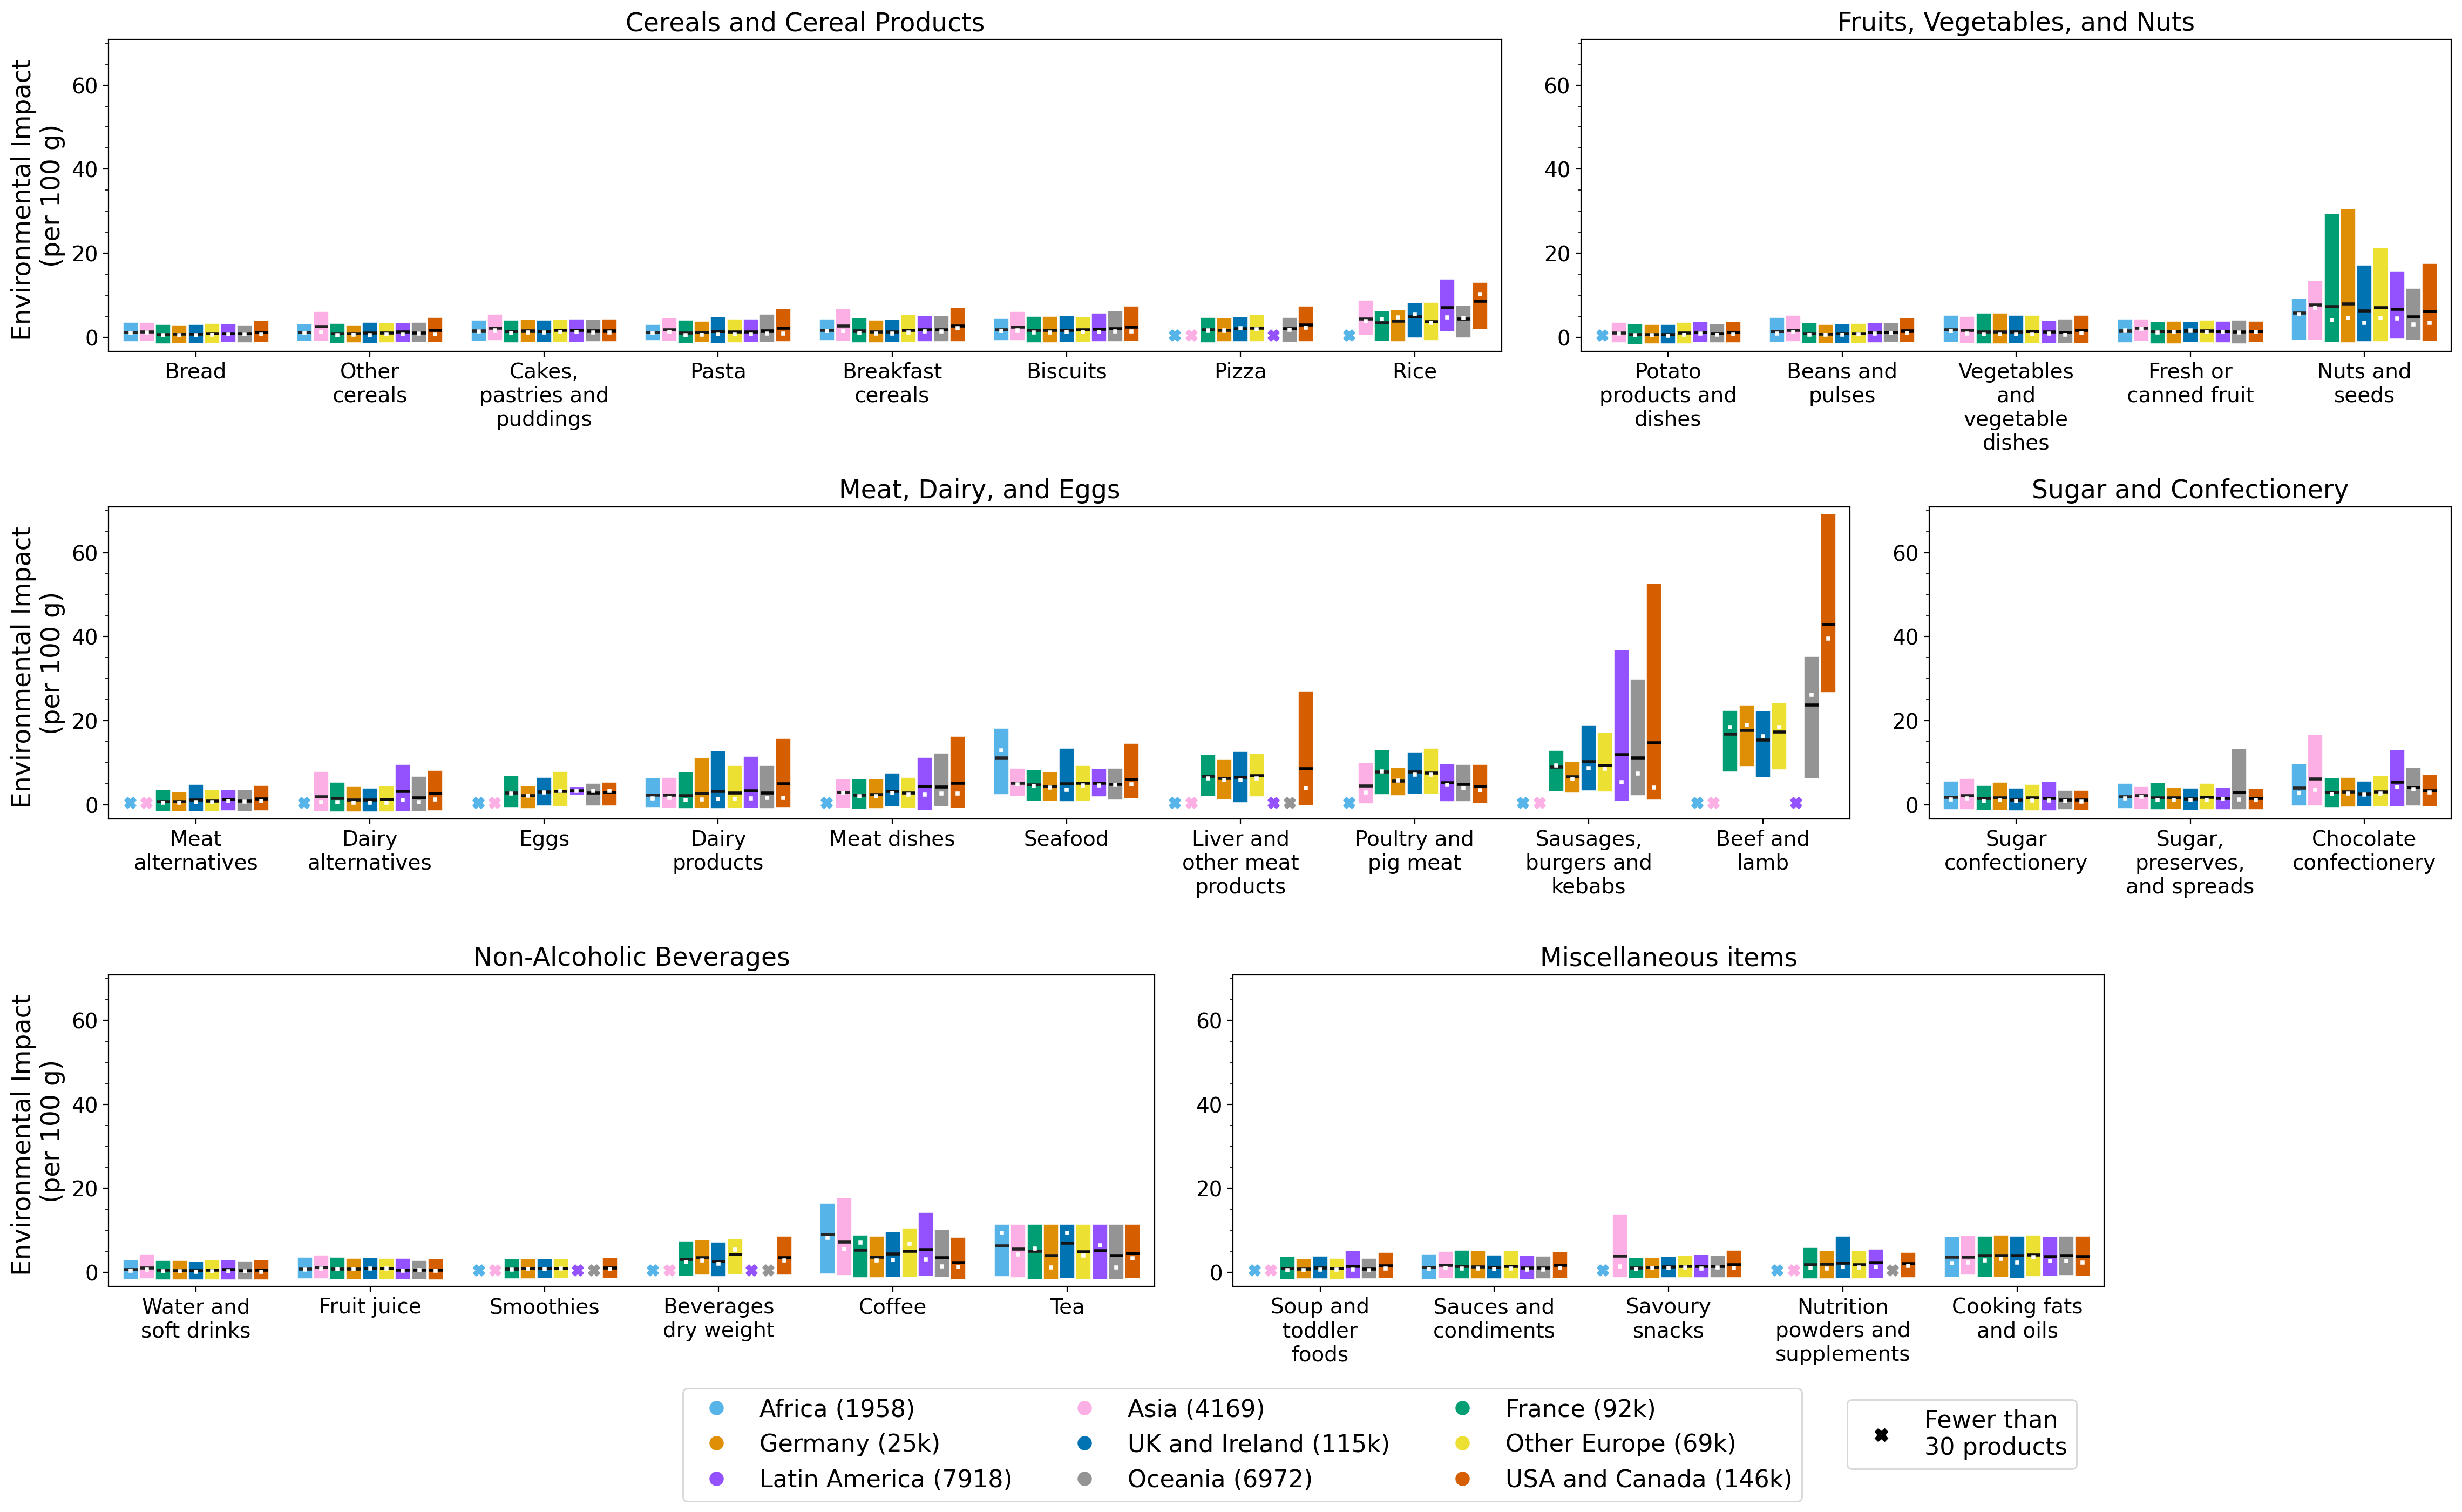

In [53]:
# order
groups = ['Cereals and Cereal Products', 'Fruits, Vegetables, and Nuts',
          'Meat, Dairy, and Eggs', 'Sugar and Confectionery', 
          'Non-Alcoholic Beverages', 'Miscellaneous items']

countries_order = ['Africa', 'Asia', 'France', 'Germany', 'UK and Ireland',
                   'Other Europe', 'Latin America', 'Oceania',
                   'USA and Canada']

# n rows
groups_split = np.array_split(groups, 3)

fig = plt.figure(figsize=(28, 15))

# outer GridSpec with 3 rows
# defining a second column as the last row has fewer categories than the first 2 
outer_gs = GridSpec(
    nrows=3, ncols=2,
    width_ratios=[11.5, 2],  
    height_ratios=[1, 1, 1],
    wspace=0, hspace=0.5
)

master_ax = None

def wrap_tick_labels(ax, width=10):
    labels = ax.get_xticklabels()
    ticks = ax.get_xticks()  
    ax.set_xticks(ticks)
    wrapped_labels = []
    for lbl in labels:
        # textwrap.fill wraps the string to the given width
        wrapped_labels.append(textwrap.fill(lbl.get_text(), width=width, break_long_words=False))
    ax.set_xticklabels(wrapped_labels, rotation=0)

for row_idx, row_groups in enumerate(groups_split):
    
    # For each row, compute width ratios based on the number of labels per group
    width_ratios = []
    for grp in row_groups:
        n_labels = len(order_df[order_df['groups'] == grp]['labels'].unique())
        width_ratios.append(n_labels)
    
    # subgridspec for this row
    if row_idx!=2:
        inner_gs = outer_gs[row_idx, :].subgridspec(
            1, len(row_groups),
            width_ratios=width_ratios,
            wspace=0.07
        )
    else:
        inner_gs = outer_gs[row_idx, 0].subgridspec(
            1, len(row_groups),
            width_ratios=width_ratios,
            wspace=0.082
        )
    
    for col_idx, grp in enumerate(row_groups):
        # If we haven't assigned a master axis yet, do so now.
        if master_ax is None:
            ax = fig.add_subplot(inner_gs[col_idx])
            master_ax = ax
        else:
            # sharey=master_ax ensures all subplots share the same y-scale
            ax = fig.add_subplot(inner_gs[col_idx], 
                                 sharey=master_ax
                                )
        
        # Subset data for this group
        data = df_plot[
            (df_plot['groups'] == grp)
        ]
         
        # Determine the x-label order for this group
        order = order_df[order_df['groups'] == grp]['labels'].values
        dodge = 0.75
        palette = sns.color_palette(["#56b4e9", "#fbafe4", "#029e73", "#de8f05", "#0173b2", "#ece133", 
                                         #"#cc78bc", 
                                         "#9352fe",  "#949494", "#d55e00", #"#d7a377"
                                        ])
        country_colors = dict(zip(countries_order, palette))
        
        
        sns.pointplot(
            x='labels',
            y='mean_norm_agg',
            hue='country',
            hue_order=countries_order,
            data=data,
            order=order,  
            capsize=0,
            errorbar=('pi', 80),
            err_kws={'linewidth': 9.5},
            markers=".",
            markersize=5,
            linestyles='none',
            dodge=dodge,
            palette = palette,
            ax=ax
        )

        # adding this for eggs in latin america - since its a single point it was not visible - so adding a flat line for means in original colors
        sns.pointplot(
            x='labels',
            y='mean_norm_agg',
            estimator='mean',
            hue='country',
            hue_order=countries_order,
            data=data,
            order=order,  
            errorbar=None,
            markers="_",
            markersize=9,
            markeredgewidth=5,
            linestyles='none',
            dodge=dodge,
            ax=ax,
            palette=palette,
            legend=False
        )

        sns.pointplot(
            x='labels',
            y='mean_norm_agg',
            estimator='mean',
            hue='country',
            hue_order=countries_order,
            data=data,
            order=order,  
            errorbar=None,
            markers="_",
            markersize=9,
            markeredgewidth=2,
            linestyles='none',
            dodge=dodge,
            ax=ax,
            palette='dark:black',
            legend=False
        )

        sns.pointplot(
            x='labels',
            y='mean_norm_agg',
            estimator='median',
            hue='country',
            hue_order=countries_order,
            data=data,
            order=order,  
            errorbar=None,
            markers="s",
            markersize=1,
            markeredgewidth=2,
            linestyles='none',
            dodge=dodge,
            ax=ax,
            palette=sns.color_palette(["white"] * 9),
            legend=False
        )

        # to ensure same margins irrespective of widths
        ax.set_xlim(-0.5, len(order) - 0.5)

        # add symbols for missing bars 
        for i, label_i in enumerate(order):
            for j, country_j in enumerate(countries_order):
                # Check if there is data
                subset = data[(data['labels'] == label_i) & (data['country'] == country_j)]
                if subset.empty:
                    d = dodge + 0.1
                    x_coord = i - d/2 + d/(2*len(countries_order)) + (j * d/len(countries_order))  
                    y_coord = 0.5         
                    ax.scatter(
                        [x_coord], [y_coord],
                        color=country_colors[country_j],
                        marker="X",
                        s=50
                    )
        
        # Remove the subplot legend
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        
        # Wrap x-axis labels
        wrap_tick_labels(ax, width=12)

        # tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        # Enable minor ticks on the y-axis
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        # Style the minor ticks (shorter length, no labels)
        ax.tick_params(axis='y', which='minor', length=2, labelsize=0)
        
        # Clear x-axis label text, keep the subplot title
        ax.set_xlabel("")
        ax.set_title(grp, fontsize=17)
        
        # Only set y-label on the leftmost subplot in each row
        if col_idx == 0:
            ax.set_ylabel("Environmental Impact \n(per 100 g)", fontsize=17)
        else:
            ax.set_ylabel("")

# legend
reorder=lambda hl,nc:(sum((lis[i::nc]for i in range(nc)),[])for lis in hl)
handles_labels = master_ax.get_legend_handles_labels()

def short_num(n):
    if n >= 10000:
        return f"{round(n/1000)}k"
    else:
        return str(n)

handles_labels = (handles_labels[0], [f'{c} ({short_num(len(df_plot[df_plot['country']==c]))})' for c in handles_labels[1]])

fig.legend(
    *reorder(handles_labels, 3),
    fontsize=16,
    markerscale=3,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.03),
    ncol=3
)

missing_handle = matplotlib.lines.Line2D(
    [], [], color="black", marker="X", linestyle="None",
    markersize=8, label="Missing"
)

fig.legend(
    [missing_handle],
    ["Fewer than \n30 products"], fontsize=16,
    loc="lower right",  
    bbox_to_anchor=(0.78, -0.01)
)

plt.savefig('../../Product impacts paper/figures/main_fig.jpg', bbox_inches='tight', dpi=300)
plt.show()

#### deep dive into raw scores (not normalized)

In [54]:
# Melt the aggregated dataframe to long format for seaborn
melted_df = impacts.melt(
    id_vars=['country', 'groups', 'labels', 'ID', 'product_id'],
    value_vars=[f"mean_{score}" for score in score_columns],
    var_name='score',
    value_name='mean'
)

# Extract the score name
melted_df['score'] = melted_df['score'].str.replace('_mean', '')
melted_df['score'] = melted_df['score'].str.replace('mean_', '')

In [55]:
df_plot = melted_df.merge(country_groups[['Country', 'Intermediate Region Name', 'Sub-region Name', 'Region Name']], left_on='country',
                          right_on='Country').drop('Country', axis=1)
df_plot.loc[df_plot['country'].isin(['United Kingdom', 'Ireland']), 'country'] = 'UK and Ireland'
df_plot.loc[df_plot['country'].isin(['United States', 'Canada']), 'country'] = 'USA and Canada'

df_plot.loc[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada']), 'country'] = df_plot[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada'])]['Region Name']

df_plot.loc[df_plot['country'].isin(['Americas']), 'country'] = 'Latin America'
df_plot.loc[df_plot['country'].isin(['Europe']), 'country'] = 'Other Europe'

# remove category-country combinations when number of products is less than 30 - removes about 100 products
df = df_plot.groupby(['country', 'labels'])[['product_id']].nunique().reset_index()
df_plot = df_plot[~df_plot['product_id'].isin(df_plot.merge(df[df['product_id']<30][['country', 'labels']])['product_id'].unique())]

# remove asia, africa, latam, oceania
df_plot = df_plot[~df_plot['country'].isin(['Africa', 'Asia', 'Latin America', 'Oceania'])]

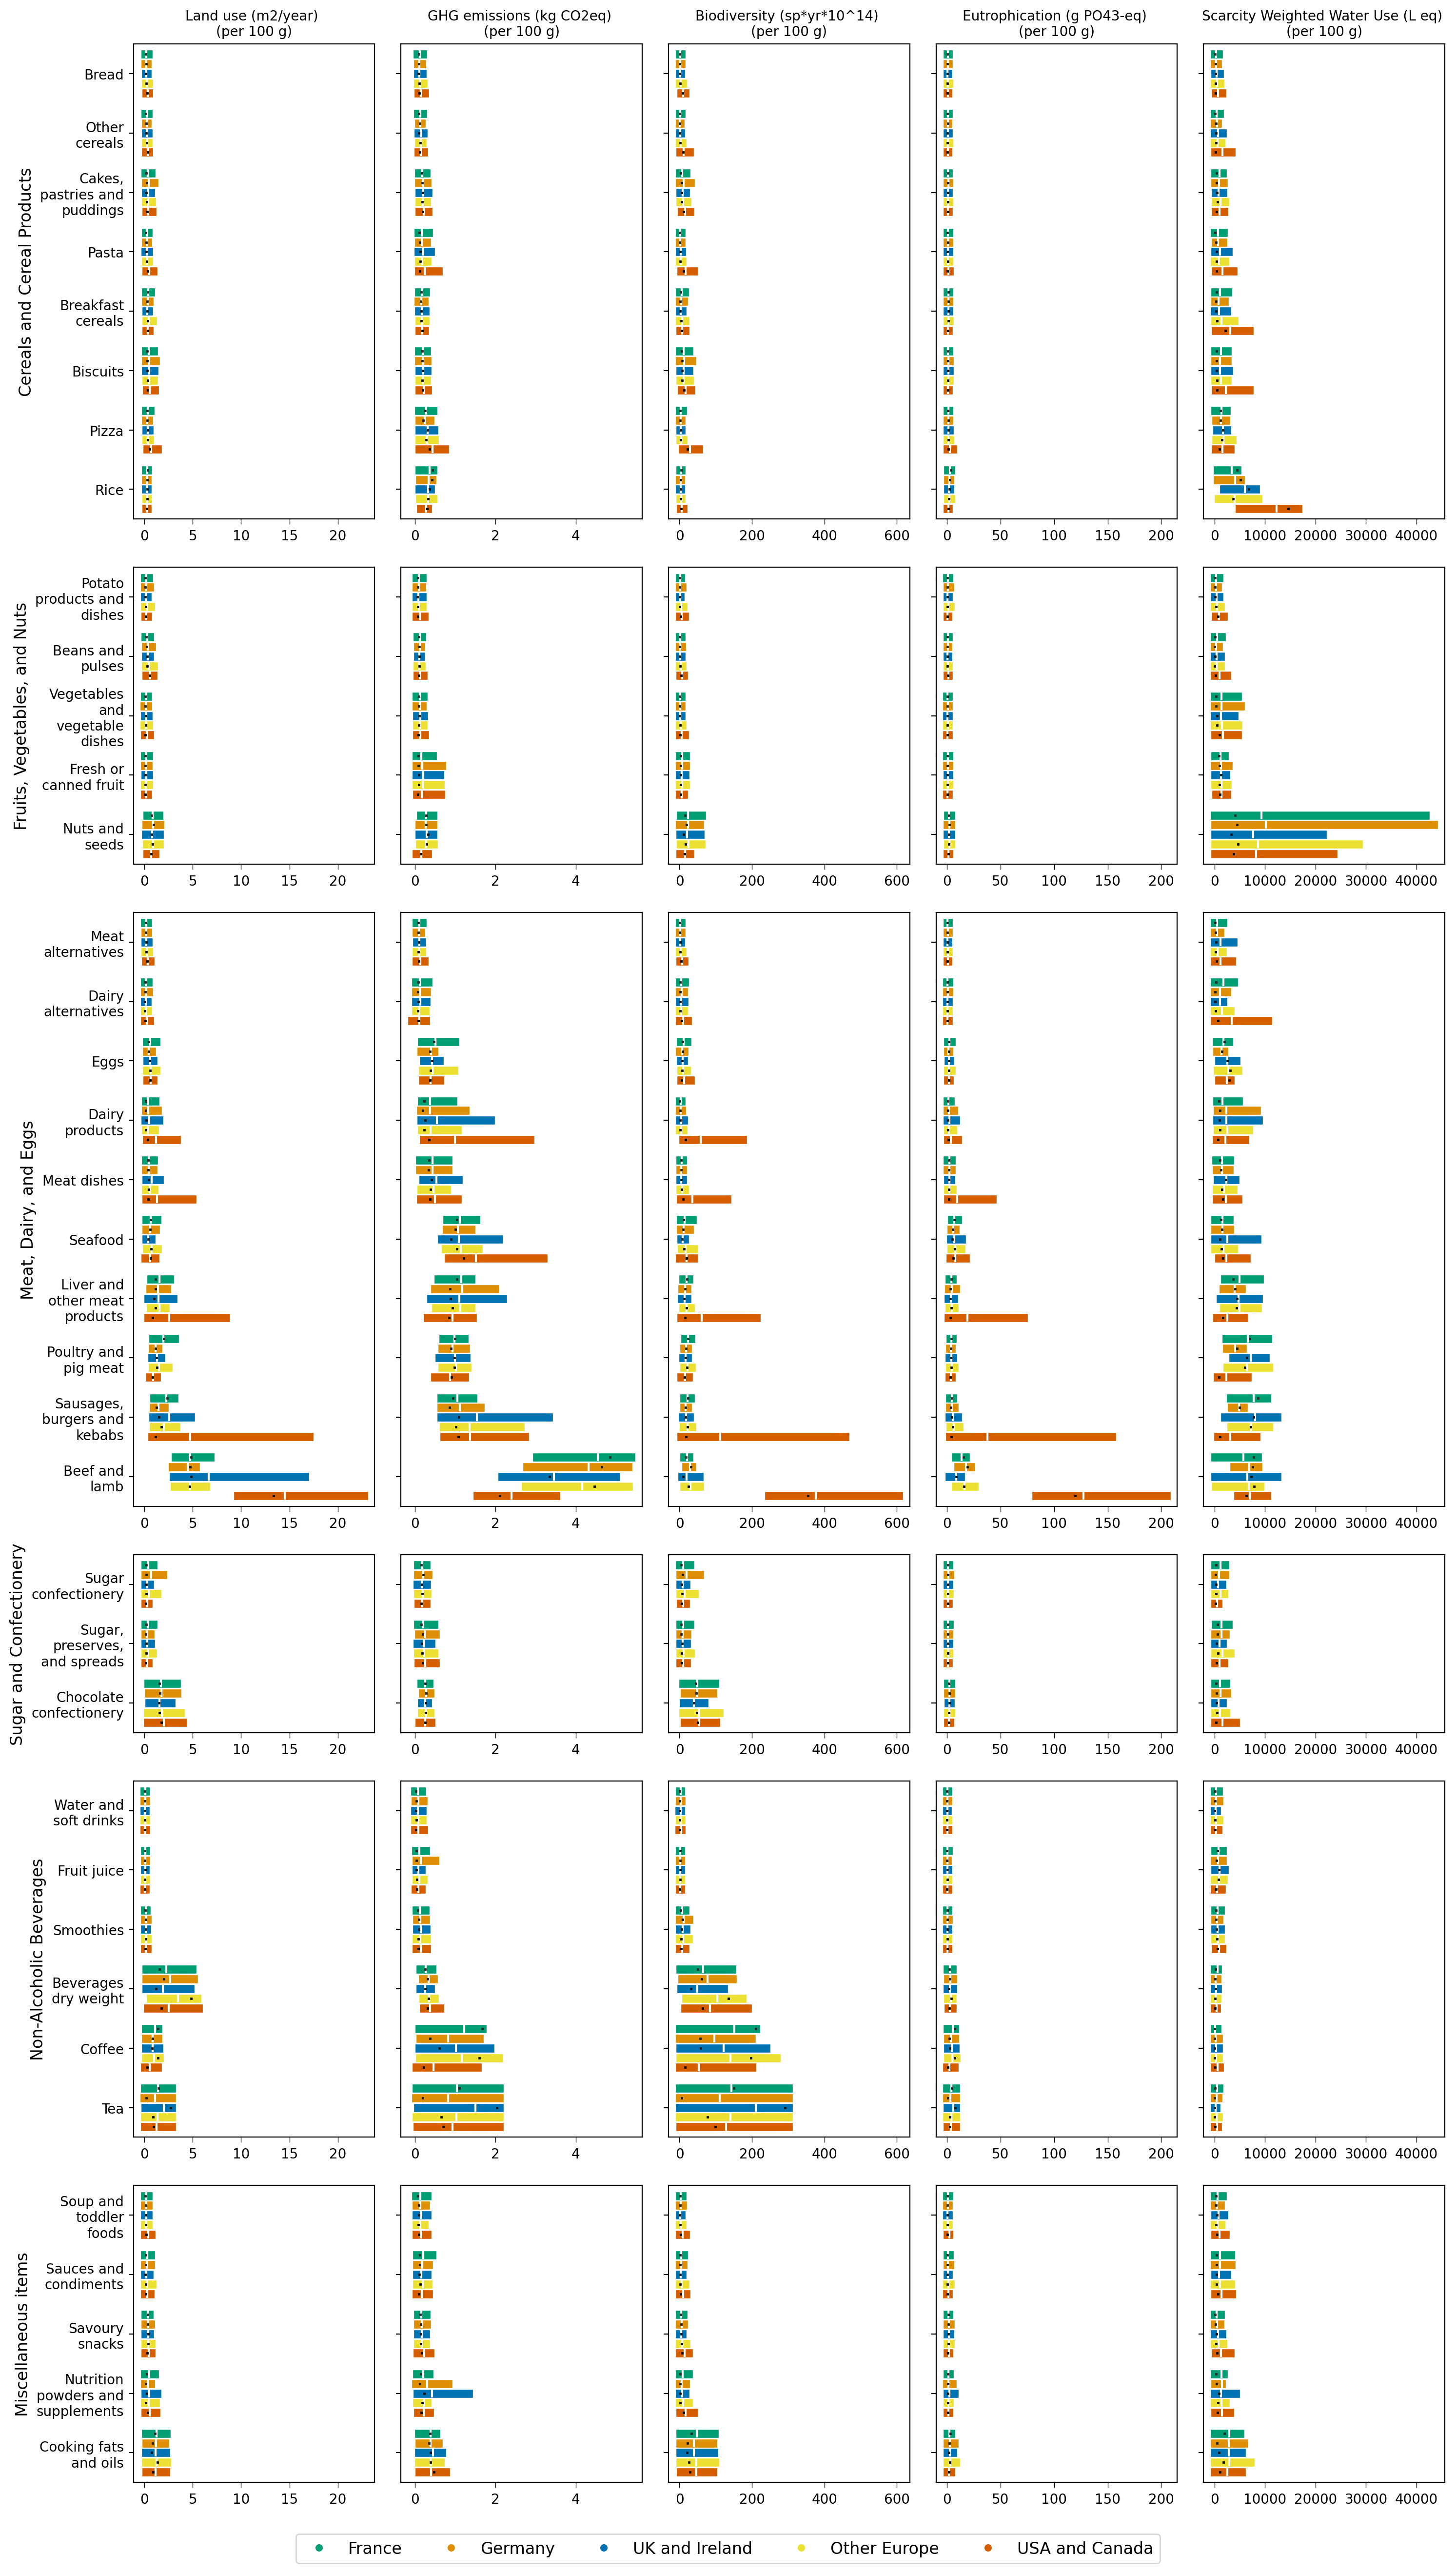

In [56]:
def wrap_tick_labels(ax, width=10):
    labels = ax.get_yticklabels()
    ticks = ax.get_yticks()  
    ax.set_yticks(ticks)
    wrapped_labels = []
    for lbl in labels:
        # textwrap.fill wraps the string to the given width
        wrapped_labels.append(textwrap.fill(lbl.get_text(), width=width, break_long_words=False))
    ax.set_yticklabels(wrapped_labels)

groups_list = ['Cereals and Cereal Products', 'Fruits, Vegetables, and Nuts',
               'Meat, Dairy, and Eggs', 'Sugar and Confectionery', 
               'Non-Alcoholic Beverages', 'Miscellaneous items']
scores_list = ['Land', 'GHG', 'Biodiversity', 'Eut', 'WatScar']

scores_dict = {'Land': "Land use (m2/year) \n(per 100 g)", 
               'GHG': "GHG emissions (kg CO2eq) \n(per 100 g)", 
               'Biodiversity': "Biodiversity (sp*yr*10^14) \n(per 100 g)", 
               'Eut': "Eutrophication (g PO43-eq) \n(per 100 g)", 
               'WatScar': "Scarcity Weighted Water Use (L eq) \n(per 100 g)"}

facet_counts = {}
for group in groups_list:
    for score in scores_list:
        data_sub = df_plot[(df_plot['groups'] == group) & (df_plot['score'] == score)]
        count = data_sub['labels'].nunique() 
        facet_counts[(group, score)] = count
        
inch_per_label = 0.7  
row_heights = []
for group in groups_list:
    max_count = max(facet_counts[(group, score)] for score in scores_list)
    row_heights.append(max_count * inch_per_label)

fig_width = len(scores_list) * 3 
fig_height = sum(row_heights)

fig = plt.figure(figsize=(fig_width, fig_height))
gs = GridSpec(nrows=len(groups_list), ncols=len(scores_list),
                       height_ratios=row_heights)

legend_handles = None

for j, score in enumerate(scores_list):
    master_ax = None
    for i, group in enumerate(groups_list):
        if master_ax is None:
            ax = fig.add_subplot(gs[i, j])
            master_ax = ax
        else:
            # sharey=master_ax ensures all subplots share the same y-scale
            ax = fig.add_subplot(gs[i, j], 
                                 sharex=master_ax
                                )
        # Filter data for this facet.
        data = df_plot[
            (df_plot['score'] == score) &
            (df_plot['groups'] == group)
        ]

        # Determine the x-label order for this group
        order = order_df[order_df['groups'] == group]['labels'].values
        
        # Plot with barplot
        sns.pointplot(
            y='labels',
            x='mean',
            hue='country',
            hue_order=['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada'],
            data=data,
            order=order,  
            capsize=0,
            errorbar=('pi', 80),
            err_kws={'linewidth': 6},
            markers=".",
            linestyles='none',
            dodge=0.65,
            palette=sns.color_palette(["#029e73", "#de8f05", "#0173b2", "#ece133", "#d55e00"]),
            ax=ax
        )

        sns.pointplot(
            y='labels',
            x='mean',
            estimator='mean',
            hue='country',
            hue_order=['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada'],
            data=data,
            order=order,  
            errorbar=None,
            markers="|",
            markersize=6,
            markeredgewidth=1.5,
            linestyles='none',
            dodge=0.65,
            ax=ax,
            palette=sns.color_palette(["white"] * 5),
            legend=False
        )

        sns.pointplot(
            y='labels',
            x='mean',
            estimator='median',
            hue='country',
            hue_order=['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada'],
            data=data,
            order=order,  
            errorbar=None,
            markers="s",
            markersize=1,
            markeredgewidth=1,
            linestyles='none',
            dodge=0.65,
            ax=ax,
            palette='dark:black',
            legend=False
        )

        # Remove the subplot legend
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        
        # Wrap y-axis labels
        wrap_tick_labels(ax, width=12)
        ax.tick_params(axis='both', which='major', labelsize=10)
        
        ax.tick_params(axis='x', which='major', bottom=True, top=False, length=4, width=0.5)
        ax.tick_params(axis='y', which='major', left=True, right=False)
        ax.set_xlabel("")
        if i == 0:
            ax.set_title(scores_dict[score], fontsize=10)
        if j==0:
            ax.set_ylabel(group, fontsize=12)
        else:
            ax.set_ylabel("")
            ax.set_yticklabels("")

        if legend_handles is None:
            handles, labels = ax.get_legend_handles_labels()
            legend_handles = (handles, labels)


handles, leg_labels = legend_handles
# Place the legend below all subplots.
fig.legend(handles, leg_labels, title="", loc="lower center",
           fontsize=12, ncol=5, bbox_to_anchor=(0.5, -0.02))

# Adjust layout
plt.tight_layout(h_pad=1.8, w_pad=1.4
                )

plt.savefig('../../Product impacts paper/figures/fig2.jpg', bbox_inches='tight', dpi=300)
plt.show()

#### zooming into specific categories - across more countries 

In [57]:
### BEEF

In [58]:
ids = impacts[impacts['labels'].isin(['Beef and lamb', 'Sausages, burgers and kebabs', 
                                      'Meat dishes', 
                                      'Liver and other meat products'
                                     ])]['product_id'].unique()
df_plot = impacts[(impacts['product_id'].isin(ids))
        & (impacts['product_id'].isin(composition[composition['Food_Category'].isin([
            'Bovine Meat (dairy herd)', 'Bovine Meat (beef herd)'
        ])]['id'].unique()))]

df_plot = df_plot[['product_id', 'product_name', 'ingredients_text', 'country', 'store', 'groups', 'labels', 'ID', 'mean_norm_agg']]
composition_sub = composition[(composition['id'].isin(df_plot['product_id'].unique())) 
                              & (composition['Food_Category'].isin(['Bovine Meat (dairy herd)', 
                                                                    'Bovine Meat (beef herd)']))
].groupby(['id'])[['percent']].sum().reset_index()
df_plot = df_plot.merge(composition_sub, left_on='product_id', right_on='id').drop('id', axis=1)
df_plot = df_plot[df_plot['percent']>=10] #only looking at products with at least 10% beef

df_plot = df_plot.merge(country_groups[['Country', 'Intermediate Region Name', 'Sub-region Name', 'Region Name']], left_on='country',
                          right_on='Country').drop('Country', axis=1)
df_plot.loc[df_plot['country'].isin(['United Kingdom', 'Ireland']), 'country'] = 'UK and Ireland'
df_plot.loc[df_plot['country'].isin(['United States', 'Canada']), 'country'] = 'USA and Canada'

df_plot.loc[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada']), 'country'] = df_plot[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada'])]['Region Name']

df_plot.loc[df_plot['country'].isin(['Americas']), 'country'] = 'Latin America'
df_plot.loc[df_plot['country'].isin(['Europe']), 'country'] = 'Other Europe'

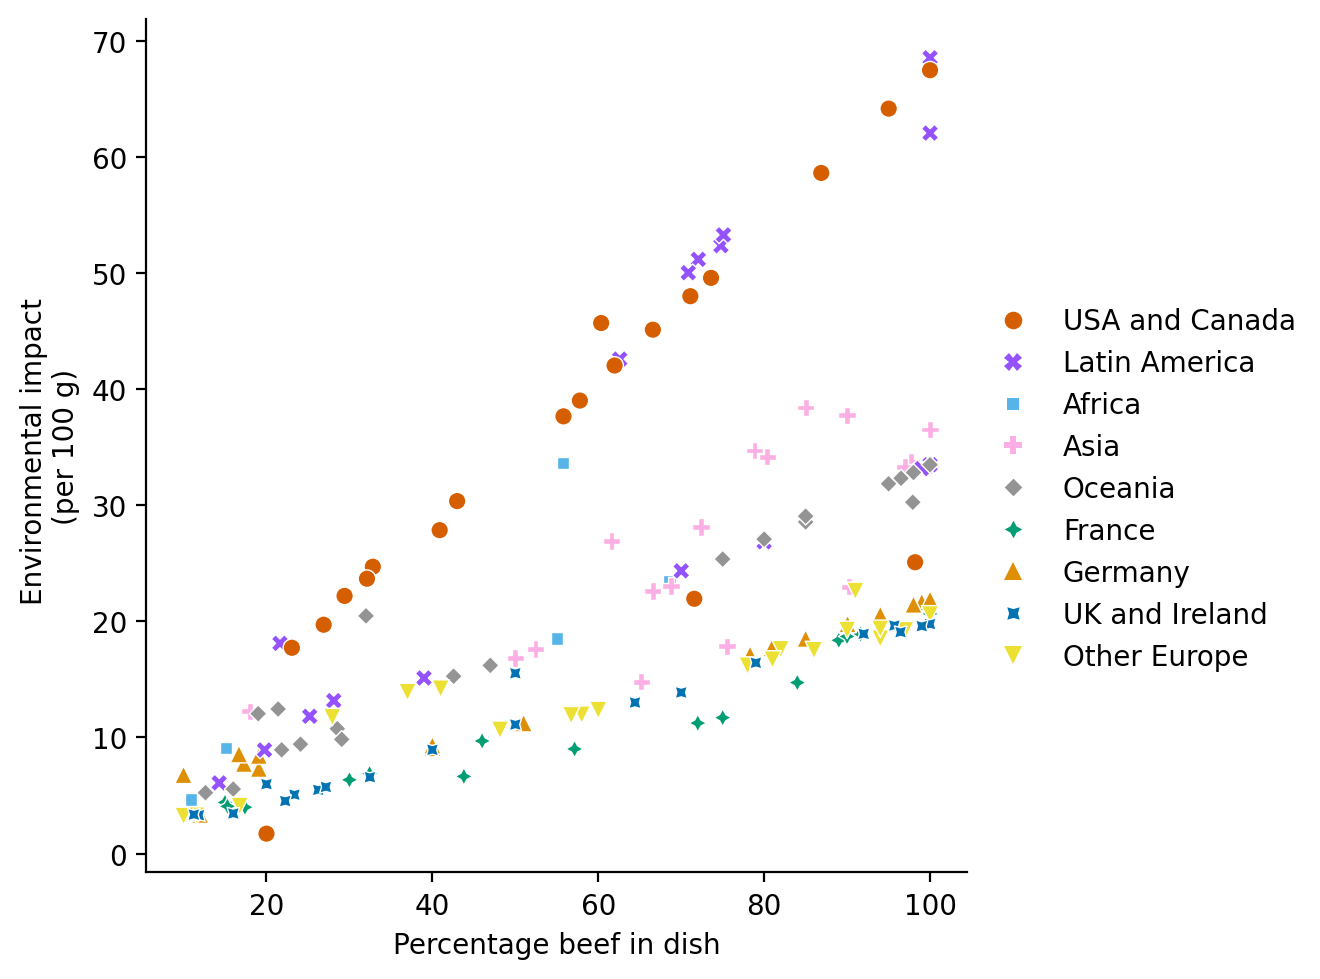

In [59]:
df_plot1 = df_plot[df_plot['country'].isin(['Africa', 'Asia'])] # as they have less than 20 obs
df_plot2 = df_plot[~df_plot['country'].isin(['Africa', 'Asia'])]
df_plot = pd.concat([df_plot1, df_plot2.groupby(['country']).sample(n=20, random_state=1)], axis=0, ignore_index=True)

g = sns.relplot(
    data=df_plot, x="percent", y="mean_norm_agg",
    hue="country", style='country',
    hue_order = ['USA and Canada', 'Latin America',
                 'Africa', 'Asia', 'Oceania',
                 'France', 'Germany', 'UK and Ireland', 'Other Europe'
                 ], 
    style_order = ['USA and Canada', 'Latin America',
                   'Africa', 'Asia', 'Oceania',
                   'France', 'Germany', 'UK and Ireland', 'Other Europe'
                   ], 
    kind="scatter", s=40, alpha=1,
    # palette=sns.color_palette("husl", df_plot['country'].nunique())
    palette = sns.color_palette(["#d55e00", "#9352fe", "#56b4e9", "#fbafe4", "#949494", 
                                 "#029e73", "#de8f05", "#0173b2", "#ece133"])
)
g.set(xlabel='Percentage beef in dish', ylabel='Environmental impact \n(per 100 g)')
if g._legend is not None:
    g._legend.set_title(None)  

plt.show()

In [60]:
### DAIRY - its not really possible to split dairy alt like this, but can just say in text that dairy alt in original chart contains 
            # all typles of prods like milk, cream, cheese, and all types of substitutes like oat, soy, almond 

In [61]:
df_plot = impacts[(impacts['labels']=='Dairy products') & (impacts['Shelf'].isin(
    ['Other milk', 'Other cheese', 'Ice cream',
    'Cream (including imitation cream)',
    'Reduced fat spread (polyunsaturated)', 'Yogurt', 'Cheddar cheese',
    'Cottage cheese', 'Butter',
    'Fromage frais and other dairy desserts',
    'Reduced fat spread (not polyunsaturated)',
    'Polyunsaturated low fat spread', 'Whole milk', '1% Milk',
    'Polyunsaturated margarine', 'Semi-skimmed milk', 'Infant formula',
    'Block margarine', 'Skimmed milk',
    'Soft margarine not polyunsaturated',
    'Low fat spread not polyunsaturated']
))]


df_plot.loc[df_plot['Shelf'].isin(['Cheddar cheese','Cottage cheese', 'Other cheese']), 'Shelf'] = 'Cheese'
df_plot.loc[df_plot['Shelf'].isin(['Whole milk', '1% Milk', 'Other milk', 
                                   'Semi-skimmed milk', 'Infant formula',
                                   'Skimmed milk']), 'Shelf'] = 'Milk'
df_plot.loc[df_plot['Shelf'].isin(['Yogurt', 'Ice cream', 'Fromage frais and other dairy desserts',
                                   'Cream (including imitation cream)']), 'Shelf'] = 'Yogurt, cream and ice cream'
df_plot.loc[df_plot['Shelf'].isin(['Butter', 'Reduced fat spread (polyunsaturated)', 
                                   'Reduced fat spread (not polyunsaturated)', 
                                   'Polyunsaturated low fat spread', 'Polyunsaturated margarine', 
                                   'Block margarine', 'Soft margarine not polyunsaturated', 
                                   'Low fat spread not polyunsaturated']), 'Shelf'] = 'Butter and spreads'

# some milk, cream etc wrongly categorized as cheese - remove for this visualization (note in paper, some 6k removed but from all countries not just the 6 from earlier)
ids = df_plot[(df_plot['Shelf']=='Cheese')]['product_id'].unique()
composition_sub = composition[(composition['id'].isin(ids)) 
                              & (composition['Food_Category'].isin(['Cheese']))]
df_plot.loc[(df_plot['Shelf']=='Cheese') & (~df_plot['product_id'].isin(composition_sub['id'].unique())), 'Shelf'] = 'mis'
df_plot = df_plot[df_plot['Shelf']!='mis']

df_plot = df_plot.merge(country_groups[['Country', 'Intermediate Region Name', 'Sub-region Name', 'Region Name']], left_on='country',
                          right_on='Country').drop('Country', axis=1)
df_plot.loc[df_plot['country'].isin(['United Kingdom', 'Ireland']), 'country'] = 'UK and Ireland'
df_plot.loc[df_plot['country'].isin(['United States', 'Canada']), 'country'] = 'USA and Canada'

df_plot.loc[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada']), 'country'] = df_plot[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada'])]['Region Name']

df_plot.loc[df_plot['country'].isin(['Americas']), 'country'] = 'Latin America'
df_plot.loc[df_plot['country'].isin(['Europe']), 'country'] = 'Other Europe'

# remove category-country combinations when number of products is less than 30 - removes about 100 products
df = df_plot.groupby(['country', 'Shelf'])[['product_id']].nunique().reset_index()
df_plot = df_plot[~df_plot['product_id'].isin(df_plot.merge(df[df['product_id']<30][['country', 'Shelf']])['product_id'].unique())]

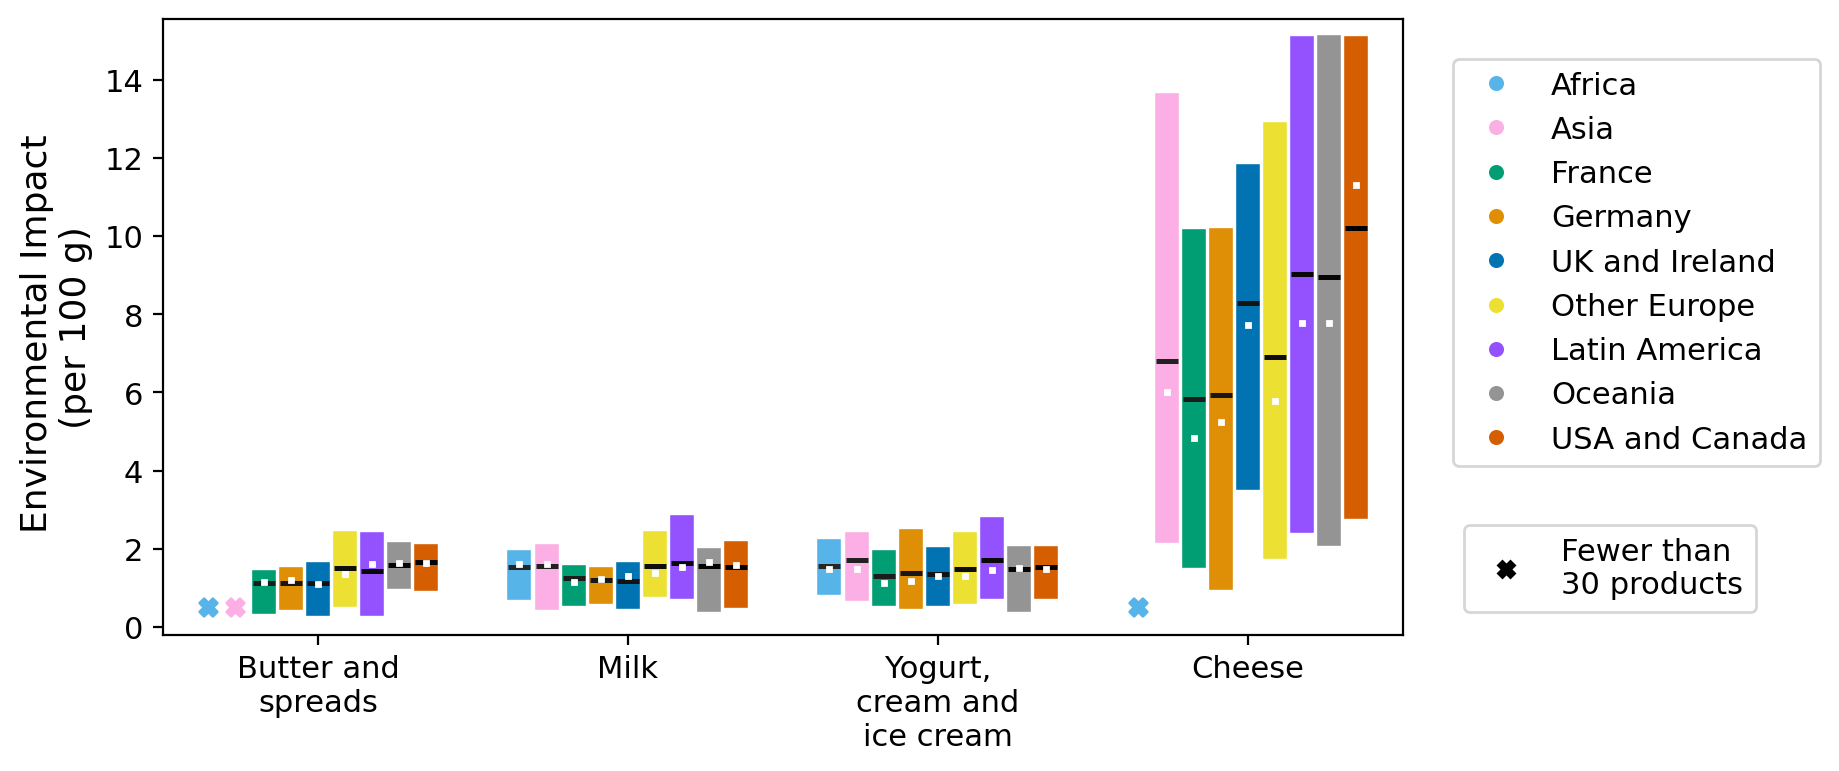

In [62]:
def wrap_tick_labels(ax, width=10):
    labels = ax.get_xticklabels()
    ticks = ax.get_xticks()  
    ax.set_xticks(ticks)
    wrapped_labels = []
    for lbl in labels:
        # textwrap.fill wraps the string to the given width
        wrapped_labels.append(textwrap.fill(lbl.get_text(), width=width, break_long_words=False))
    ax.set_xticklabels(wrapped_labels, rotation=0)

fig, ax = plt.subplots(figsize=(8, 4))

countries_order = ['Africa', 'Asia', 'France', 'Germany', 'UK and Ireland',
                   'Other Europe', 'Latin America', 'Oceania',
                   'USA and Canada']
dodge = 0.7
order = ['Butter and spreads', 'Milk', 'Yogurt, cream and ice cream', 'Cheese']
palette = sns.color_palette(["#56b4e9", "#fbafe4", "#029e73", "#de8f05", "#0173b2", "#ece133", 
                                 #"#cc78bc", 
                                 "#9352fe",  "#949494", "#d55e00", #"#d7a377"
                                ])
country_colors = dict(zip(countries_order, palette))

sns.pointplot(
    x='Shelf',
    y='mean_norm_agg',
    hue='country',
    hue_order=countries_order,
    data=df_plot,
    order=order,
    capsize=0,
    errorbar=('pi', 80),
    err_kws={'linewidth': 8.5},
    markers=".",
    linestyles='none',
    dodge=dodge,
    palette=palette,
    ax=ax
)

sns.pointplot(
    x='Shelf',
    y='mean_norm_agg',
    estimator='mean',
    hue='country',
    hue_order=countries_order,
    data=df_plot,
    order=order,
    errorbar=None,
    markers="_",
    markersize=8,
    markeredgewidth=1.8,
    linestyles='none',
    dodge=dodge,
    ax=ax,
    palette='dark:black',
    legend=False
)

sns.pointplot(
    x='Shelf',
    y='mean_norm_agg',
    estimator='median',
    hue='country',
    hue_order=countries_order,
    data=df_plot,
    order=order,
    errorbar=None,
    markers="s",
    markersize=1.5,
    markeredgewidth=1,
    linestyles='none',
    dodge=dodge,
    ax=ax,
    palette=sns.color_palette(["white"] * 9),
    legend=False
)

ax.set_xlim(-0.5, len(order) - 0.5)

# add symbols for missing bars 
for i, shelf_i in enumerate(order):
    for j, country_j in enumerate(countries_order):
        # Check if there is data
        subset = df_plot[(df_plot['Shelf'] == shelf_i) & (df_plot['country'] == country_j)]
        if subset.empty:
            d = dodge + 0.1
            x_coord = i - d/2 + d/(2*len(countries_order)) + (j * d/len(countries_order))  
            y_coord = 0.5         
            ax.scatter(
                [x_coord], [y_coord],
                color=country_colors[country_j],
                marker="X",
                s=40
            )

if ax.get_legend() is not None:
    ax.get_legend().remove()

# Wrap x-axis labels
wrap_tick_labels(ax, width=12)
ax.tick_params(axis='both', which='major', labelsize=11)

# Clear x-axis label text, keep the subplot title
ax.set_xlabel("")
ax.set_ylabel("Environmental Impact \n(per 100 g)", fontsize=13)


# legend
handles, labels = ax.get_legend_handles_labels()

fig.legend(
    handles, labels,
    fontsize=11,
    bbox_to_anchor=(1.17, 0.85)
)

missing_handle = matplotlib.lines.Line2D(
    [], [], color="black", marker="X", linestyle="None",
    markersize=6, label="Missing"
)

fig.legend(
    [missing_handle],
    ["Fewer than \n30 products"], fontsize=11,
    loc="lower right",  
    bbox_to_anchor=(1.13, 0.12)
)

plt.show()


#### confidence in results

In [63]:
# confidence in classification
# we dont have probabilities for food db. using a confidence of 1 for those
# for open food facts, confidence is 1 by default. when probabilities are lower than 0.5 for parent and/or subgroups, lower confidence is assigned
conf_df = impacts[['product_id', 'country', 'groups', 'labels']].merge(categories[['product_id', 'parentcategory_prob', 'subfoodgroup_prob']])
conf_df['classification'] = 100
conf_df.loc[(conf_df['parentcategory_prob']>0.5) & (conf_df['subfoodgroup_prob']<0.5), 'classification'] = 90
conf_df.loc[(conf_df['parentcategory_prob']<0.5) & (conf_df['subfoodgroup_prob']>0.5), 'classification'] = 80
conf_df.loc[(conf_df['parentcategory_prob']<0.5) & (conf_df['subfoodgroup_prob']<0.5), 'classification'] = 60
conf_df = conf_df.drop(['parentcategory_prob', 'subfoodgroup_prob'], axis=1)

In [64]:
# getting information about availability of lca data in source countries for all ingredients
trade_info = pd.read_csv('../../SFS/environmental_impacts/Data Inputs/LCA_data_by_country/trade_info.csv')
trade_info = trade_info.fillna(0)
trade_info.loc[trade_info['using_global_avg']==1, ['supplying_countries', 
                                                   'supplying_intermediate_regions', 
                                                   'supplying_regions', 
                                                   'global']] = [0, 0, 0, 100]

trade_info['lca_conf'] = trade_info['supplying_countries']*1 + trade_info['supplying_intermediate_regions']*0.8 \
+ trade_info['supplying_sub-regions']*0.6 + trade_info['supplying_regions']*0.4 + trade_info['global']*0.2


In [65]:
# to ensure matches between composition data and lca data 
composition1 = composition.copy()
composition1.loc[composition1['Food_Category']=='Animal Fats', 'Food_Category'] = 'Pig Meat'
composition1.loc[composition1['Food_Category']=='Butter, Cream & Ghee', 'Food_Category'] = 'Milk'
composition1.loc[composition1['Food_Category']=='Cereals & Oilcrops Misc.', 'Food_Category'] = 'Wheat & Rye (Bread)'
composition1.loc[composition1['Food_Category']=='Milk Chocolate', 'Food_Category'] = 'Dark Chocolate'
composition1.loc[composition1['Food_Category']=='Olives', 'Food_Category'] = 'Olive Oil'
composition1.loc[composition1['Food_Category']=='Sunflower seeds', 'Food_Category'] = 'Sunflower Oil'

composition1 = composition1[composition1['Food_Category'].notnull()]
composition1 = composition1.groupby(['id', 'country', 'Food_Category'])[['percent']].sum().reset_index().rename(columns={'id': 'product_id'})
composition1 = composition1.merge(impacts[['product_id']])

In [66]:
composition1 = composition1.merge(composition1.groupby('product_id')[['percent']].sum().reset_index().rename(columns={'percent': 'total'}))
composition1.loc[composition1['total']<=100, 'total'] = 100
composition1['percent'] = (composition1['percent'] / composition1['total']) * 100

In [67]:
# identified composition
composition1 = composition1.merge(country_groups, left_on='country', right_on='Country').drop([
    'M49 Code', 'Country', 'Intermediate Region Name', 'Sub-region Name', 'Region Name'], axis=1)
composition1 = composition1.merge(trade_info[['iso3', 'Food_Category', 'lca_conf']], how='left').fillna(100)
composition1['lca_conf'] = composition1['lca_conf'] * composition1['percent'] / 100
composition1 = composition1.groupby(['product_id'])[['lca_conf']].sum().reset_index()

In [68]:
conf_df = conf_df.merge(composition1)
conf_df['overall_confidence'] = conf_df['lca_conf'] * conf_df['classification'] / 100

In [69]:
conf_df.describe()

product_id  classification       lca_conf  overall_confidence
count  4.690010e+05   469001.000000  469001.000000       469001.000000
mean   2.321570e+14       99.438445      76.814663           76.380988
std    1.169989e+14        3.111024      17.357492           17.423118
min    1.188327e+07       60.000000      15.141923           12.000000
25%    2.911202e+14      100.000000      65.814526           65.188725
50%    2.911202e+14      100.000000      80.044885           79.603998
75%    2.911202e+14      100.000000      90.935984           90.550496
max    2.911202e+14      100.000000     100.000000          100.000000

In [70]:
conf_df.groupby(['country', 'labels']).agg({'overall_confidence': ['mean', 'count']}).reset_index().sample(10)

country                         labels overall_confidence      
                                                                  mean count
215           Brazil                  Beef and lamb          80.200000     2
26           Algeria                            Tea          59.315781     5
254         Bulgaria                          Bread          65.925194    67
1126           Japan            Sugar confectionery          83.910140     3
2282  United Kingdom                  Beef and lamb          57.182663  1158
183          Bolivia   Cakes, pastries and puddings          63.710878    62
166          Belgium          Sauces and condiments          74.196976   517
1077           Italy  Liver and other meat products          60.795158    14
207          Bolivia                      Smoothies          58.424097     1
915          Hungary                 Savoury snacks          54.771119    32

In [71]:
# classification prob
# compostion + availability of lca data for source countries   --- should this be weight by percent composition or percent contribution to impact?

# fish??? + num rows in lca / total weight???? - poore and nemecek only contains aquaculture, 50/50 split (wildcaught can have a confidence value of 0.4 by default and the remaining 50 can have a confidence value ddetermined from lca data)
# visualization to show mean confidence and num of prods in country/cateogry pair???


#### diet differences, food environments, and nutrition

In [72]:
df_plot = impacts[['country', 'groups', 'labels', 'ID', 'product_id', 'mean_norm_agg']]
df_plot = df_plot.merge(country_groups[['Country', 'Intermediate Region Name', 'Sub-region Name', 'Region Name']], left_on='country',
                        right_on='Country').drop('Country', axis=1)
df_plot.loc[df_plot['country'].isin(['United Kingdom', 'Ireland']), 'country'] = 'UK and Ireland'
df_plot.loc[df_plot['country'].isin(['United States', 'Canada']), 'country'] = 'USA and Canada'

df_plot.loc[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada']), 'country'] = df_plot[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada'])]['Region Name']

df_plot.loc[df_plot['country'].isin(['Americas']), 'country'] = 'Latin America'
df_plot.loc[df_plot['country'].isin(['Europe']), 'country'] = 'Other Europe'

In [73]:
df_plot.groupby(['country'])[['mean_norm_agg']].mean()

mean_norm_agg
country                      
Africa               2.682410
Asia                 3.234498
France               2.734146
Germany              2.368547
Latin America        2.604483
Oceania              2.402054
Other Europe         2.552154
UK and Ireland       2.633602
USA and Canada       3.155411

In [74]:
df_plot.groupby(['country'])[['mean_norm_agg']].median()

mean_norm_agg
country                      
Africa               1.490867
Asia                 1.646381
France               1.189435
Germany              1.191199
Latin America        1.260630
Oceania              1.286531
Other Europe         1.300319
UK and Ireland       1.331298
USA and Canada       1.389397

In [75]:
# df_plot.groupby(['country', 'labels'])[['mean_norm_agg']].mean().reset_index().sort_values(by='mean_norm_agg')

In [76]:
# remove asia, africa, latam, oceania
df_plot = df_plot[~df_plot['country'].isin(['Africa', 'Asia', 'Latin America', 'Oceania'])]

In [77]:
df_mapping = df_plot[['groups', 'labels', 'ID']].drop_duplicates()
df_mapping['group_ID'] = df_mapping.apply(lambda row: row['ID'][:-1], axis=1)

parent_to_sub = {}
for parent in df_mapping['group_ID'].unique():
    subs = df_mapping[df_mapping['group_ID'] == parent]['ID'].tolist()
    subs_sorted = sorted(subs)
    parent_to_sub[parent] = subs_sorted
    
ordered_parents = sorted(parent_to_sub.keys())

# Create an overall ordered list of sub-categories, grouping by parent.
ordered_subs = []
for parent in ordered_parents:
    ordered_subs.extend(parent_to_sub[parent])

In [78]:
# Assign a base color to each parent (using a Seaborn palette)
base_colors = sns.color_palette("deep", len(ordered_parents))
base_colors = [base_colors[i] for i in [4, 2, 3, 5, 0, 1]]
parent_color_dict = {parent: base_colors[i] for i, parent in enumerate(ordered_parents)}

# For each parent, generate a palette for its sub-categories (variations on the parent's color)
sub_color_dict = {}
for parent in ordered_parents:
    n_sub = len(parent_to_sub[parent])
    # Get the parent's base color in hex format
    base_hex = matplotlib.colors.to_hex(parent_color_dict[parent])
    # Generate a light palette variant. reverse=True so the first sub-category gets the darkest shade.
    sub_palette = sns.light_palette(base_hex, n_colors=n_sub, reverse=True)
    for sub, color in zip(parent_to_sub[parent], sub_palette):
        sub_color_dict[sub] = color

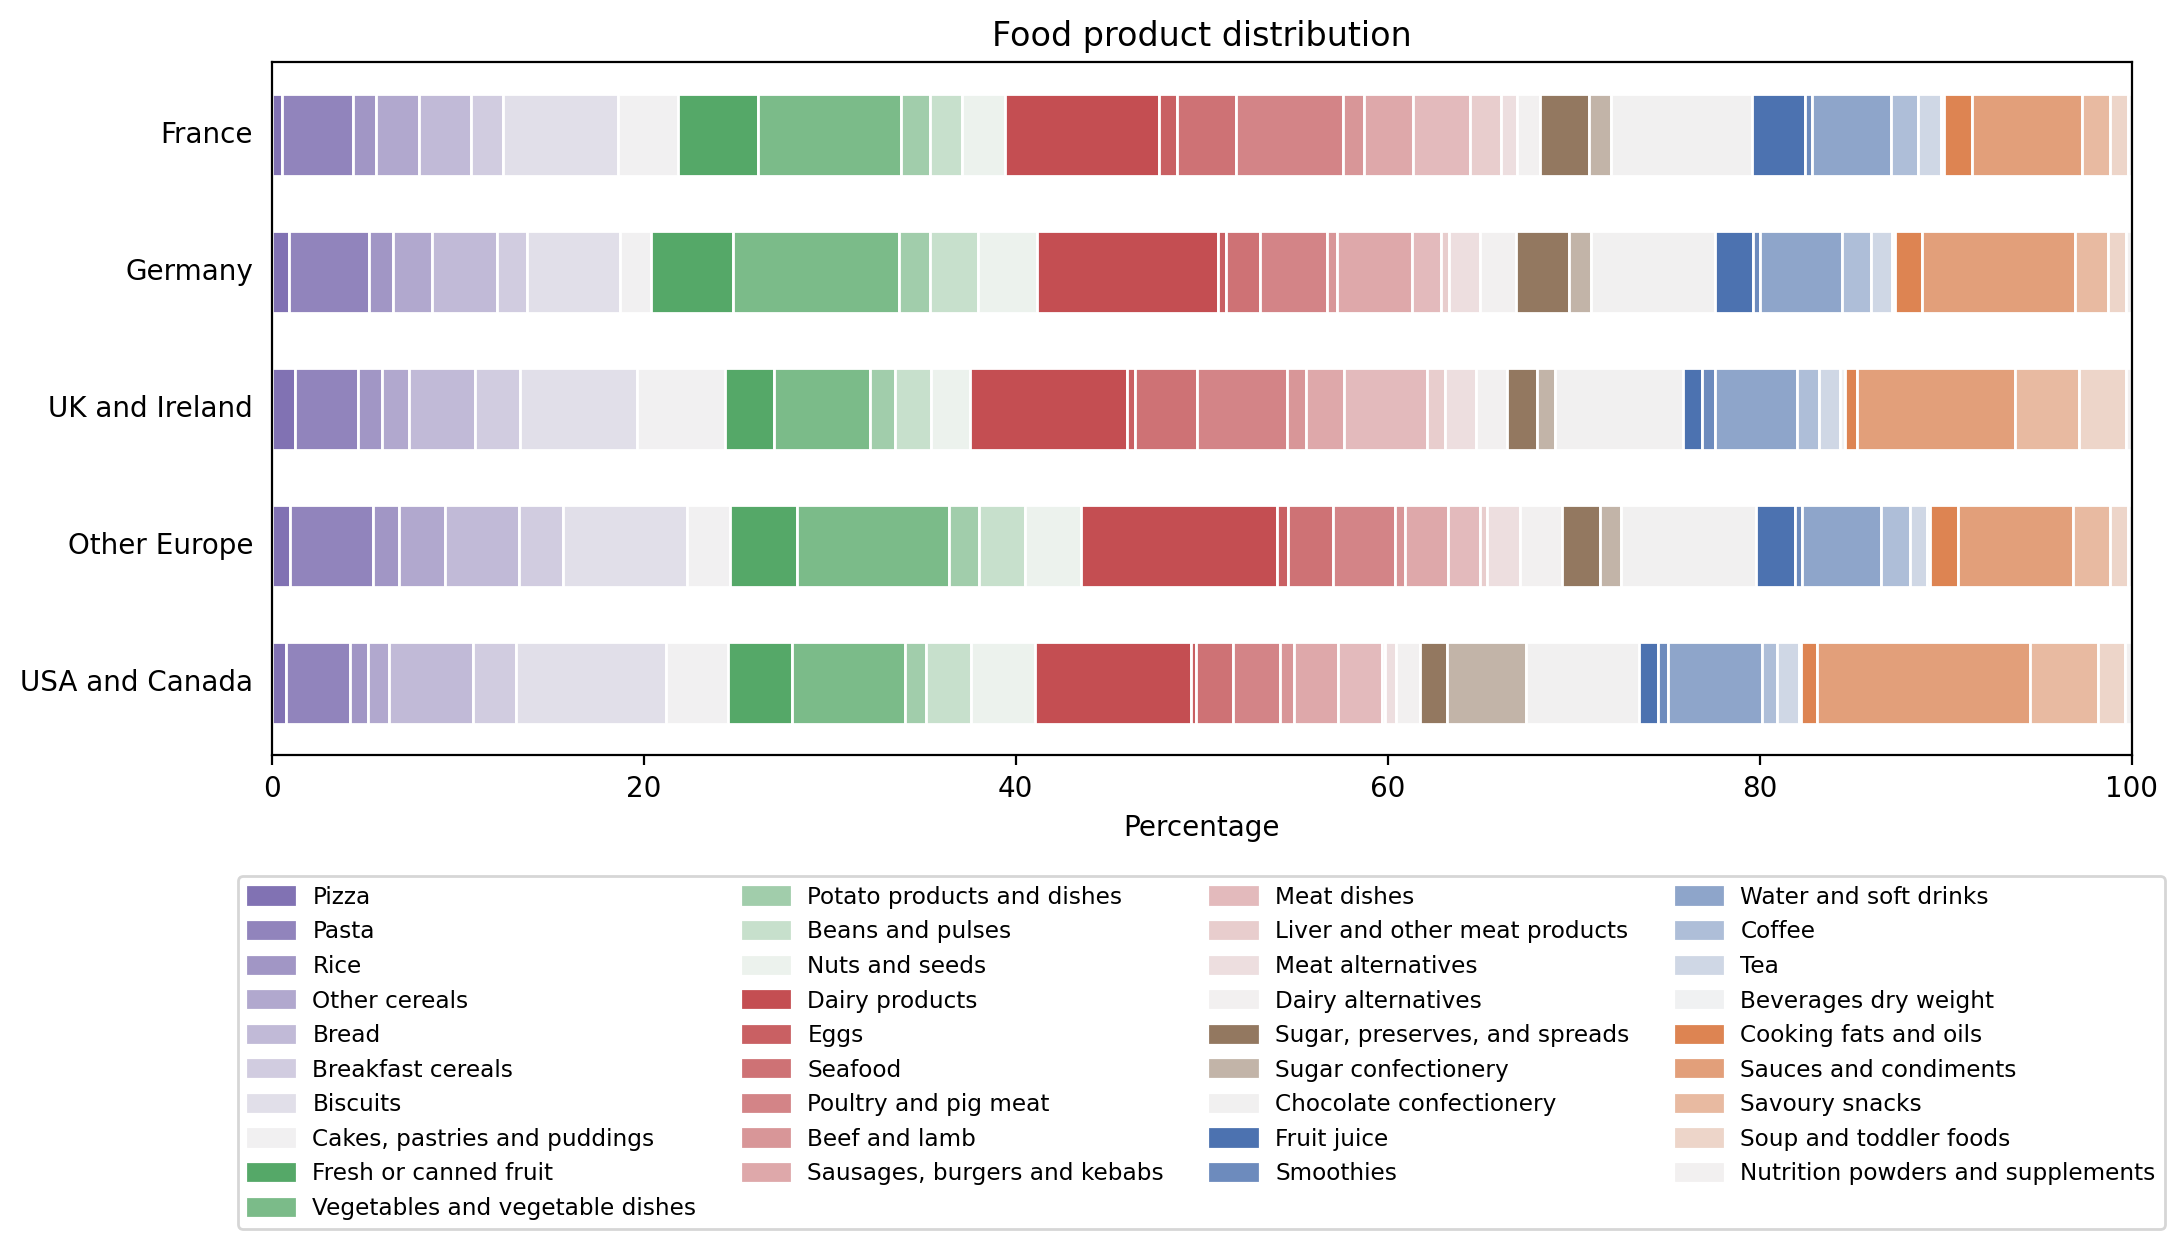

In [79]:
fig, ax = plt.subplots(figsize=(12, 4.5))

# Loop over countries. For each, compute percentages by sub_category and plot the stacked bar.
for i, country in enumerate(['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada'][::-1]):
    df_country = df_plot[df_plot['country'] == country]
    counts = df_country['ID'].value_counts()
    total = counts.sum()
    left = 0  # starting position for stacking segments
    for sub in ordered_subs:
        count = counts.get(sub, 0)
        pct = (count / total * 100) if total > 0 else 0
        # Draw the horizontal bar segment for this sub_category.
        ax.barh(i, pct, left=left, color=sub_color_dict[sub], edgecolor='white', height=0.6)
        left += pct
    ax.text(-1, i, country, va='center', ha='right', fontsize=10)

ax.set_xlim(0, 100)
ax.set_yticks([])  # Hide default y-axis ticks since we annotated the country names.
ax.set_xlabel("Percentage")
ax.set_title("Food product distribution")

# Create legend for parent categories (using their base colors)
legend_handles = []
for sub, color in sub_color_dict.items():
    patch = mpatches.Patch(color=color, label=df_mapping[df_mapping['ID']==sub]['labels'].values[0])
    legend_handles.append(patch)

# ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.legend(
    handles=legend_handles,
    loc='lower center',                
    bbox_to_anchor=(0.5, -0.7), 
    ncol=4,
    fontsize='small',
    # frameon=False
)

# plt.tight_layout()
plt.show()


In [80]:
df_plot = composition.copy().rename(columns={'id': 'product_id'})
# nulls haven't been removed, counting the number of values in ingredients text, as opposed to ingredient categories
df_plot = df_plot.merge(impacts[['product_id', 'groups', 'labels', 'mean_norm_agg']])
df_plot.loc[(df_plot['Food_Category'].notnull()) & (df_plot['value'].isna()), 'value'] = df_plot[(
    df_plot['Food_Category'].notnull()) & (df_plot['value'].isna())]['Food_Category']
df_plot = df_plot.groupby(['product_id', 'country', 'groups', 'labels', 'mean_norm_agg'])[['value']].nunique().reset_index()

In [81]:
df_plot = df_plot.merge(country_groups[['Country', 'Intermediate Region Name', 'Sub-region Name', 'Region Name']], left_on='country',
                        right_on='Country').drop('Country', axis=1)
df_plot.loc[df_plot['country'].isin(['United Kingdom', 'Ireland']), 'country'] = 'UK and Ireland'
df_plot.loc[df_plot['country'].isin(['United States', 'Canada']), 'country'] = 'USA and Canada'

df_plot.loc[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada']), 'country'] = df_plot[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada'])]['Region Name']

df_plot.loc[df_plot['country'].isin(['Americas']), 'country'] = 'Latin America'
df_plot.loc[df_plot['country'].isin(['Europe']), 'country'] = 'Other Europe'

df_plot = df_plot[~df_plot['country'].isin(['Africa', 'Asia', 'Latin America', 'Oceania'])]

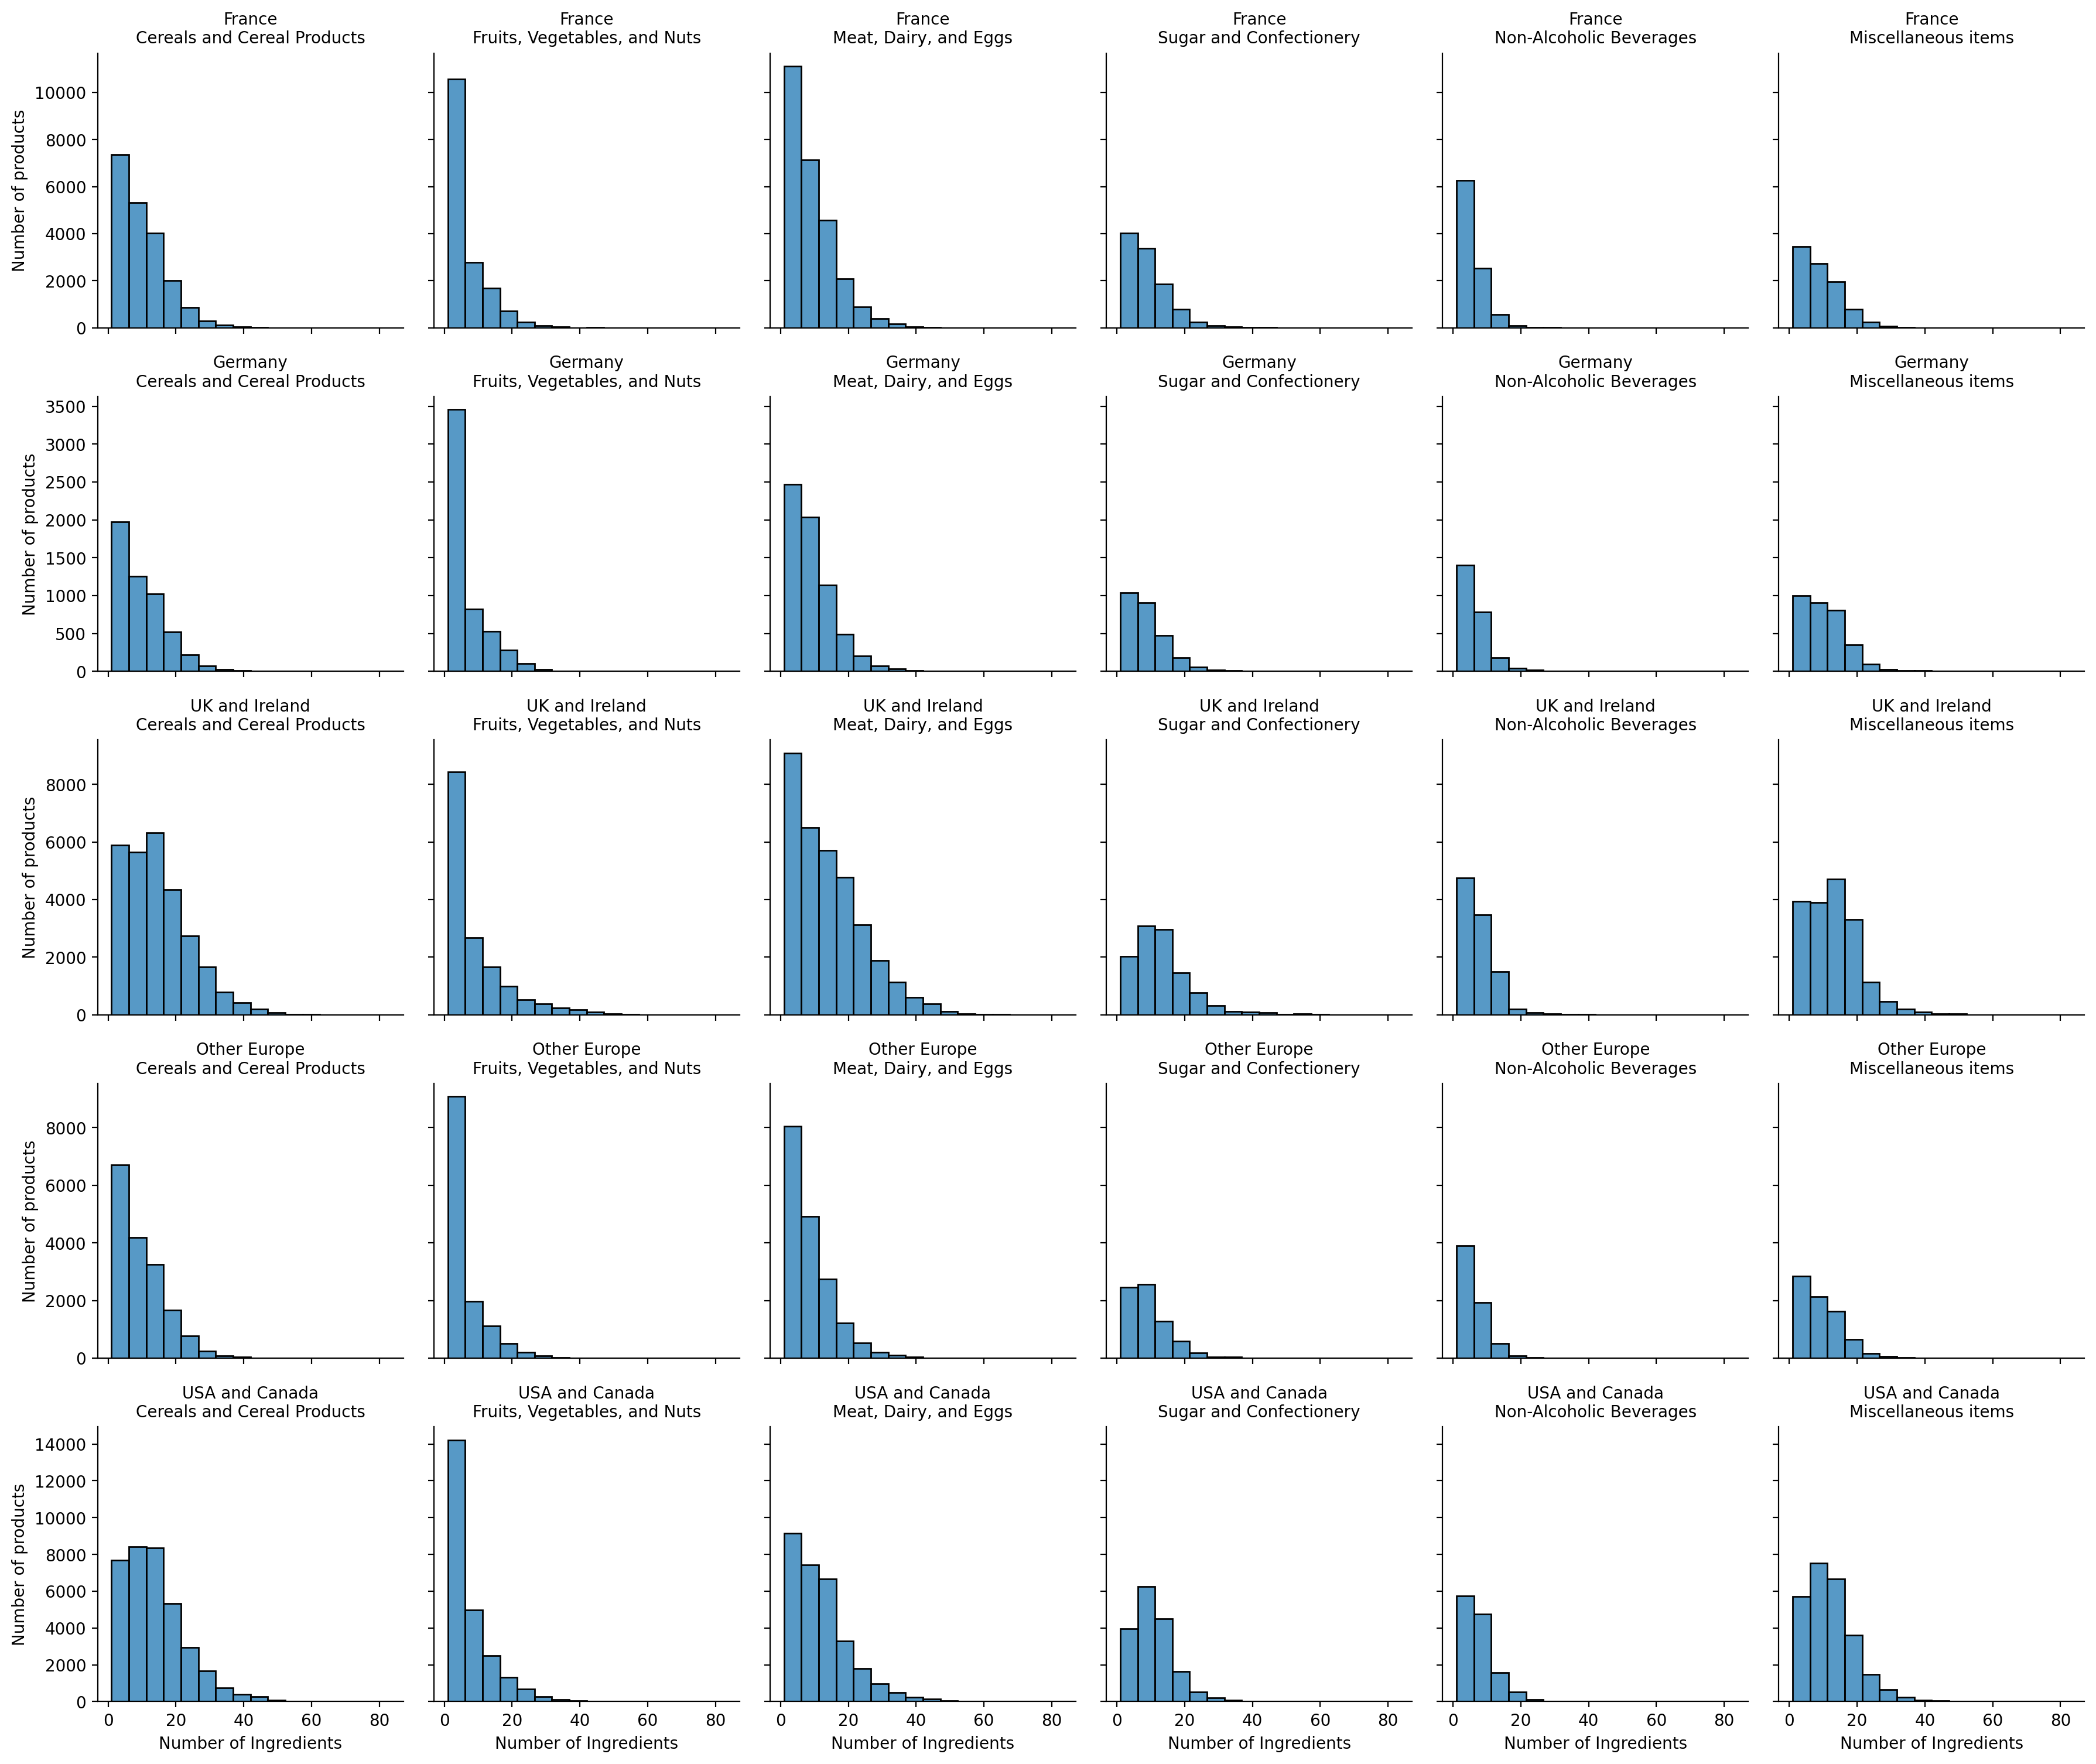

In [82]:
g = sns.displot(
    df_plot, x="value", col="groups", row="country",
    row_order=['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada'],
    col_order=['Cereals and Cereal Products', 'Fruits, Vegetables, and Nuts',
               'Meat, Dairy, and Eggs', 'Sugar and Confectionery', 
               'Non-Alcoholic Beverages', 'Miscellaneous items'],
    binwidth=5, height=3, facet_kws=dict(sharey='row'),
)

g.set_axis_labels("Number of Ingredients", "Number of products")
g.set_titles("{row_name}\n{col_name}")
g.fig.subplots_adjust(hspace=0.25, wspace=0.1)

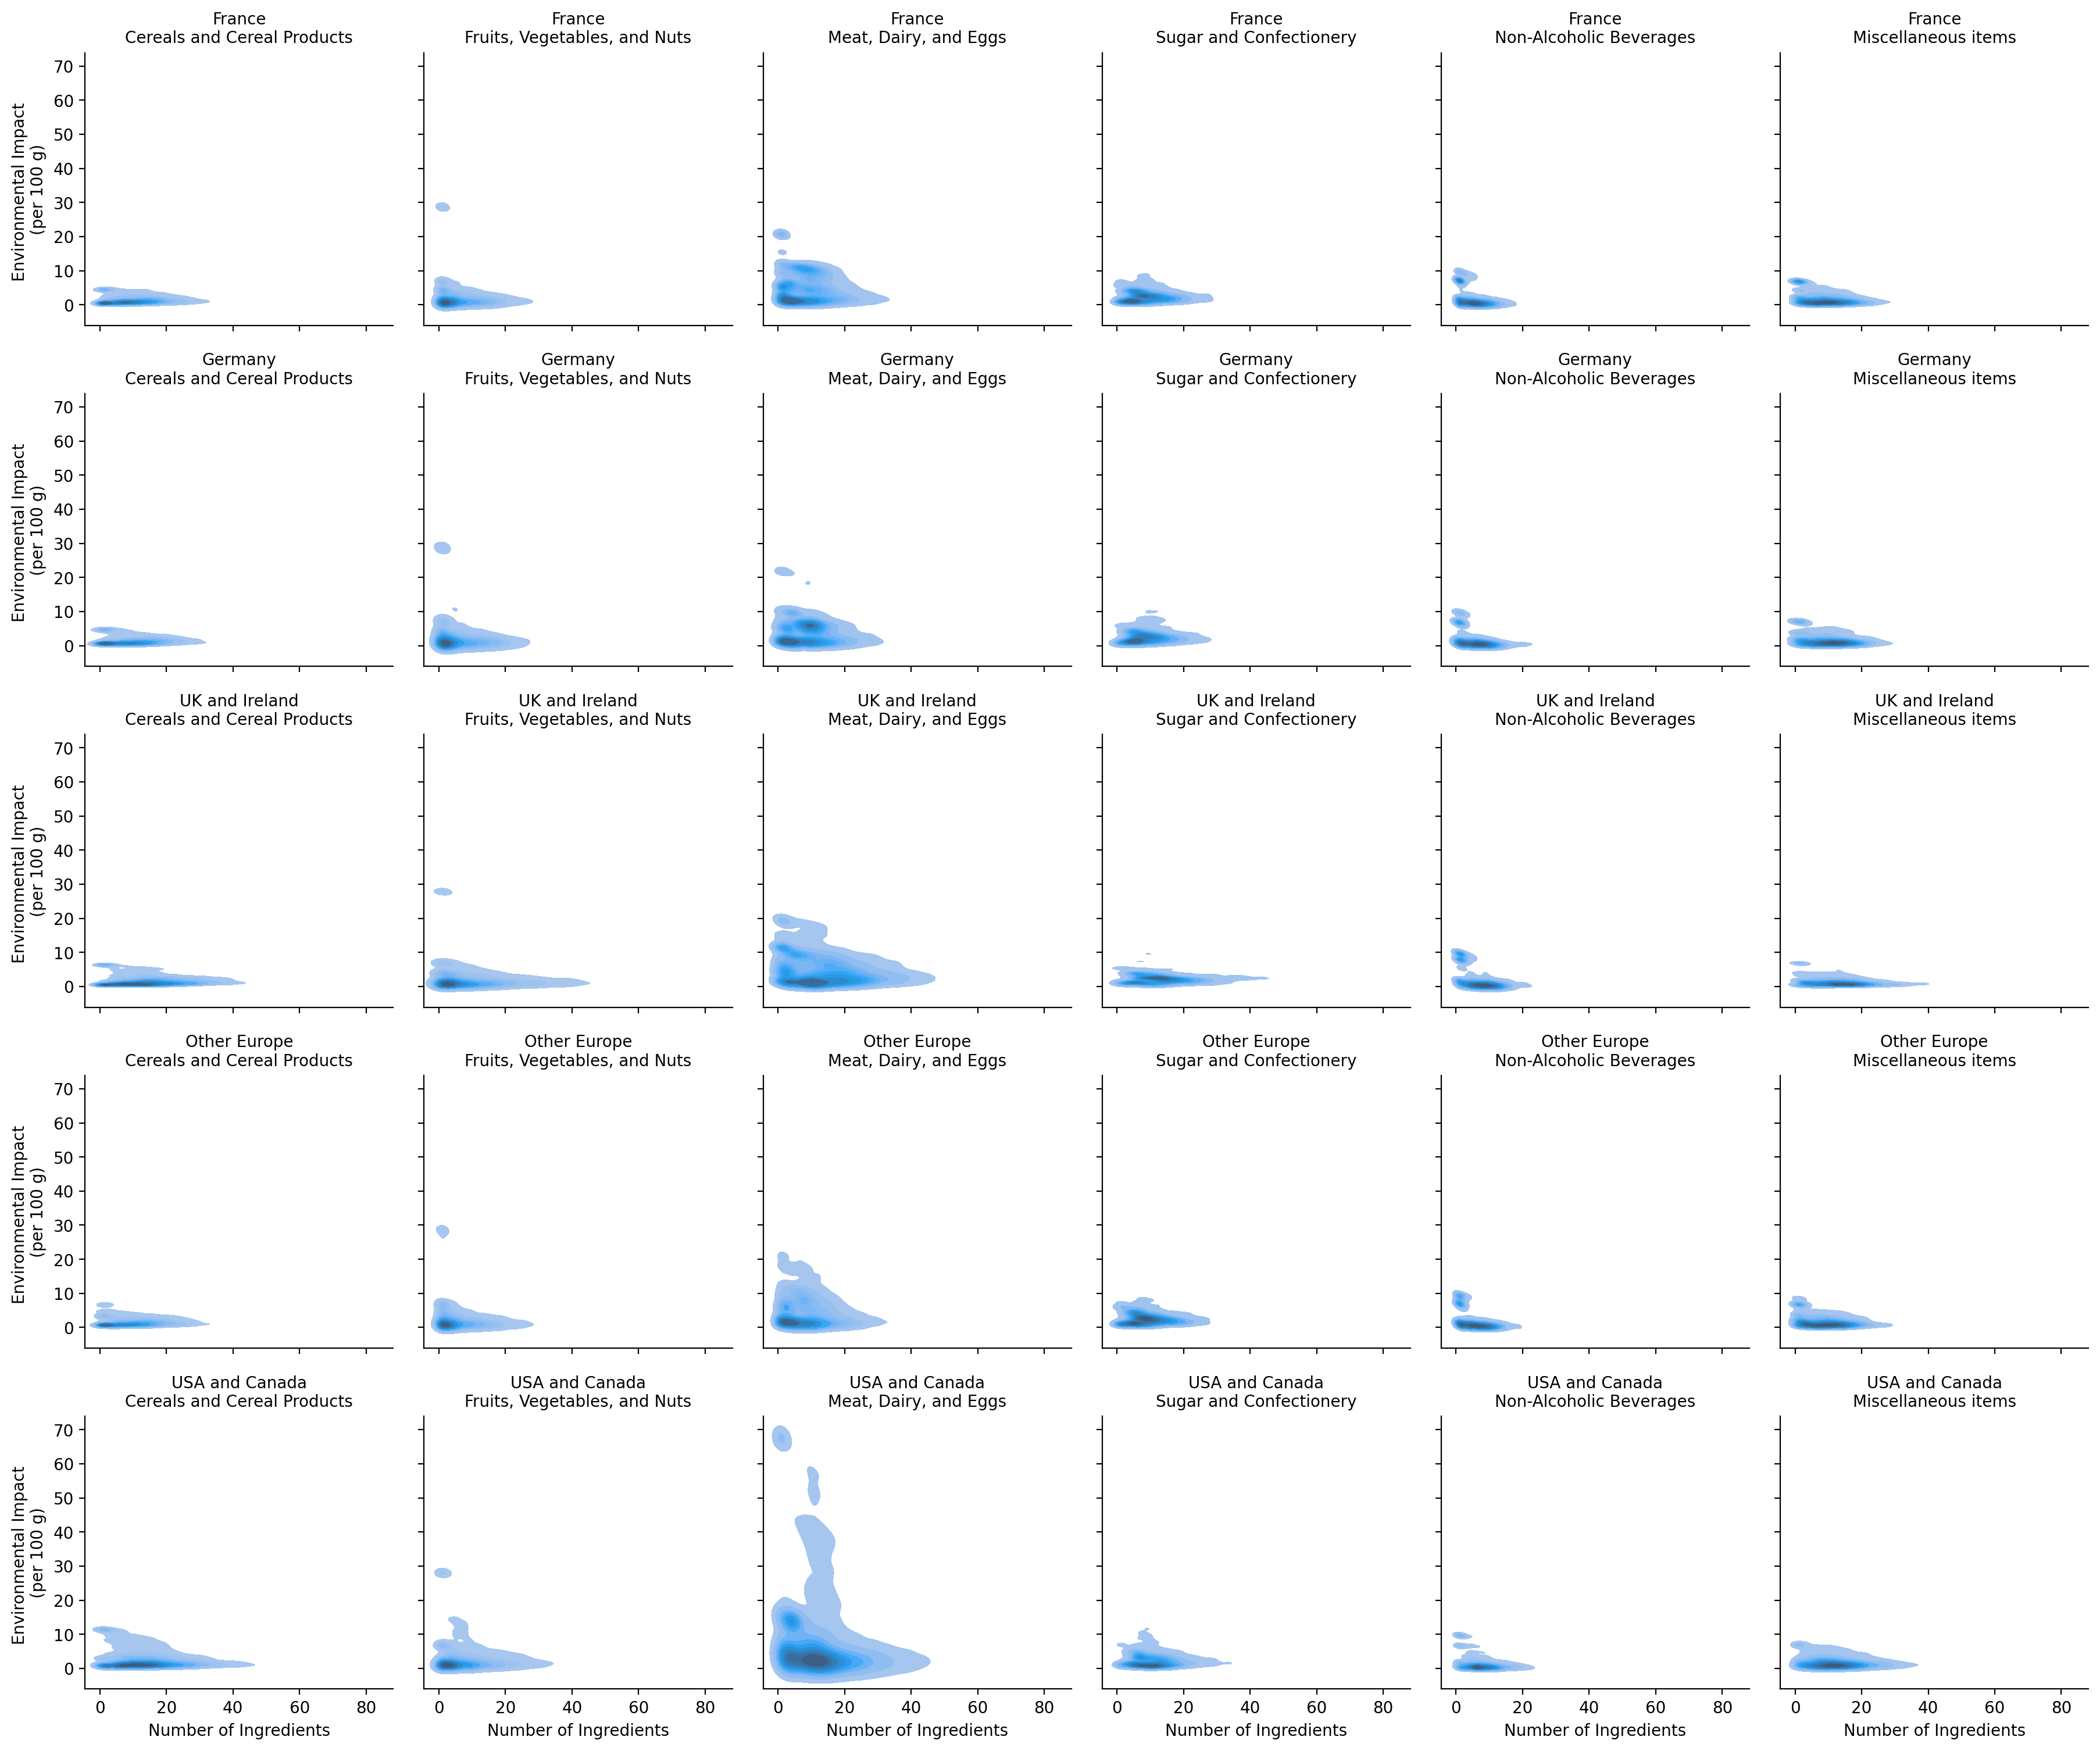

In [83]:
g = sns.FacetGrid(data=df_plot, 
                  col="groups", row='country',  
                  row_order=['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada'],
                  col_order=['Cereals and Cereal Products', 'Fruits, Vegetables, and Nuts',
                             'Meat, Dairy, and Eggs', 'Sugar and Confectionery', 
                             'Non-Alcoholic Beverages', 'Miscellaneous items'],
                  height=3)
g.map(sns.kdeplot, 'value', 'mean_norm_agg', fill=True)

g.set_axis_labels("Number of Ingredients", "Environmental Impact \n(per 100 g)")
g.set_titles("{row_name}\n{col_name}")
g.fig.subplots_adjust(hspace=0.25, wspace=0.1)
    
plt.show()

#### ingredient/composition differences

In [84]:
df_list = []
for fname in glob.glob(os.path.join('../../SFS/environmental_impacts/Managed_Data', "Impact_Proportions_By_Product_*.csv")):
    df = pd.read_csv(fname)
    df_list.append(df)

props = pd.concat(df_list, axis=0, ignore_index=True)

In [85]:
props[['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut', 
       #'tmp.impact_Acidification','tmp.impact_WaterUse',
      'tmp.impact_WatScar', 'tmp.impact_Biodiversity']] = props[[
    'tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut', 
    #'tmp.impact_Acidification', 'tmp.impact_WaterUse',
    'tmp.impact_WatScar', 'tmp.impact_Biodiversity']].fillna(0)

In [86]:
props = props.merge(impacts[['product_id', 'country', 'mean_Land', 'mean_GHG', 'mean_Eut',
                             'mean_WatScar', 'mean_Biodiversity',
                             'mean_Acidification', 'mean_WaterUse']], left_on='id', right_on='product_id')

In [87]:
props['tmp.impact_Land'] = (props['tmp.impact_Land']/props['amount']) * props['mean_Land']
props['tmp.impact_GHG'] = (props['tmp.impact_GHG']/props['amount']) * props['mean_GHG']
props['tmp.impact_Eut'] = (props['tmp.impact_Eut']/props['amount']) * props['mean_Eut']
props['tmp.impact_WatScar'] = (props['tmp.impact_WatScar']/props['amount']) * props['mean_WatScar'] 
props['tmp.impact_Biodiversity'] = (props['tmp.impact_Biodiversity']/props['amount']) * props['mean_Biodiversity'] 
# props['tmp.impact_Acidification'] = (props['tmp.impact_Acidification']/props['amount']) * props['mean_Acidification'] 
# props['tmp.impact_WaterUse'] = (props['tmp.impact_WaterUse']/props['amount']) * props['mean_WaterUse'] 

In [88]:
# d = props
# for col in ['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Biodiversity', 'tmp.impact_Eut', 'tmp.impact_WatScar']:
#     d[col] = 100 * (d[col] - d[col].min()) / (d[col].max() - d[col].min())
# d.groupby('Food_Category')[['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Biodiversity', 
#        'tmp.impact_Eut', 'tmp.impact_WatScar']].mean()

In [89]:
props[['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Biodiversity', 
       'tmp.impact_Eut', 'tmp.impact_WatScar']].corr()

tmp.impact_Land  tmp.impact_GHG  \
tmp.impact_Land                 1.000000        0.541578   
tmp.impact_GHG                  0.541578        1.000000   
tmp.impact_Biodiversity         0.739921        0.528696   
tmp.impact_Eut                  0.733752        0.455858   
tmp.impact_WatScar              0.161155        0.252573   

                         tmp.impact_Biodiversity  tmp.impact_Eut  \
tmp.impact_Land                         0.739921        0.733752   
tmp.impact_GHG                          0.528696        0.455858   
tmp.impact_Biodiversity                 1.000000        0.578202   
tmp.impact_Eut                          0.578202        1.000000   
tmp.impact_WatScar                      0.093820        0.158118   

                         tmp.impact_WatScar  
tmp.impact_Land                    0.161155  
tmp.impact_GHG                     0.252573  
tmp.impact_Biodiversity            0.093820  
tmp.impact_Eut                     0.158118  
tmp.impact_WatScar                 1.000000

In [90]:
# props.groupby('Food_Category')[['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Biodiversity', 
#        'tmp.impact_Eut', 'tmp.impact_WatScar']].corr()

In [91]:
impact_groups = props
for col in ['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut',
            #  'tmp.impact_Acidification', 'tmp.impact_WaterUse',
            'tmp.impact_WatScar', 'tmp.impact_Biodiversity']:
    impact_groups[col] = 100 * (impact_groups[col] - impact_groups[col].min()) / (impact_groups[col].max() - impact_groups[col].min())

impact_groups['impact'] = impact_groups[['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut',
                         #  'tmp.impact_Acidification', 'tmp.impact_WaterUse',
                         'tmp.impact_WatScar', 'tmp.impact_Biodiversity']].mean(axis=1) 
impact_groups['impact'] = 100 * (impact_groups['impact'] - impact_groups['impact'].min()) / (impact_groups['impact'].max() - impact_groups['impact'].min())
    
impact_groups = impact_groups.groupby('Food_Category')[[
    'tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut',
    #  'tmp.impact_Acidification', 'tmp.impact_WaterUse',
    'tmp.impact_WatScar', 'tmp.impact_Biodiversity', 'impact'
]].mean().reset_index()

In [92]:
impact_groups

Food_Category  tmp.impact_Land  tmp.impact_GHG  tmp.impact_Eut  \
0                Almond milk         0.041188        3.416310        0.046809   
1                Animal Fats         2.287518        7.927287        1.474376   
2                     Apples         0.067675        2.814050        0.019366   
3                    Bananas         0.662965        3.024124        0.180542   
4              Barley (Beer)         0.081912        3.107848        0.073972   
5                 Beet Sugar         0.183450        3.374983        0.113577   
6           Berries & Grapes         0.208190        5.638826        0.155043   
7    Bovine Meat (beef herd)        16.970969       25.844716        3.580038   
8   Bovine Meat (dairy herd)        14.472793       20.324940       24.160907   
9                  Brassicas         0.091106        2.957855        0.090735   
10      Butter, Cream & Ghee         0.285292        3.863327        0.258789   
11                Cane Sugar         0.257858        3.536803        0.321685   
12                   Cassava         0.112286        2.781006        0.017906   
13  Cereals & Oilcrops Misc.         0.336586        3.166862        0.124925   
14                    Cheese         2.586723       11.644539        2.214098   
15              Citrus Fruit         0.060720        2.850037        0.045787   
16                    Coffee         1.577240        9.300772        1.850043   
17               Crustaceans         0.305508       12.801333        3.867115   
18            Dark Chocolate         6.925255        4.625136        1.236743   
19                      Eggs         0.697659        4.413343        0.487786   
20                      Fish         0.945115        8.499283        2.227713   
21                Groundnuts         1.018983        4.047193        0.251026   
22             Lamb & Mutton         5.415533       16.124389        0.655049   
23              Maize (Meal)         0.211583        3.049152        0.101889   
24                      Milk         0.290719        3.867061        0.260880   
25            Milk Chocolate         9.185807        1.913193        0.082181   
26                      Nuts         1.454190        3.513019        0.695945   
27                  Oat milk         0.055631        2.909989        0.051030   
28                   Oatmeal         0.518711        3.351022        0.319706   
29                 Olive Oil         2.772442        4.806538        0.932292   
30                    Olives         0.545905        3.042224        0.131911   
31            Onions & Leeks         0.039082        2.826106        0.064110   
32               Other Fruit         0.117398        3.025048        0.341586   
33              Other Pulses         0.821051        3.163790        0.255517   
34          Other Vegetables         0.131451        3.067970        0.068364   
35            Other nut milk         0.069908        4.664235        0.059319   
36                  Palm Oil         0.272136        5.639642        0.341125   
37                      Peas         0.655199        3.102207        0.268634   
38                  Pig Meat         2.593573        7.854674        1.472633   
39                  Potatoes         0.076003        2.805023        0.051343   
40              Poultry Meat         1.396575        7.410079        1.090292   
41              Rapeseed Oil         1.077521        4.075789        0.455976   
42                      Rice         0.344444        4.291524        0.629391   
43                 Rice milk         0.046937        3.149209        0.107225   
44           Root Vegetables         0.215114        3.109638        0.190661   
45                      Salt         0.000000        2.647982        0.000000   
46               Soybean Oil         1.078361        5.222132        0.363163   
47                   Soymilk         0.082008        3.020476        0.050840   
48             Sunflower Oil         1.778050 

In [93]:
impact_groups['impact_groups'] = pd.qcut(impact_groups.impact, 5, labels=[1, 2, 3, 4, 5])

In [94]:
impact_groups.sort_values(by='impact')[['Food_Category', 'impact', 'impact_groups']]

Food_Category     impact impact_groups
53                     Water   0.000000             1
45                      Salt   0.000000             1
12                   Cassava   0.142401             1
31            Onions & Leeks   0.158479             1
27                  Oat milk   0.208777             1
2                     Apples   0.220502             1
39                  Potatoes   0.226497             1
47                   Soymilk   0.243097             1
4              Barley (Beer)   0.302092             1
44           Root Vegetables   0.395235             1
52                  Tomatoes   0.401758             1
23              Maize (Meal)   0.481987             1
5                 Beet Sugar   0.543176             2
54       Wheat & Rye (Bread)   0.544963             2
43                 Rice milk   0.577900             2
9                  Brassicas   0.583959             2
13  Cereals & Oilcrops Misc.   0.608293             2
15              Citrus Fruit   0.619090             2
33              Other Pulses   0.764586             2
55                      Wine   0.786604             2
51                      Tofu   0.819492             2
11                Cane Sugar   0.872765             2
32               Other Fruit   1.027355             2
37                      Peas   1.027975             3
10      Butter, Cream & Ghee   1.175628             3
24                      Milk   1.188685             3
3                    Bananas   1.206503             3
28                   Oatmeal   1.214930             3
30                    Olives   1.312349             3
41              Rapeseed Oil   1.492742             3
49           Sunflower seeds   1.587691             3
35            Other nut milk   1.651755             3
6           Berries & Grapes   1.715370             3
21                Groundnuts   1.992964             3
34          Other Vegetables   2.185668             4
36                  Palm Oil   2.186158             4
46               Soybean Oil   2.203010             4
19                      Eggs   2.371382             4
48             Sunflower Oil   2.774262             4
0                Almond milk   4.198376             4
42                      Rice   4.546477             4
20                      Fish   4.757178             4
25            Milk Chocolate   4.764746             4
40              Poultry Meat   5.070635             4
29                 Olive Oil   5.623116             4
18            Dark Chocolate   6.478201             5
16                    Coffee   6.710706             5
1                Animal Fats   6.930225             5
38                  Pig Meat   7.239229             5
17               Crustaceans   8.887996             5
26                      Nuts   9.342243             5
22             Lamb & Mutton   9.480413             5
14                    Cheese   9.549474             5
50                       Tea   9.959306             5
7    Bovine Meat (beef herd)  20.494848             5
8   Bovine Meat (dairy herd)  31.731157             5

In [95]:
df_plot = impacts[['country', 'groups', 'labels', 'ID', 'product_id', 'mean_norm_agg']]
df_plot = df_plot.merge(country_groups[['Country', 'Intermediate Region Name', 'Sub-region Name', 'Region Name']], left_on='country',
                        right_on='Country').drop('Country', axis=1)
df_plot.loc[df_plot['country'].isin(['United Kingdom', 'Ireland']), 'country'] = 'UK and Ireland'
df_plot.loc[df_plot['country'].isin(['United States', 'Canada']), 'country'] = 'USA and Canada'

df_plot.loc[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada']), 'country'] = df_plot[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada'])]['Region Name']

df_plot.loc[df_plot['country'].isin(['Americas']), 'country'] = 'Latin America'
df_plot.loc[df_plot['country'].isin(['Europe']), 'country'] = 'Other Europe'

# remove asia, africa, latam, oceania
df_plot = df_plot[~df_plot['country'].isin(['Africa', 'Asia', 'Latin America', 'Oceania'])]

In [96]:
composition_sub = composition.drop('country', axis=1).merge(df_plot[['product_id', 'groups', 'labels', 'ID', 'country', 'mean_norm_agg']], 
                                    left_on='id', right_on='product_id')

# to account for almond, rice, oat, other nut milks
df_list = []
for food_cat in ['Almond milk','Oat milk', 'Other nut milk', 'Rice milk']:  
    alt_ids = props[props['Food_Category']==food_cat]['id'].unique()
    df = composition_sub[composition_sub['id'].isin(alt_ids)].groupby('id').first().reset_index()
    composition_sub = composition_sub[~composition_sub['id'].isin(alt_ids)]
    df['Food_Category'] = food_cat
    df['percent'] = 100
    df_list.append(df)
df_list.append(composition_sub)
composition_sub = pd.concat(df_list, axis=0, ignore_index=True)

composition_sub = composition_sub.groupby(['country', 'groups', 'labels', 
                                           'ID', 'Food_Category'])[['percent']].sum().reset_index()

def get_perc(g):
    g['percent'] = (g['percent'] / g['percent'].sum()) * 100
    return g

composition_sub = composition_sub.groupby(['country', 'ID']).apply(lambda g: get_perc(g)).reset_index(drop=True)

composition_sub.loc[composition_sub['Food_Category']=='Fish (farmed)', 'Food_Category'] = 'Fish'
composition_sub.loc[composition_sub['Food_Category']=='Crustaceans (farmed)', 'Food_Category'] = 'Crustaceans'
composition_sub = composition_sub.merge(impact_groups[['Food_Category', 'impact_groups']], how='left')
composition_sub.loc[composition_sub['impact_groups'].isna(), 'impact_groups'] = 1

composition_sub = composition_sub.groupby(['country', 'ID', 'impact_groups'])[['percent']].sum().reset_index()
composition_sub = composition_sub.merge(df_mapping)

/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_60799/2789645023.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  composition_sub = composition_sub.groupby(['country', 'ID']).apply(lambda g: get_perc(g)).reset_index(drop=True)
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_60799/2789645023.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  composition_sub = composition_sub.groupby(['country', 'ID', 'impact_groups'])[['percent']].sum().reset_index()


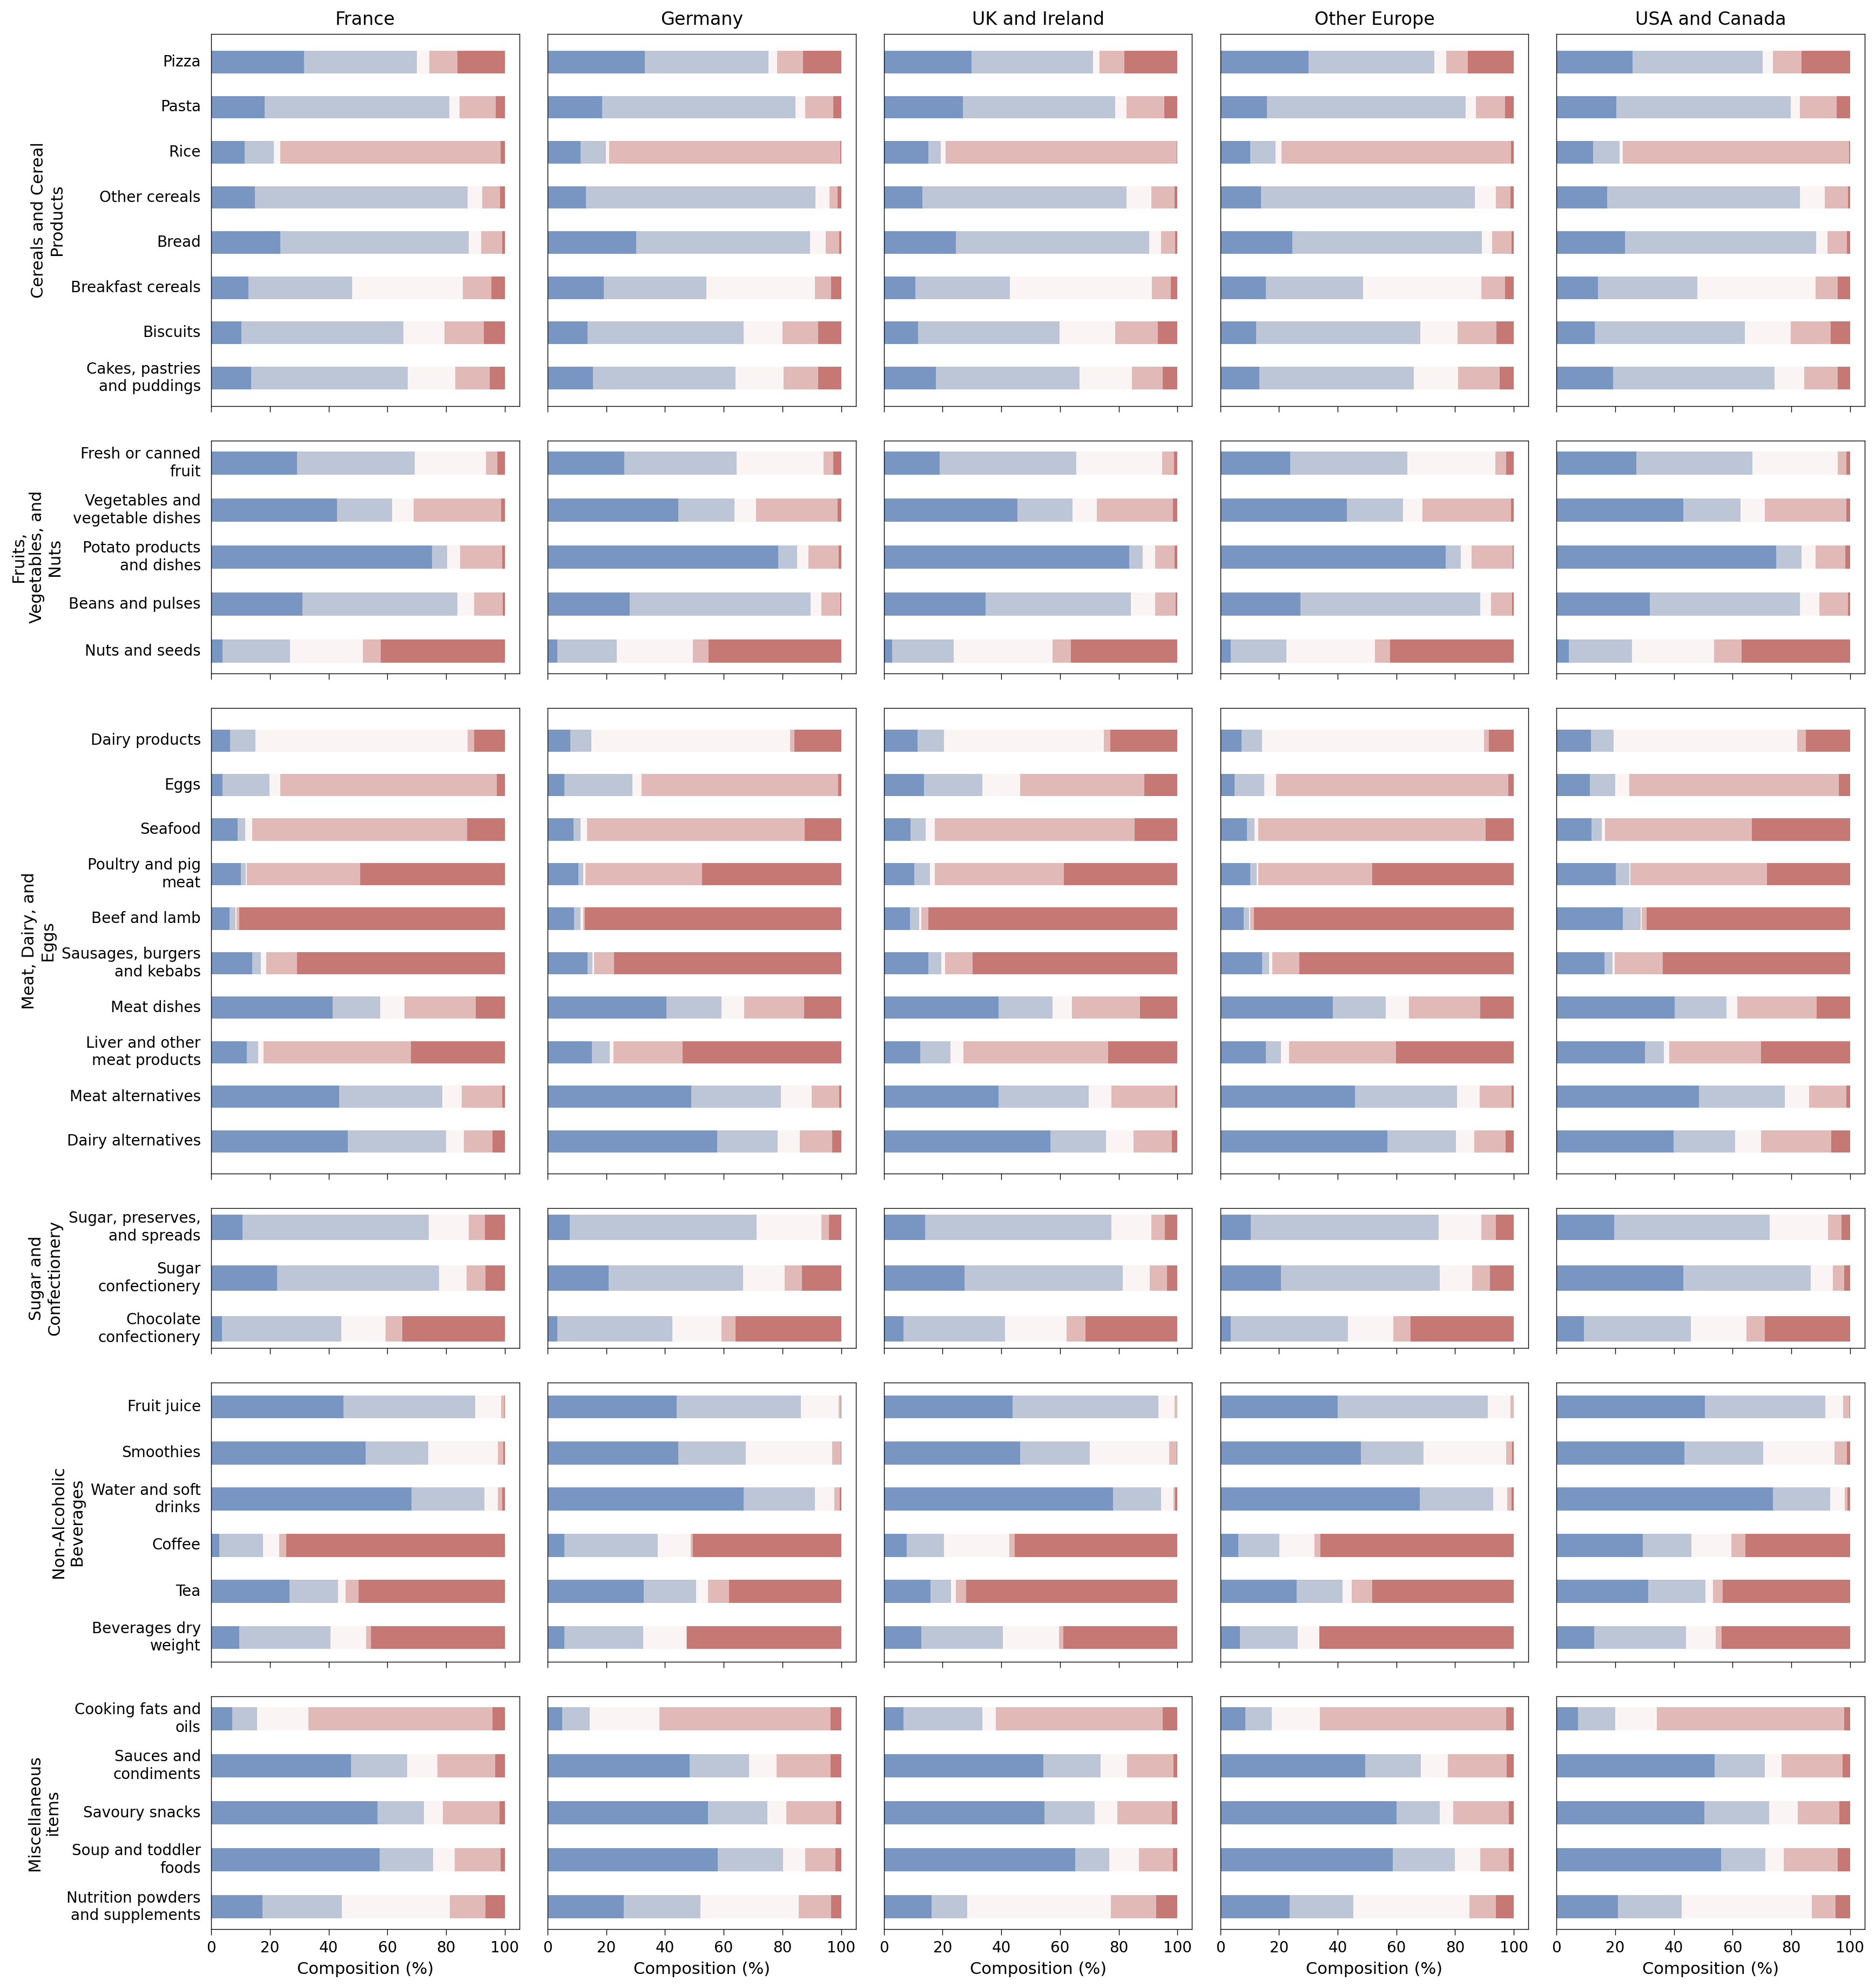

In [97]:
def wrap_tick_labels(ax, width=10):
    labels = ax.get_yticklabels()
    ticks = ax.get_yticks()  
    ax.set_yticks(ticks)
    wrapped_labels = []
    for lbl in labels:
        # textwrap.fill wraps the string to the given width
        wrapped_labels.append(textwrap.fill(lbl.get_text(), width=width, break_long_words=False))
    ax.set_yticklabels(wrapped_labels)

groups_list = ['Cereals and Cereal Products', 'Fruits, Vegetables, and Nuts',
               'Meat, Dairy, and Eggs', 'Sugar and Confectionery', 
               'Non-Alcoholic Beverages', 'Miscellaneous items']
countries_list = ['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada']


facet_counts = {}
for group in groups_list:
    for country in countries_list:
        data_sub = composition_sub[(composition_sub['groups'] == group) & (composition_sub['country'] == country)]
        count = data_sub['labels'].nunique() if not data_sub.empty else 0
        facet_counts[(group, country)] = count
        
inch_per_label = 0.5  
row_heights = []
for group in groups_list:
    max_count = max(facet_counts[(group, country)] for country in countries_list)
    row_heights.append(max_count * inch_per_label)

fig_width = len(countries_list) * 3.5  
fig_height = sum(row_heights)

fig = plt.figure(figsize=(fig_width, fig_height))
gs = GridSpec(nrows=len(groups_list), ncols=len(countries_list),
                       height_ratios=row_heights)

def plot_stacked_barh(ax, data):
    pivot = data.pivot(index=['ID', "labels"], columns="impact_groups", values="percent").reset_index()
    pivot = pivot.fillna(0)
    pivot = pivot.sort_values('ID', ascending=False)

    labels = pivot['labels'].tolist()
    n = len(labels)
    positions = np.arange(n)

    bar_height = 0.5
    pivot = pivot.drop('ID', axis=1).set_index('labels')
    impact_groups = sorted(pivot.columns)

    # Define a color palette (consistent across facets)
    palette = sns.color_palette("vlag", n_colors=len(impact_groups))
    color_map = dict(zip(impact_groups, palette))

    # Plot each segment of the stacked bar.
    left = np.zeros(n)  # starting offset for each bar
    for group in impact_groups:
        ax.barh(y=positions,
                width=pivot[group].values,
                left=left,
                height=bar_height,
                label=group,
                color=color_map[group])
        left += pivot[group].values  # update the offset

    # Set y-ticks and labels
    ax.set_yticks(positions)
    ax.set_yticklabels(labels)
    
    # Remove gridlines and spines for a cleaner look
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
        
legend_handles = None

for i, group in enumerate(groups_list):
    for j, country in enumerate(countries_list):
        ax = fig.add_subplot(gs[i, j])
        
        # Filter data for this facet.
        data_sub = composition_sub[(composition_sub['groups'] == group) & (composition_sub['country'] == country)]
        if not data_sub.empty:
            plot_stacked_barh(ax, data_sub)
        else:
            ax.set_visible(False)

        wrap_tick_labels(ax, width=18)
        for label in ax.get_yticklabels():
            label.set_horizontalalignment('right')
            label.set_verticalalignment('center')  
            label.set_rotation_mode('anchor')
        
        ax.tick_params(axis='x', which='major', bottom=True, top=False, length=4, width=0.5)
        ax.tick_params(axis='y', which='major', left=False, right=False)
        if i == 0:
            ax.set_title(country, fontsize=12)
        if i!=len(groups_list)-1:
            ax.set_xticklabels("") 
        if i==len(groups_list)-1:
            ax.set_xlabel("Composition (%)", fontsize=11)
        if j == 0:
            ax.set_ylabel(textwrap.fill(group, 18, break_long_words=False), fontsize=11)
        else:
            ax.set_ylabel("")
            ax.set_yticklabels("")
            
        if legend_handles is None and not data_sub.empty:
            handles, labels = ax.get_legend_handles_labels()
            legend_handles = (handles, labels)
            
# Adjust layout
plt.tight_layout(h_pad=1.8, w_pad=1.4, 
                 # rect=[0, 0.05, 1, 1]
                )
plt.show()

In [98]:
composition_sub = composition.drop('country', axis=1).merge(df_plot[['product_id', 'groups', 'labels', 'ID', 'country', 'mean_norm_agg']], 
                                    left_on='id', right_on='product_id')

# to account for almond, rice, oat, other nut milks
df_list = []
for food_cat in ['Almond milk','Oat milk', 'Other nut milk', 'Rice milk']:  
    alt_ids = props[props['Food_Category']==food_cat]['id'].unique()
    df = composition_sub[composition_sub['id'].isin(alt_ids)].groupby('id').first().reset_index()
    composition_sub = composition_sub[~composition_sub['id'].isin(alt_ids)]
    df['Food_Category'] = food_cat
    df['percent'] = 100
    df_list.append(df)
df_list.append(composition_sub)
composition_sub = pd.concat(df_list, axis=0, ignore_index=True)

composition_sub = composition_sub.groupby(['country', 'Food_Category'])[['percent']].sum().reset_index()

def get_perc(g):
    g['percent'] = (g['percent'] / g['percent'].sum()) * 100
    return g

composition_sub = composition_sub.groupby(['country']).apply(lambda g: get_perc(g)).reset_index(drop=True)

composition_sub.loc[composition_sub['Food_Category']=='Fish (farmed)', 'Food_Category'] = 'Fish'
composition_sub.loc[composition_sub['Food_Category']=='Crustaceans (farmed)', 'Food_Category'] = 'Crustaceans'
composition_sub = composition_sub.merge(impact_groups[['Food_Category', 'impact_groups']], how='left')
composition_sub.loc[composition_sub['impact_groups'].isna(), 'impact_groups'] = 1

composition_sub = composition_sub.groupby(['country', 'impact_groups'])[['percent']].sum().reset_index()

/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_60799/3012923415.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  composition_sub = composition_sub.groupby(['country']).apply(lambda g: get_perc(g)).reset_index(drop=True)
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_60799/3012923415.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  composition_sub = composition_sub.groupby(['country', 'impact_groups'])[['percent']].sum().reset_index()


In [99]:
composition_sub

country impact_groups    percent
0           France             1  23.844978
1           France             2  29.002437
2           France             3  14.849244
3           France             4  17.134106
4           France             5  15.169235
5          Germany             1  26.391213
6          Germany             2  29.173223
7          Germany             3  16.349462
8          Germany             4  13.550216
9          Germany             5  14.535886
10    Other Europe             1  24.814037
11    Other Europe             2  30.525267
12    Other Europe             3  17.209177
13    Other Europe             4  15.154287
14    Other Europe             5  12.297232
15  UK and Ireland             1  28.352901
16  UK and Ireland             2  26.838541
17  UK and Ireland             3  15.130892
18  UK and Ireland             4  15.785606
19  UK and Ireland             5  13.892060
20  USA and Canada             1  30.309422
21  USA and Canada             2  29.312326
22  USA and Canada             3  15.005661
23  USA and Canada             4  14.368315
24  USA and Canada             5  11.004275

#### importance of sourcing - also what does impacts figure look like without incorporating sourcing?

In [100]:
sourcing_diff = props

In [101]:
for col in ['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut',
            #  'tmp.impact_Acidification', 'tmp.impact_WaterUse',
            'tmp.impact_WatScar', 'tmp.impact_Biodiversity']:
    sourcing_diff[col] = 100 * (sourcing_diff[col] - sourcing_diff[col].min()) / (sourcing_diff[col].max() - sourcing_diff[col].min())
    
sourcing_diff['impact'] = sourcing_diff[['tmp.impact_Land', 'tmp.impact_GHG', 'tmp.impact_Eut',
                                         #  'tmp.impact_Acidification', 'tmp.impact_WaterUse',
                                         'tmp.impact_WatScar', 'tmp.impact_Biodiversity' 
                                         ]].mean(axis=1) 

sourcing_diff['impact'] = 100 * (sourcing_diff['impact'] - sourcing_diff['impact'].min()) / (sourcing_diff['impact'].max() - sourcing_diff['impact'].min())

df_plot = sourcing_diff.merge(country_groups[['Country', 'Intermediate Region Name', 'Sub-region Name', 'Region Name']], left_on='country',
                        right_on='Country').drop('Country', axis=1)
df_plot.loc[df_plot['country'].isin(['United Kingdom', 'Ireland']), 'country'] = 'UK and Ireland'
df_plot.loc[df_plot['country'].isin(['United States', 'Canada']), 'country'] = 'USA and Canada'

df_plot.loc[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada']), 'country'] = df_plot[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada'])]['Region Name']

df_plot.loc[df_plot['country'].isin(['Americas']), 'country'] = 'Latin America'
df_plot.loc[df_plot['country'].isin(['Europe']), 'country'] = 'Other Europe'

# remove asia, africa, latam, oceania
df_plot = df_plot[~df_plot['country'].isin(['Africa', 'Asia', 'Latin America', 'Oceania'])]

df_plot = df_plot.merge(impact_groups[['Food_Category', 'impact_groups']])

In [102]:
# df_plot.groupby(['country', 'Food_Category'])[['impact']].mean().reset_index().sort_values(by='impact')

In [103]:
# combine salt and water
df_plot.loc[df_plot['Food_Category'].isin(['Water', 'Salt']), 'Food_Category'] = 'Salt & Water'

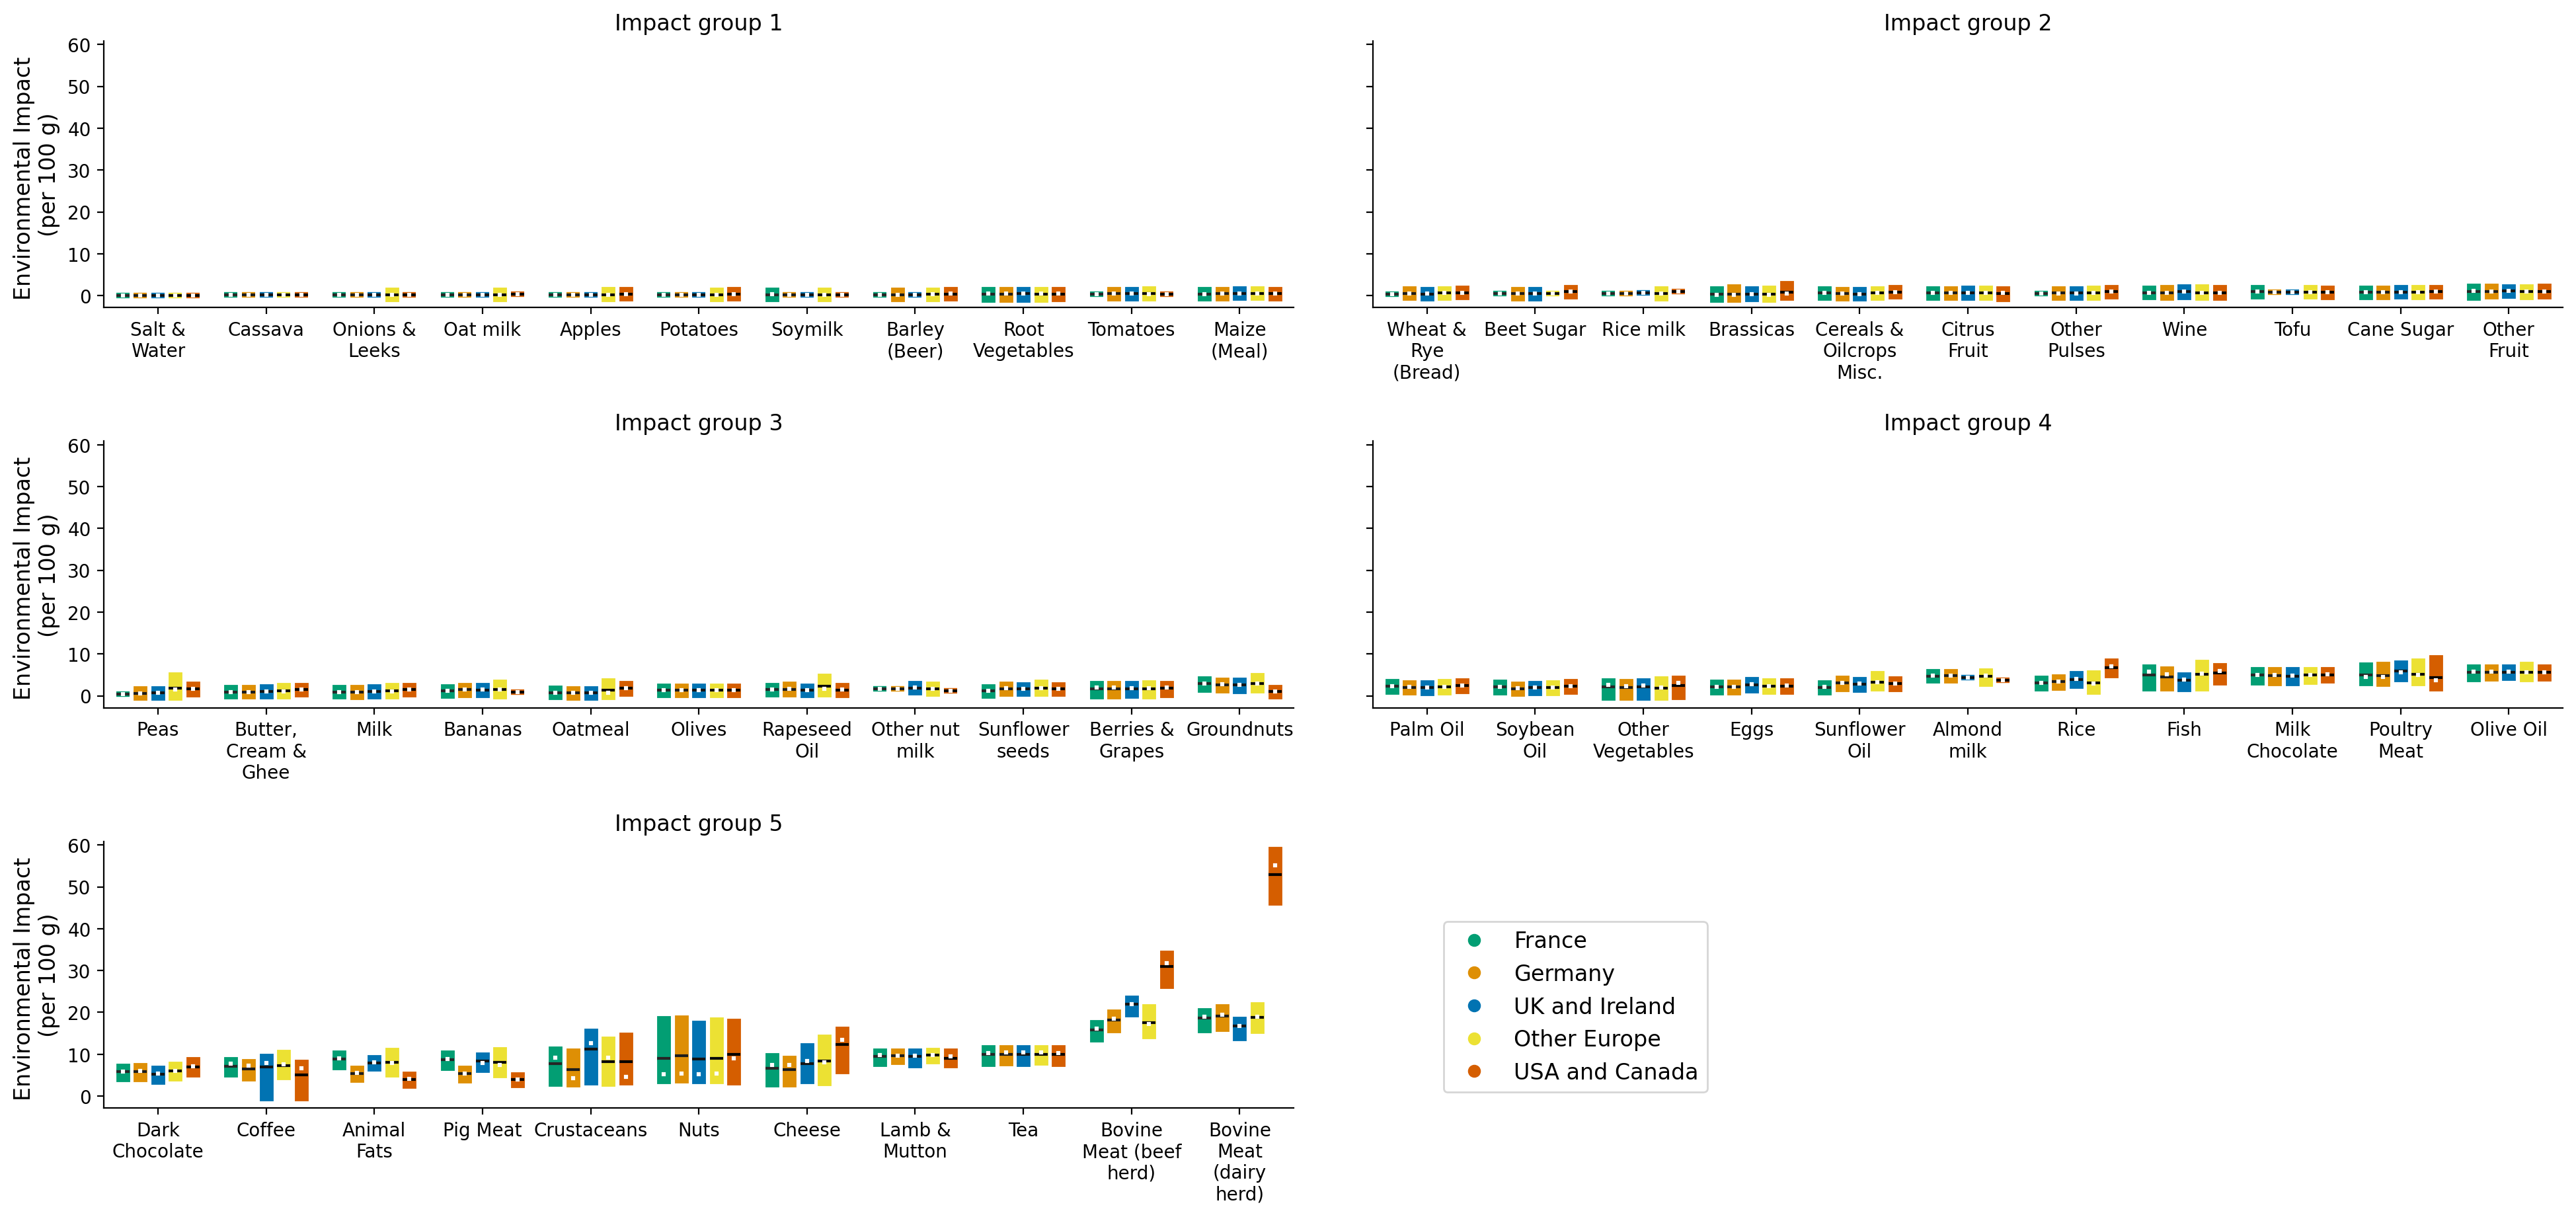

In [104]:
def wrap_tick_labels(ax, width=10):
    labels = ax.get_xticklabels()
    ticks = ax.get_xticks()  
    ax.set_xticks(ticks)
    wrapped_labels = []
    for lbl in labels:
        # textwrap.fill wraps the string to the given width
        wrapped_labels.append(textwrap.fill(lbl.get_text(), width=width, break_long_words=False))
    ax.set_xticklabels(wrapped_labels, rotation=0)
         
dodge = 0.65
countries_order=['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada']
palette = sns.color_palette(["#029e73", "#de8f05", "#0173b2", "#ece133", "#d55e00"])
country_colors = dict(zip(countries_order, palette))

# Initialize the FacetGrid
g = sns.FacetGrid(df_plot, 
                  col='impact_groups',
                  col_wrap=2,
                  sharey=True, sharex=False,
                  height=3, aspect=3.25)

# Define the plotting function
def plot_errorbar(data, color, **kwargs):
    order=data.groupby('Food_Category')[['impact']].mean().reset_index().sort_values(
        by='impact').reset_index(drop=True)['Food_Category'].values.tolist()
    sns.pointplot(
        x='Food_Category', 
        y='impact',
        hue='country',
        hue_order=countries_order,
        data=data,
        order=order,  
        capsize=0,
        errorbar=('pi', 80),
        err_kws={'linewidth': 7.5},
        markers=".",
        markersize=1,
        linestyles='none',
        dodge=dodge,
        palette = palette
    )

    # adding this for some constant impact categories - since its a single point it was not visible - so adding a flat line for means in original colors
    sns.pointplot(
        x='Food_Category', 
        y='impact',
        estimator='mean',
        hue='country',
        hue_order=countries_order,
        data=data,
        order=order,  
        errorbar=None,
        markers="_",
        markersize=7.5,
        markeredgewidth=3,
        linestyles='none',
        dodge=dodge,
        palette=palette,
        legend=False
    )
    
    sns.pointplot(
        x='Food_Category', 
        y='impact',
        estimator='mean',
        hue='country',
        hue_order=countries_order,
        data=data,
        order=order,  
        errorbar=None,
        markers="_",
        markersize=7,
        markeredgewidth=1.5,
        linestyles='none',
        dodge=dodge,
        palette='dark:black',
        legend=False
    )
    
    sns.pointplot(
        x='Food_Category', 
        y='impact',
        estimator='median',
        hue='country',
        hue_order=countries_order,
        data=data,
        order=order,  
        errorbar=None,
        markers="s",
        markersize=1,
        markeredgewidth=1.5,
        linestyles='none',
        dodge=dodge,
        palette=sns.color_palette(["white"] * 5),
        legend=False
    )

# Map the plotting function to each facet
g.map_dataframe(plot_errorbar)

# Add axis labels
g.set_ylabels("Environmental Impact \n(per 100 g)", size=12)
g.set_titles("Impact group {col_name}", size=12)
g.figure.subplots_adjust(hspace=0.5)
        
for ax in g.axes.flatten():
    # Remove the subplot legend
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    # Wrap and rotate x-axis labels
    wrap_tick_labels(ax, width=10)
    # for label in ax.get_yticklabels():
    #     label.set_horizontalalignment('right')
    #     label.set_verticalalignment('center')  
    #     label.set_rotation_mode('anchor')
    # Clear x-axis label text
    ax.set_xlabel("")

g.add_legend(title='', 
             # ncol=5, 
             markerscale=10, fontsize=12,
             bbox_to_anchor=(0.6, 0.15), 
             frameon=True)
 
plt.show()

In [105]:
df_plot = impacts_global[['country', 'groups', 'labels', 'ID', 'product_id', 'mean_norm_agg']]
df_plot = df_plot.merge(country_groups[['Country', 'Intermediate Region Name', 'Sub-region Name', 'Region Name']], left_on='country',
                        right_on='Country').drop('Country', axis=1)
df_plot.loc[df_plot['country'].isin(['United Kingdom', 'Ireland']), 'country'] = 'UK and Ireland'
df_plot.loc[df_plot['country'].isin(['United States', 'Canada']), 'country'] = 'USA and Canada'

df_plot.loc[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada']), 'country'] = df_plot[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada'])]['Region Name']

df_plot.loc[df_plot['country'].isin(['Americas']), 'country'] = 'Latin America'
df_plot.loc[df_plot['country'].isin(['Europe']), 'country'] = 'Other Europe'

# remove category-country combinations when number of products is less than 30 - removes about 100 products
df = df_plot.groupby(['country', 'labels'])[['product_id']].nunique().reset_index()
df_plot = df_plot[~df_plot['product_id'].isin(df_plot.merge(df[df['product_id']<30][['country', 'labels']])['product_id'].unique())]

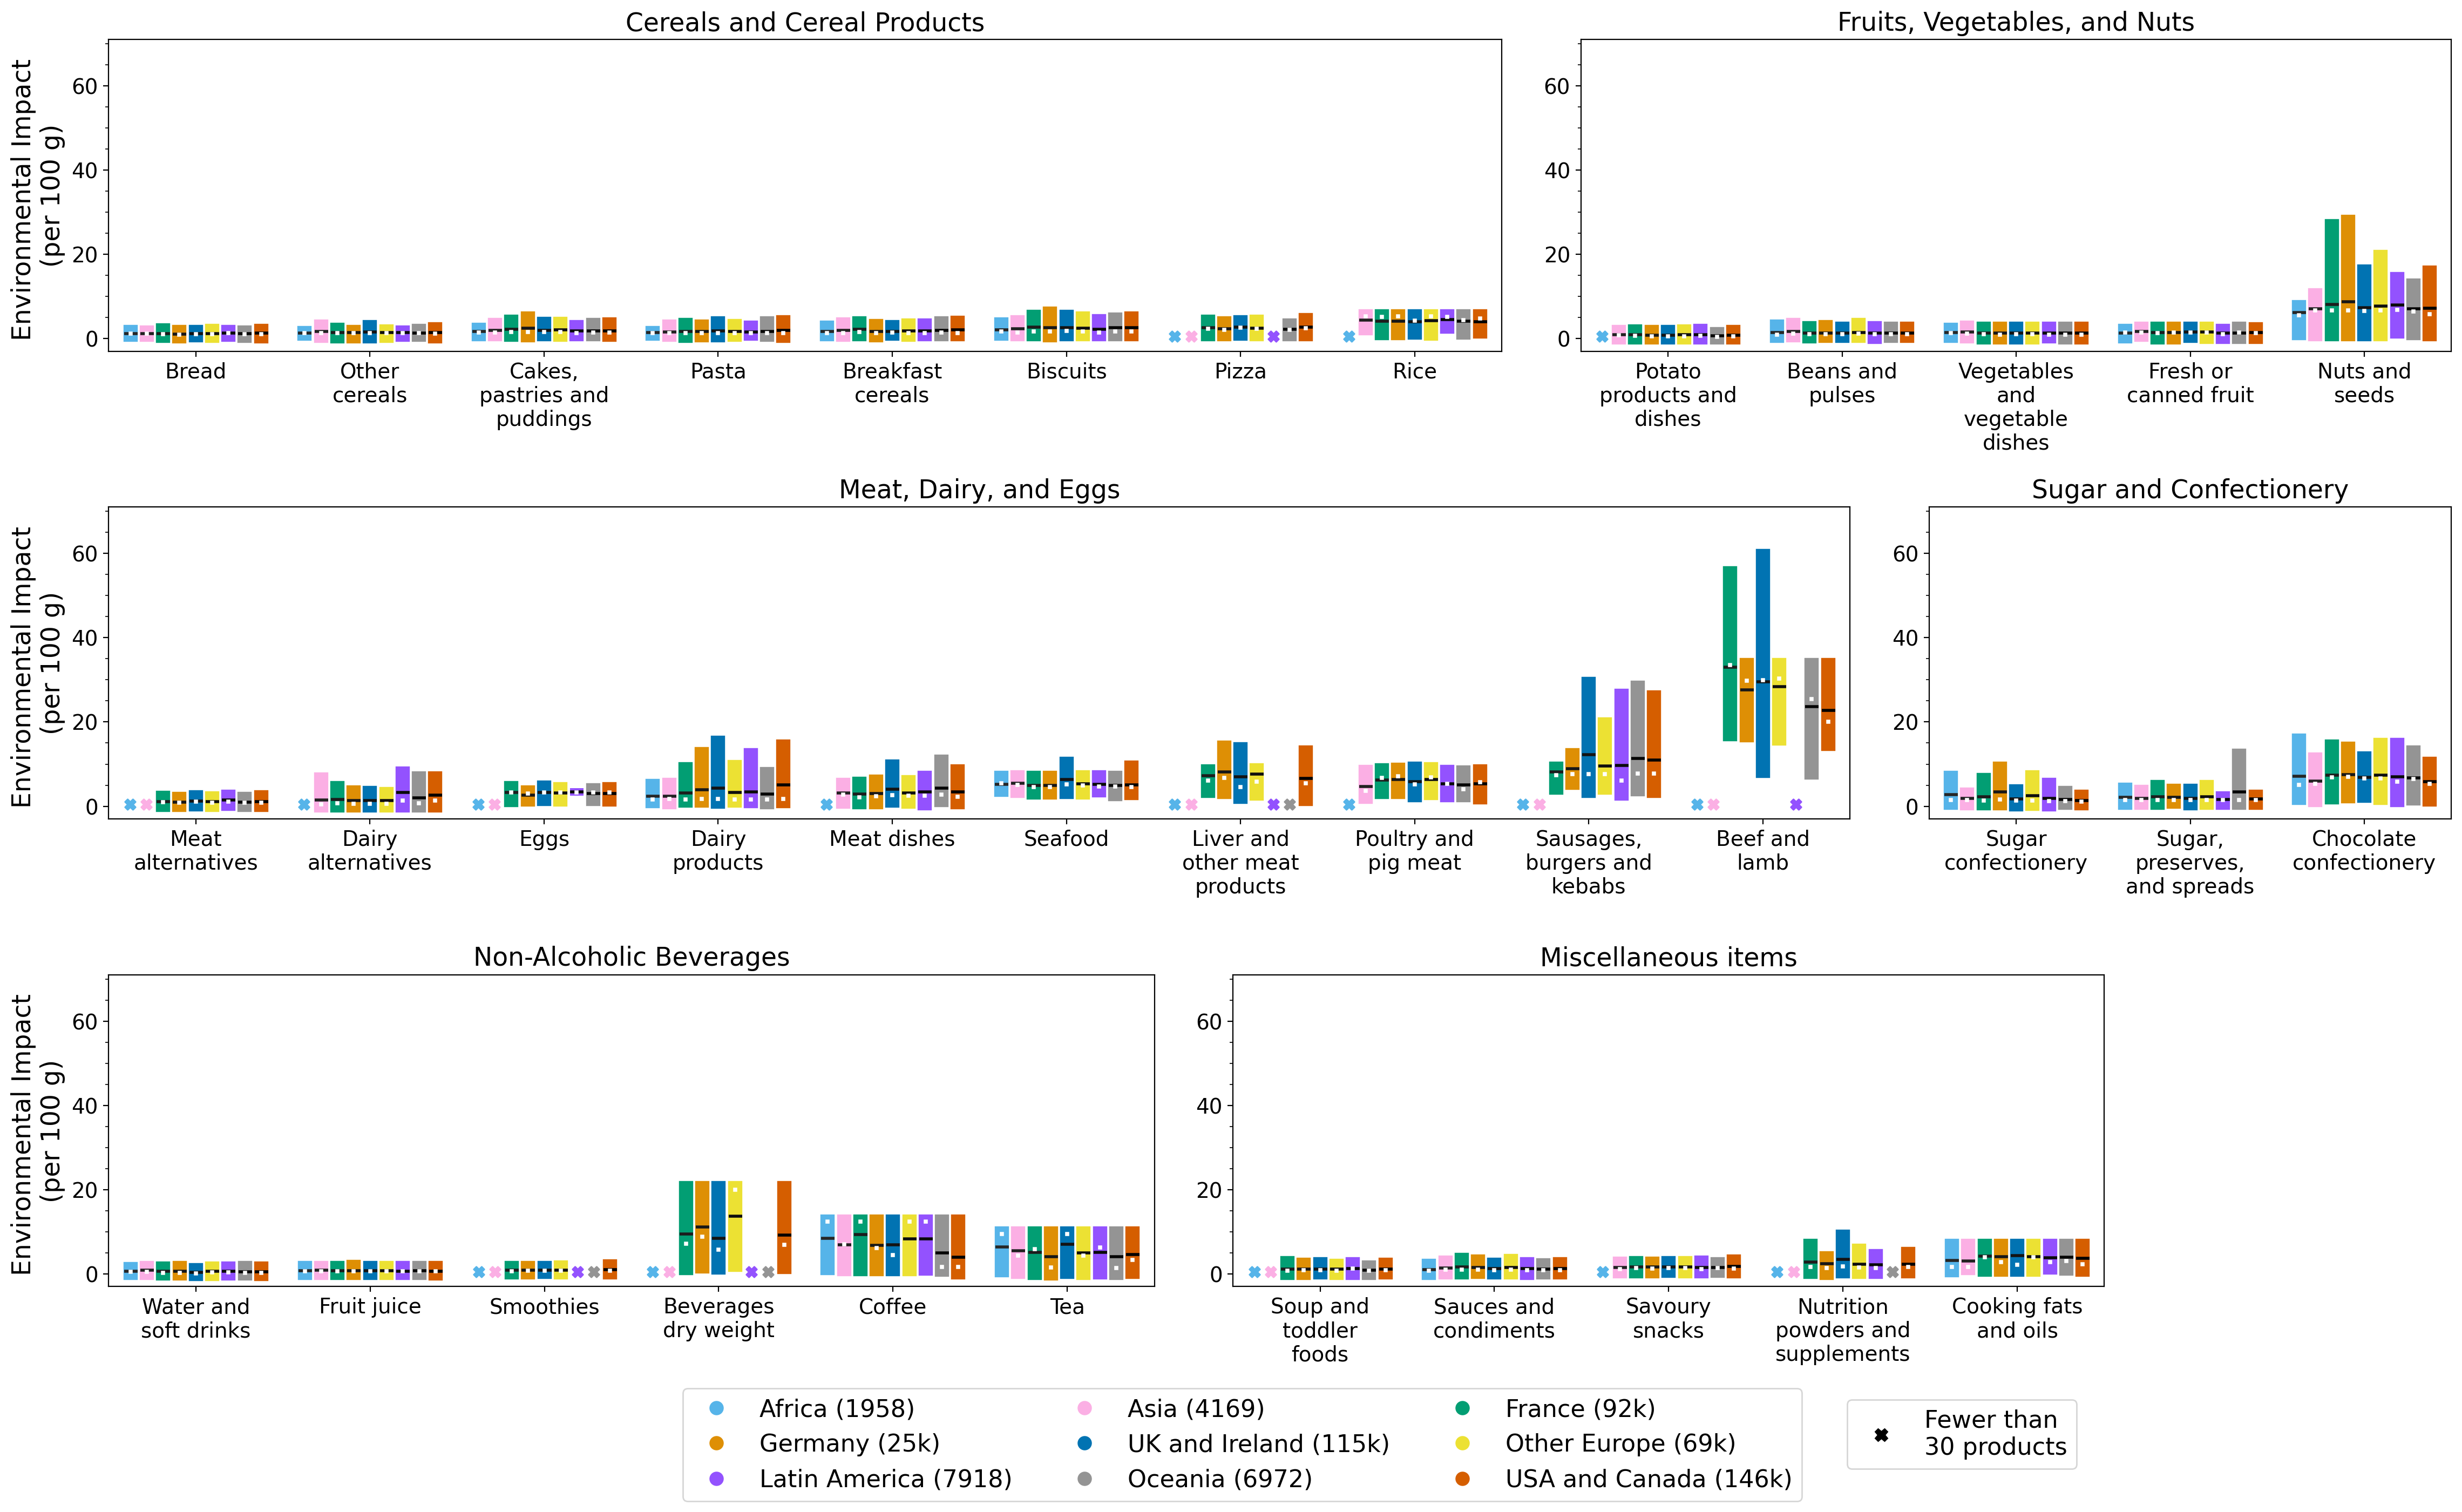

In [106]:
# order
groups = ['Cereals and Cereal Products', 'Fruits, Vegetables, and Nuts',
          'Meat, Dairy, and Eggs', 'Sugar and Confectionery', 
          'Non-Alcoholic Beverages', 'Miscellaneous items']

countries_order = ['Africa', 'Asia', 'France', 'Germany', 'UK and Ireland',
                   'Other Europe', 'Latin America', 'Oceania',
                   'USA and Canada']

# n rows
groups_split = np.array_split(groups, 3)

fig = plt.figure(figsize=(28, 15))

# outer GridSpec with 3 rows
# defining a second column as the last row has fewer categories than the first 2 
outer_gs = GridSpec(
    nrows=3, ncols=2,
    width_ratios=[11.5, 2],  
    height_ratios=[1, 1, 1],
    wspace=0, hspace=0.5
)

master_ax = None

def wrap_tick_labels(ax, width=10):
    labels = ax.get_xticklabels()
    ticks = ax.get_xticks()  
    ax.set_xticks(ticks)
    wrapped_labels = []
    for lbl in labels:
        # textwrap.fill wraps the string to the given width
        wrapped_labels.append(textwrap.fill(lbl.get_text(), width=width, break_long_words=False))
    ax.set_xticklabels(wrapped_labels, rotation=0)

for row_idx, row_groups in enumerate(groups_split):
    
    # For each row, compute width ratios based on the number of labels per group
    width_ratios = []
    for grp in row_groups:
        n_labels = len(order_df[order_df['groups'] == grp]['labels'].unique())
        width_ratios.append(n_labels)
    
    # subgridspec for this row
    if row_idx!=2:
        inner_gs = outer_gs[row_idx, :].subgridspec(
            1, len(row_groups),
            width_ratios=width_ratios,
            wspace=0.07
        )
    else:
        inner_gs = outer_gs[row_idx, 0].subgridspec(
            1, len(row_groups),
            width_ratios=width_ratios,
            wspace=0.082
        )
    
    for col_idx, grp in enumerate(row_groups):
        # If we haven't assigned a master axis yet, do so now.
        if master_ax is None:
            ax = fig.add_subplot(inner_gs[col_idx])
            master_ax = ax
        else:
            # sharey=master_ax ensures all subplots share the same y-scale
            ax = fig.add_subplot(inner_gs[col_idx], 
                                 sharey=master_ax
                                )
        
        # Subset data for this group
        data = df_plot[
            (df_plot['groups'] == grp)
        ]
         
        # Determine the x-label order for this group
        order = order_df[order_df['groups'] == grp]['labels'].values
        dodge = 0.75
        palette = sns.color_palette(["#56b4e9", "#fbafe4", "#029e73", "#de8f05", "#0173b2", "#ece133", 
                                         #"#cc78bc", 
                                         "#9352fe",  "#949494", "#d55e00", #"#d7a377"
                                        ])
        country_colors = dict(zip(countries_order, palette))     
        
        sns.pointplot(
            x='labels',
            y='mean_norm_agg',
            hue='country',
            hue_order=countries_order,
            data=data,
            order=order,  
            capsize=0,
            errorbar=('pi', 80),
            err_kws={'linewidth': 9.5},
            markers=".",
            markersize=5,
            linestyles='none',
            dodge=dodge,
            palette = palette,
            ax=ax
        )

        # adding this for eggs in latin america - since its a single point it was not visible - so adding a flat line for means in original colors
        sns.pointplot(
            x='labels',
            y='mean_norm_agg',
            estimator='mean',
            hue='country',
            hue_order=countries_order,
            data=data,
            order=order,  
            errorbar=None,
            markers="_",
            markersize=9,
            markeredgewidth=5,
            linestyles='none',
            dodge=dodge,
            ax=ax,
            palette=palette,
            legend=False
        )

        sns.pointplot(
            x='labels',
            y='mean_norm_agg',
            estimator='mean',
            hue='country',
            hue_order=countries_order,
            data=data,
            order=order,  
            errorbar=None,
            markers="_",
            markersize=9,
            markeredgewidth=2,
            linestyles='none',
            dodge=dodge,
            ax=ax,
            palette='dark:black',
            legend=False
        )

        sns.pointplot(
            x='labels',
            y='mean_norm_agg',
            estimator='median',
            hue='country',
            hue_order=countries_order,
            data=data,
            order=order,  
            errorbar=None,
            markers="s",
            markersize=1,
            markeredgewidth=2,
            linestyles='none',
            dodge=dodge,
            ax=ax,
            palette=sns.color_palette(["white"] * 9),
            legend=False
        )

        # to ensure same margins irrespective of widths
        ax.set_xlim(-0.5, len(order) - 0.5)
        ax.set_ylim(-3, 71) # to match main figure

        # add symbols for missing bars 
        for i, label_i in enumerate(order):
            for j, country_j in enumerate(countries_order):
                # Check if there is data
                subset = data[(data['labels'] == label_i) & (data['country'] == country_j)]
                if subset.empty:
                    d = dodge + 0.1
                    x_coord = i - d/2 + d/(2*len(countries_order)) + (j * d/len(countries_order))  
                    y_coord = 0.5         
                    ax.scatter(
                        [x_coord], [y_coord],
                        color=country_colors[country_j],
                        marker="X",
                        s=50
                    )
        
        # Remove the subplot legend
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        
        # Wrap x-axis labels
        wrap_tick_labels(ax, width=12)

        ax.yaxis.set_major_locator(ticker.FixedLocator([0, 20, 40, 60]))
        # tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        # Enable minor ticks on the y-axis
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        # Style the minor ticks (shorter length, no labels)
        ax.tick_params(axis='y', which='minor', length=2, labelsize=0)
        
        # Clear x-axis label text, keep the subplot title
        ax.set_xlabel("")
        ax.set_title(grp, fontsize=17)
        
        # Only set y-label on the leftmost subplot in each row
        if col_idx == 0:
            ax.set_ylabel("Environmental Impact \n(per 100 g)", fontsize=17)
        else:
            ax.set_ylabel("")

# legend
reorder=lambda hl,nc:(sum((lis[i::nc]for i in range(nc)),[])for lis in hl)
handles_labels = master_ax.get_legend_handles_labels()

def short_num(n):
    if n >= 10000:
        return f"{round(n/1000)}k"
    else:
        return str(n)

handles_labels = (handles_labels[0], [f'{c} ({short_num(len(df_plot[df_plot['country']==c]))})' for c in handles_labels[1]])

fig.legend(
    *reorder(handles_labels, 3),
    fontsize=16,
    markerscale=3,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.03),
    ncol=3
)

missing_handle = matplotlib.lines.Line2D(
    [], [], color="black", marker="X", linestyle="None",
    markersize=8, label="Missing"
)

fig.legend(
    [missing_handle],
    ["Fewer than \n30 products"], fontsize=16,
    loc="lower right",  
    bbox_to_anchor=(0.78, -0.01)
)

plt.show()

In [107]:
# df_plot.groupby(['country', 'labels'])[['mean_norm_agg']].mean().reset_index().sort_values(by='mean_norm_agg')

In [108]:
df_compare = impacts[['country', 'groups', 'labels', 'ID', 
                      'product_id', 'mean_norm_agg']].merge(impacts_global[['product_id', 'mean_norm_agg']].rename(columns={
    'mean_norm_agg': 'mean_norm_agg_global'}))

In [109]:
df_compare['mean_norm_agg'].corr(df_compare['mean_norm_agg_global'])

0.8025809585388618

In [110]:
df_compare.groupby('labels')[['mean_norm_agg','mean_norm_agg_global']].corr().unstack().iloc[:,1].sort_values()

labels
Beef and lamb                        0.092462
Beverages dry weight                 0.535321
Rice                                 0.588012
Liver and other meat products        0.657941
Chocolate confectionery              0.661997
Beans and pulses                     0.663499
Sausages, burgers and kebabs         0.689778
Meat dishes                          0.703368
Eggs                                 0.726006
Vegetables and vegetable dishes      0.787971
Other cereals                        0.790566
Soup and toddler foods               0.801516
Sugar confectionery                  0.808544
Sauces and condiments                0.829014
Pasta                                0.829627
Bread                                0.829663
Breakfast cereals                    0.830209
Meat alternatives                    0.837550
Biscuits                             0.841849
Poultry and pig meat                 0.842099
Savoury snacks                       0.842591
Nutrition powders and suppl

#### summary of all other countries

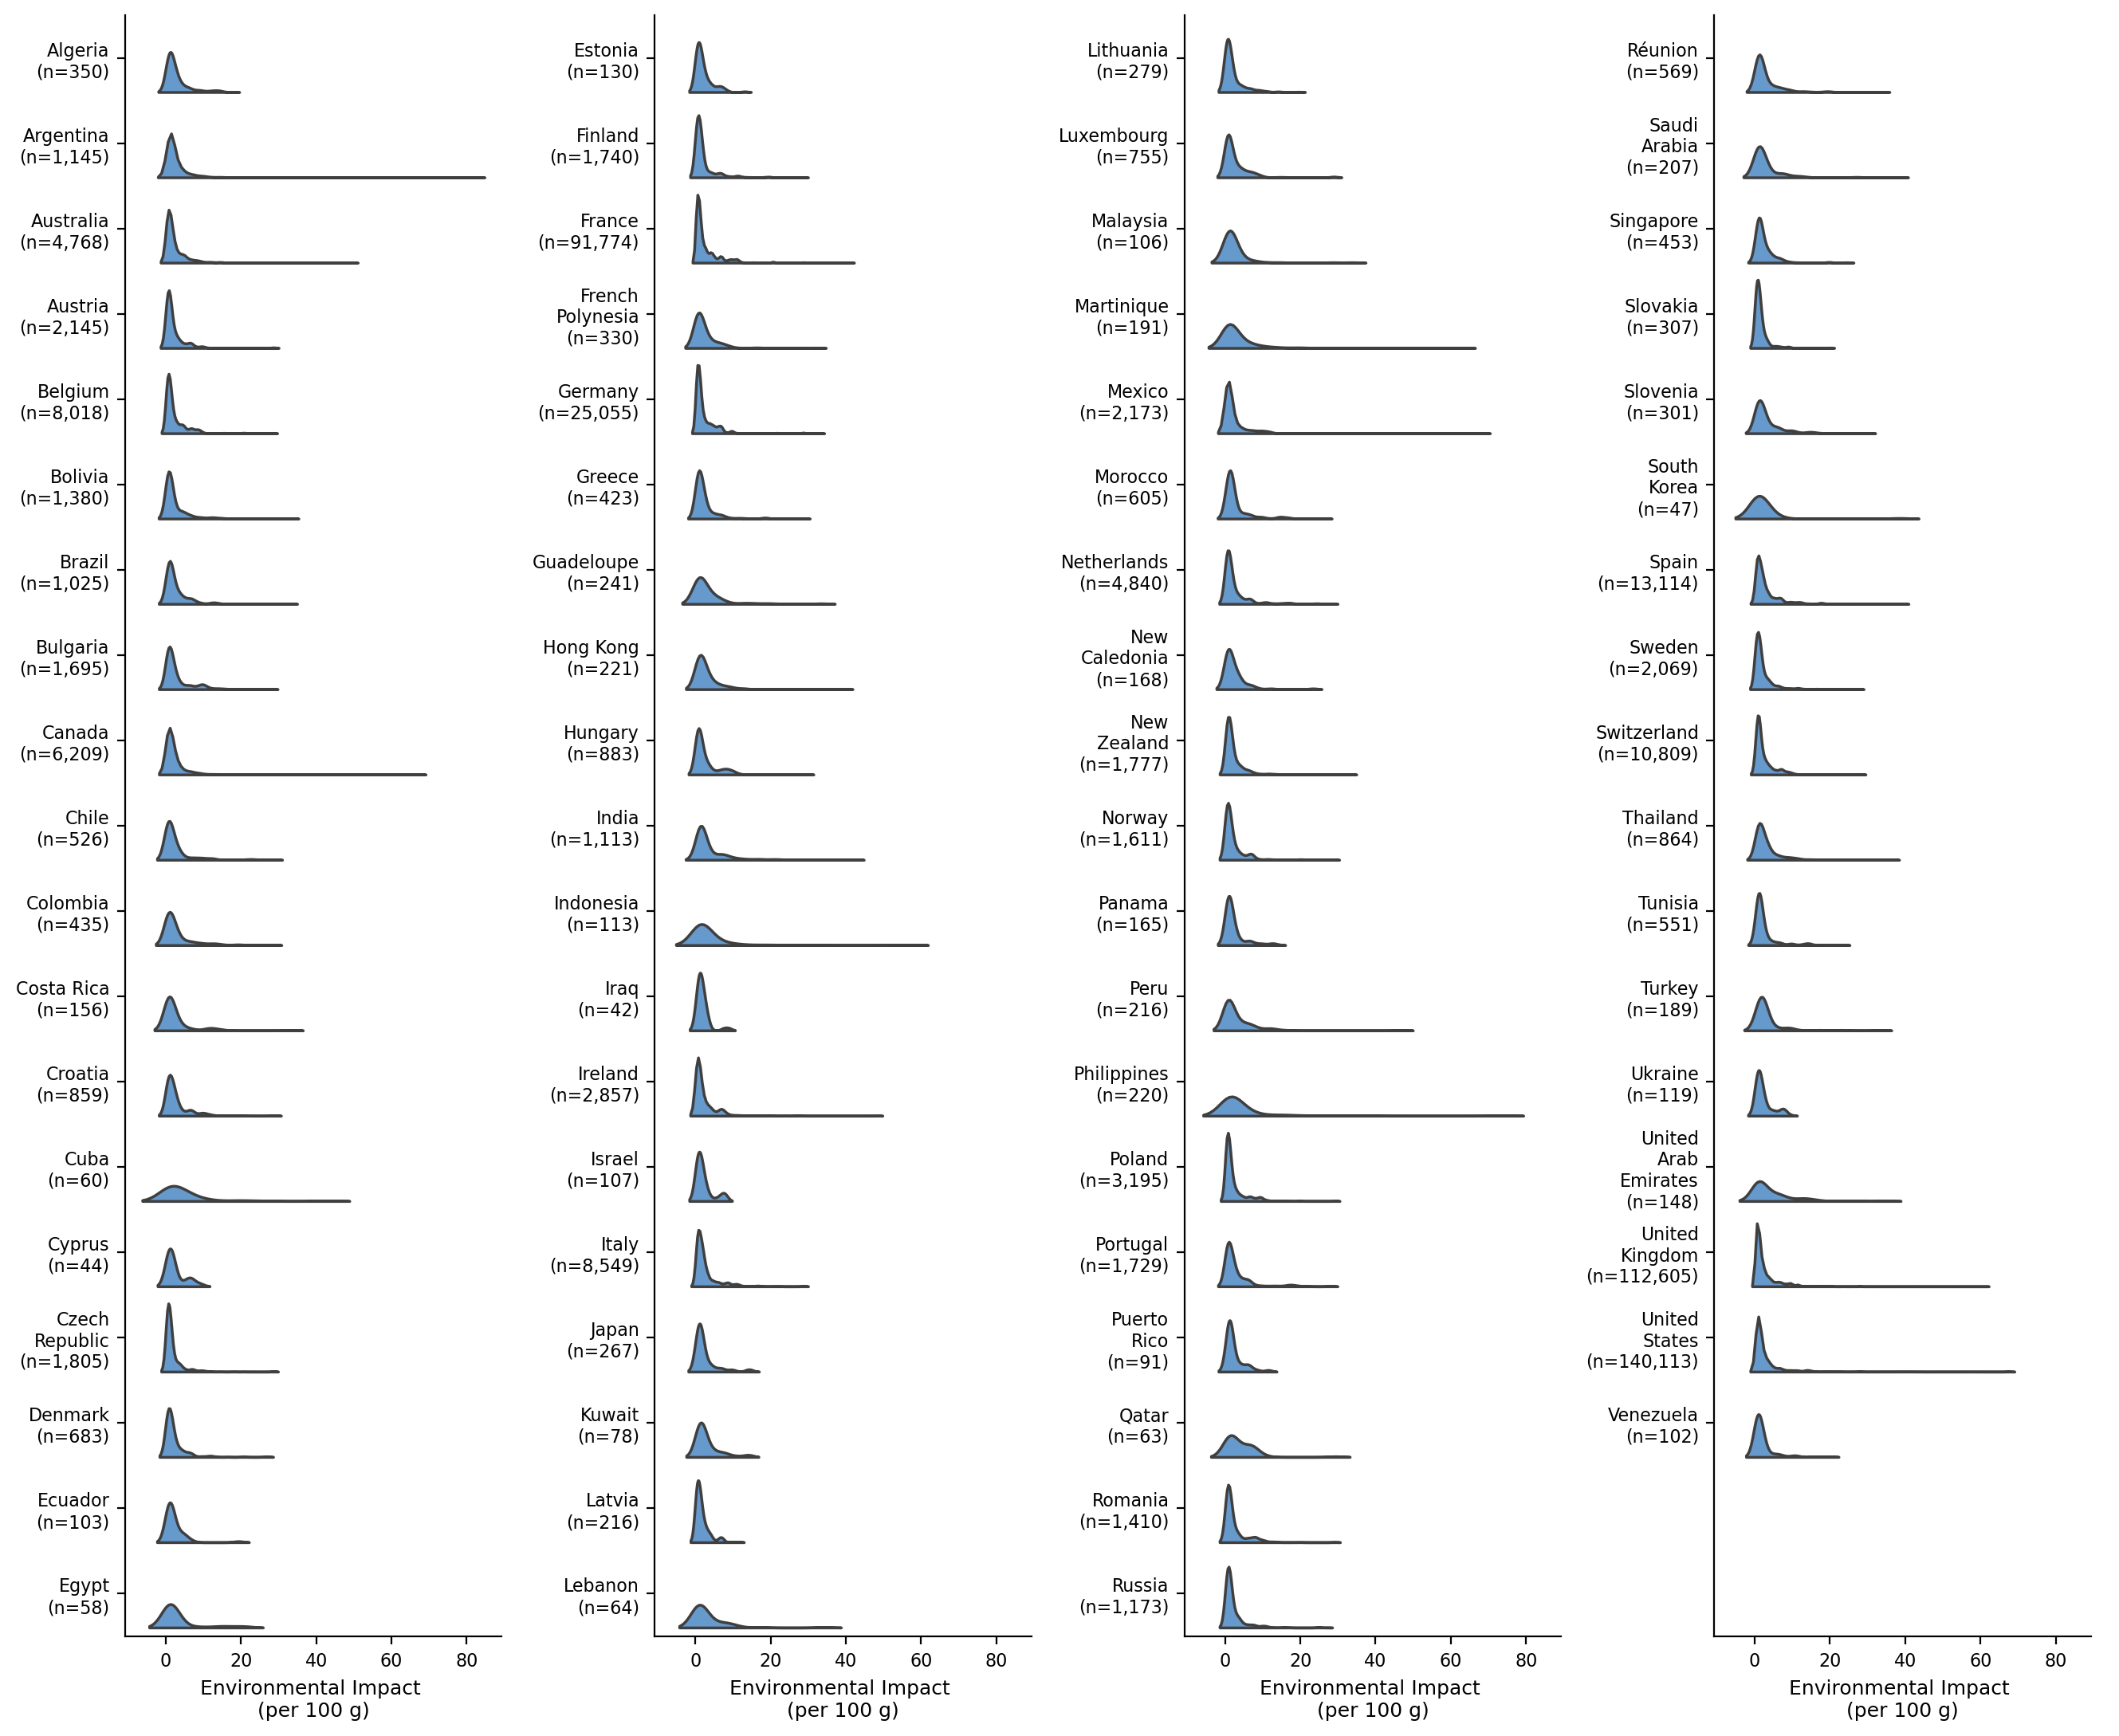

In [111]:
def wrap_tick_labels(ax, width=10):
    labels = ax.get_yticklabels()
    wrapped_labels = []
    for lbl in labels:
        # textwrap.fill wraps the string to the given width
        wrapped_labels.append(textwrap.fill(lbl.get_text(), width=width, break_long_words=False))
    ax.set_yticklabels(wrapped_labels, rotation=0)

sns.set_color_codes()
unique_countries = sorted(impacts['country'].unique())
n_per_facet = 19
country_to_facet = {country: i // n_per_facet for i, country in enumerate(unique_countries)}
impacts['facet'] = impacts['country'].map(country_to_facet)
country_counts = impacts['country'].value_counts()

g = sns.catplot(
    data=impacts,
    kind="violin",
    split=True,
    inner=None,
    x="mean_norm_agg",
    y="country",
    order=unique_countries,
    col="facet",
    sharex=True,  
    sharey=False,
    height=11,
    aspect=0.3
)

for i,ax in enumerate(g.axes.flat):
    ax.set_xlabel("Environmental Impact \n(per 100 g)", fontsize=9)
    ax.set_ylabel("")
    new_labels = []
    for label in ax.get_yticklabels():
        country = label.get_text()
        # Lookup the count; default to 0 if country is not found (shouldn't happen)
        count = country_counts.get(country, 0)
        # Format count with commas (e.g., 1,000)
        new_labels.append(f"{country} (n={count:,})")
    # Wrap y-axis labels
    ticks = ax.get_yticks()  
    ax.set_yticks(ticks)
    ax.set_yticklabels(new_labels)
    wrap_tick_labels(ax, width=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_ylim(n_per_facet*(i+1)-0.5, n_per_facet*i-0.5)
    i+=1

    for pc in ax.findobj(mcoll.PolyCollection):
        # Set the fill color (if you want a single color for all violins)
        pc.set_facecolor("#6699CC")  # or any valid color string
        # Set the transparency (alpha)
        # pc.set_alpha(0.5)
    
g.set_titles("")

plt.tight_layout()
plt.show()

In [112]:
impacts[['mean_Land', 'mean_GHG', 'mean_Eut', 'mean_WatScar', 'mean_Biodiversity']].describe() # this is not normalized (just checking that all indicators are right skewed)

mean_Land       mean_GHG       mean_Eut   mean_WatScar  \
count  469001.000000  469001.000000  469001.000000  469001.000000   
mean        0.684341       0.369335       2.368143    1870.316389   
std         1.410986       0.585370       9.699994    3622.365508   
min         0.000000      -0.314281       0.000000       0.000000   
25%         0.139399       0.097294       0.448823     203.351616   
50%         0.282143       0.180376       0.879505     609.831411   
75%         0.705121       0.335141       1.889327    1854.842862   
max        70.884276      19.620369     208.949239   60445.044578   

       mean_Biodiversity  
count      469001.000000  
mean           18.728742  
std            48.141885  
min             0.000000  
25%             1.670171  
50%             5.215067  
75%            15.750027  
max          3885.707040

In [113]:
impacts[impacts['mean_norm_agg']<0.05].sample(10)[['product_name', 'country']].values

array([['Unsweetened 100% prune juice from concentrate, prune',
        'United States'],
       ['Ain Saiss Gout Apple', 'France'],
       ['Coconut mango energy fuel, coconut mango', 'United States'],
       ['Nice!, caffeine-free soda, orange', 'United States'],
       ['Lemonade juice drink from concentrate, lemonade',
        'United States'],
       ['Baking Powder, Double Acting', 'United States'],
       ['Solar eclipse pure energy drink', 'United States'],
       ["Hartley's No Added Sugar Orange Jelly Pot", 'United Kingdom'],
       ['Caffeine free weis up soda', 'United States'],
       ['Cultivated wild rice', 'United States']], dtype=object)

In [114]:
impacts[impacts['mean_norm_agg']>60].sample(10)[['product_name', 'country']].values

array([['Chop house angus beef brisket steak burger', 'United States'],
       ['American style kobe beef burgers', 'United States'],
       ['100% pure ground beef chuck', 'United States'],
       ['Angus beef & beef patties', 'United States'],
       ['Organic Grass Fed Beef Ny Strip Loin Steak', 'United States'],
       ['Organic Ground Beef Patties', 'United States'],
       ['American style kobe beef & ground beef', 'United States'],
       ['American wagyu beef patties', 'United States'],
       ['Grass run farms 100% grass fed uncured beef hot dogs',
        'United States'],
       ['New york strip steak 100% grassfed beef, new york strip steak',
        'United States']], dtype=object)

#### nutrition stuff

In [115]:
nutri = pd.read_csv('../../SFS/environmental_impacts/Managed_Data/NutriScore for radar plots 2025-01-29 Log2.csv')

In [116]:
nutri = nutri.merge(impacts[['groups', 'labels', 'ID', 'product_id', 'mean_norm_agg']], left_on='id', right_on='product_id')
nutri['NutriScorePoints'] = 100 * (nutri['NutriScorePoints'] - nutri['NutriScorePoints'].min()) / (nutri['NutriScorePoints'].max() - nutri['NutriScorePoints'].min())

In [117]:
df_plot = nutri.merge(country_groups[['Country', 'Intermediate Region Name', 'Sub-region Name', 'Region Name']], left_on='country',
                        right_on='Country').drop('Country', axis=1)
df_plot.loc[df_plot['country'].isin(['United Kingdom', 'Ireland']), 'country'] = 'UK and Ireland'
df_plot.loc[df_plot['country'].isin(['United States', 'Canada']), 'country'] = 'USA and Canada'

df_plot.loc[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada']), 'country'] = df_plot[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada'])]['Region Name']

df_plot.loc[df_plot['country'].isin(['Americas']), 'country'] = 'Latin America'
df_plot.loc[df_plot['country'].isin(['Europe']), 'country'] = 'Other Europe'

In [118]:
df_plot['NutriScorePoints'].corr(df_plot['mean_norm_agg'])

0.14225140851149254

In [119]:
df_plot.groupby('groups')[['mean_norm_agg','NutriScorePoints']].corr().unstack().iloc[:,1].sort_values()

groups
Non-Alcoholic Beverages        -0.024818
Cereals and Cereal Products     0.045219
Fruits, Vegetables, and Nuts    0.058762
Miscellaneous items             0.110265
Sugar and Confectionery         0.147711
Meat, Dairy, and Eggs           0.236382
Name: (mean_norm_agg, NutriScorePoints), dtype: float64

In [120]:
df = df_plot.groupby(['country', 'groups', 'labels', 'ID'])[['mean_norm_agg', 'NutriScorePoints']].mean().reset_index()

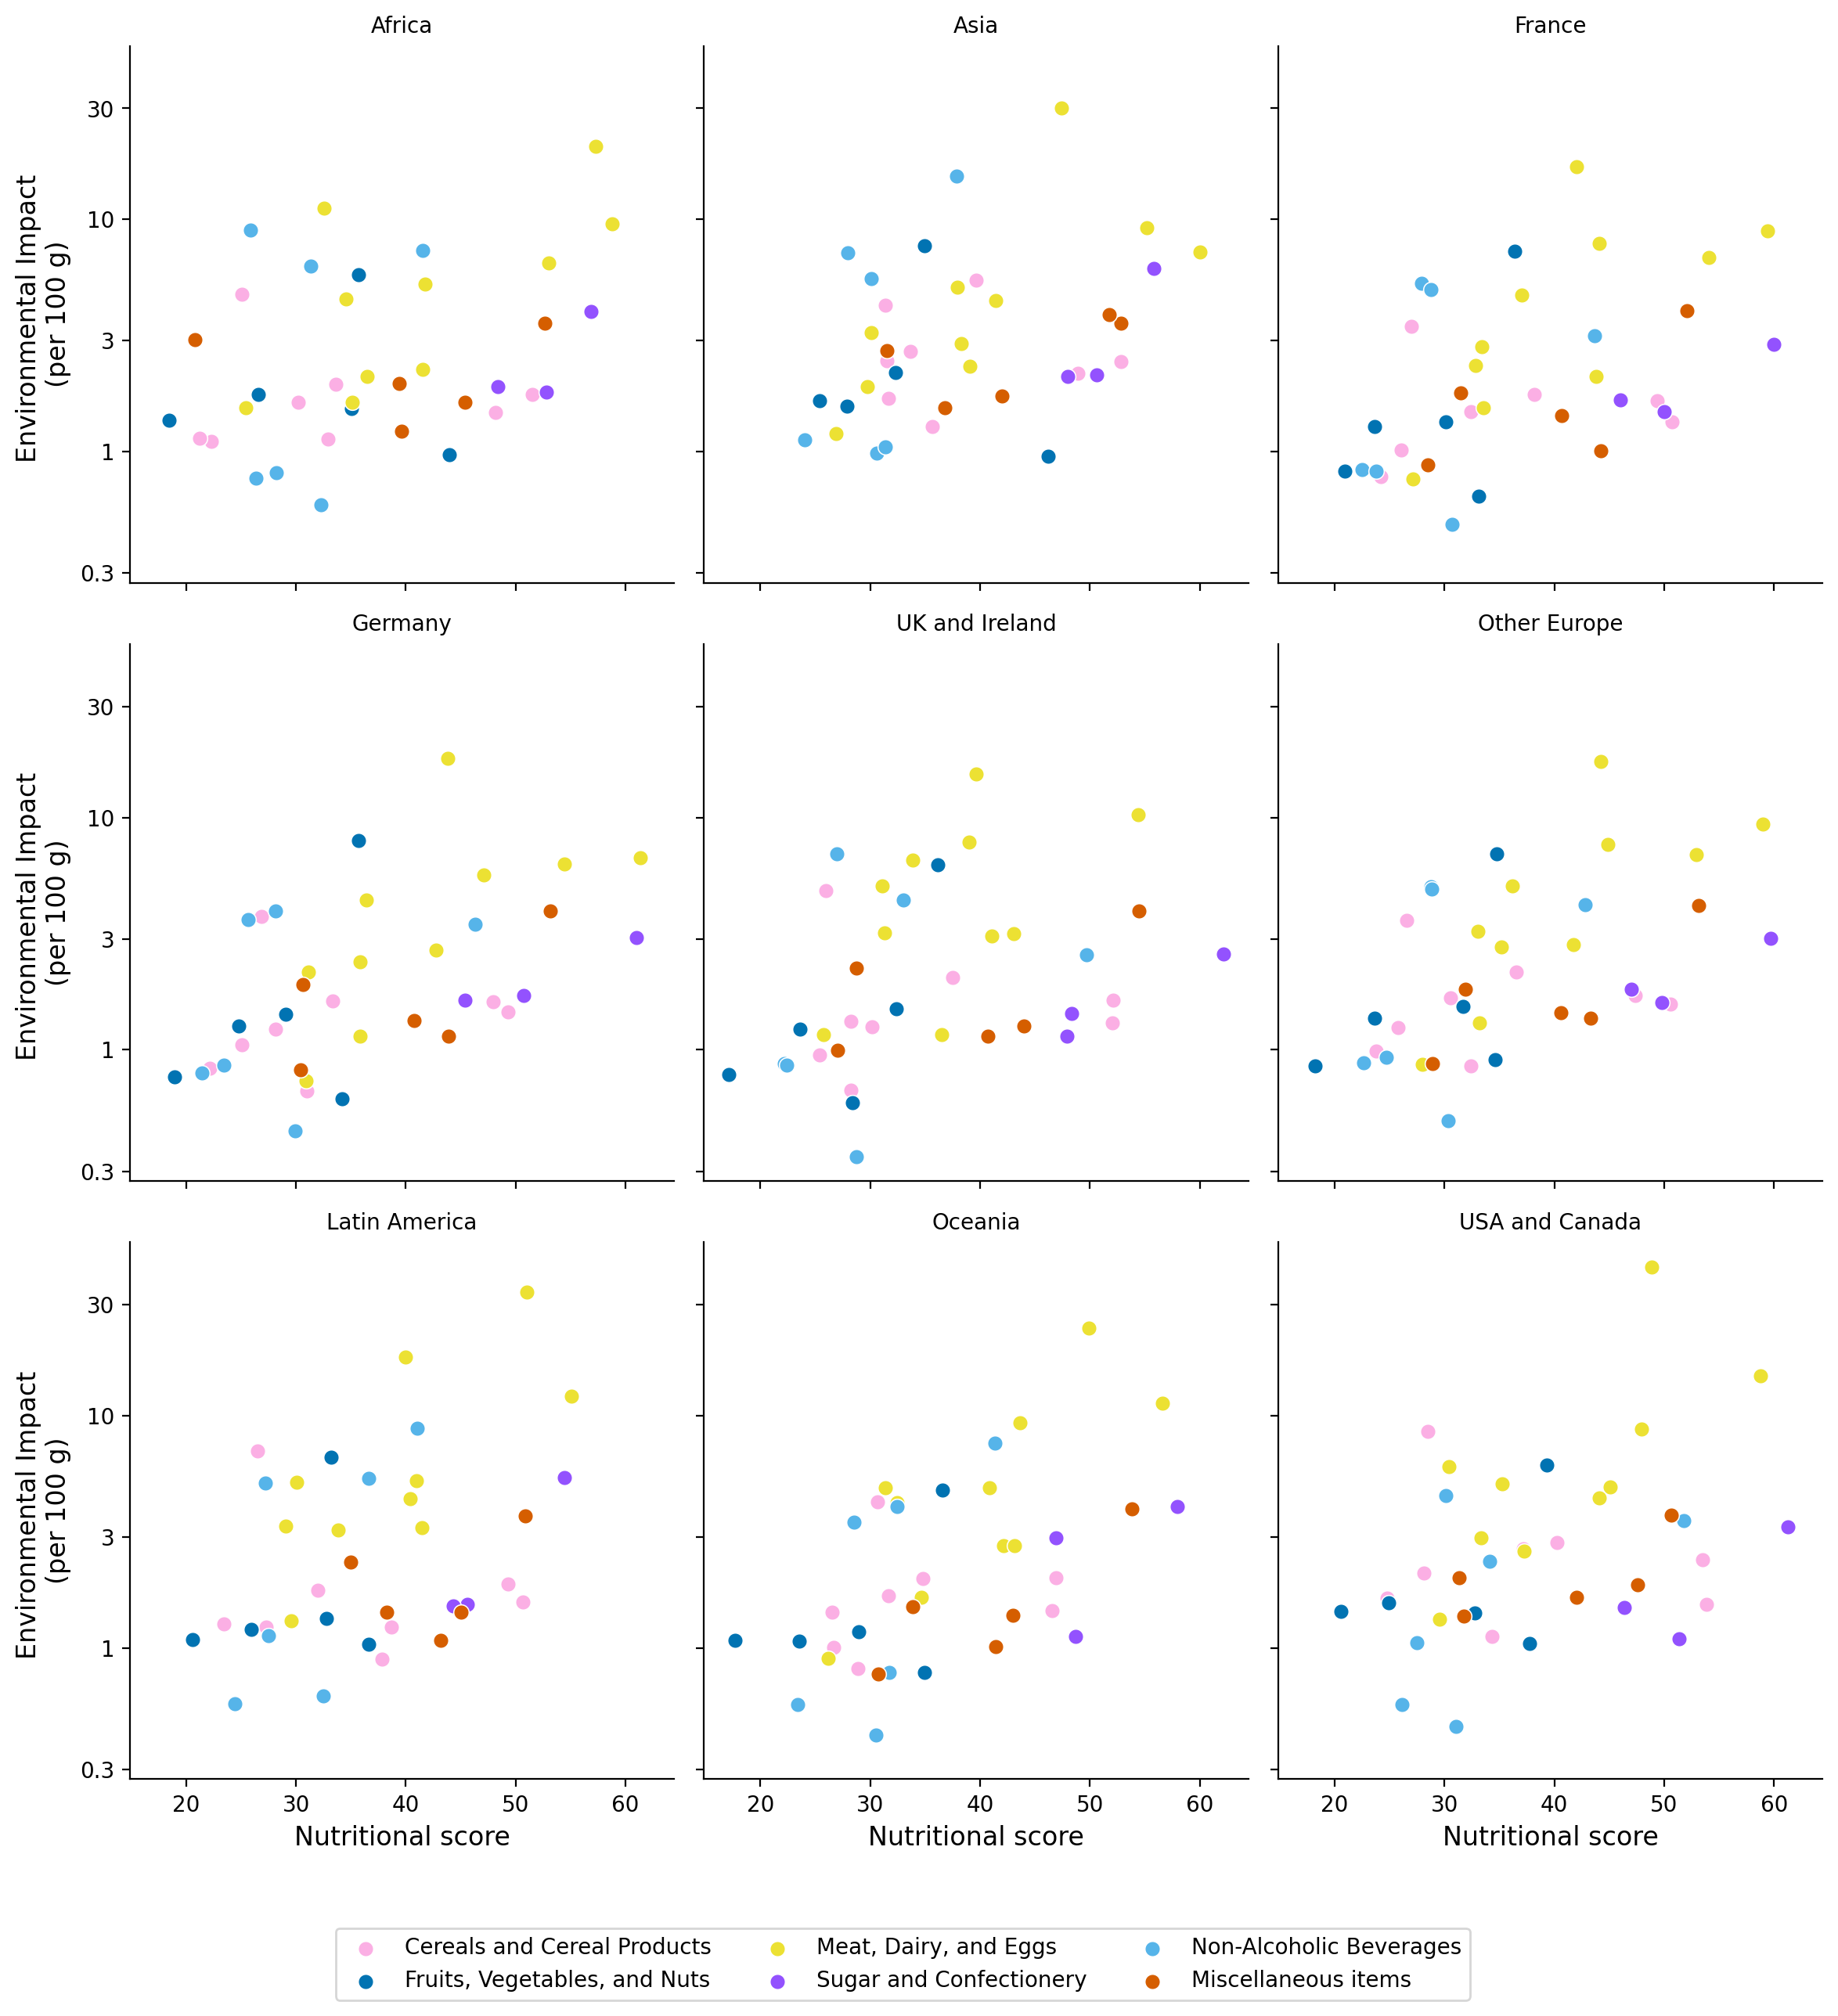

In [121]:
g = sns.FacetGrid(data=df, 
                  col="country",  col_wrap=3, hue='groups', 
                  hue_order=['Cereals and Cereal Products', 'Fruits, Vegetables, and Nuts',
                             'Meat, Dairy, and Eggs', 'Sugar and Confectionery', 
                             'Non-Alcoholic Beverages', 'Miscellaneous items'],
                  col_order=['Africa', 'Asia', 'France', 'Germany', 'UK and Ireland',
                             'Other Europe', 'Latin America', 'Oceania', 'USA and Canada'],
                  height=4, aspect=1,
                  palette=sns.color_palette(["#fbafe4", "#0173b2", "#ece133", "#9352fe",  "#56b4e9", "#d55e00"]))
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm_agg', s=50)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=12)
g.set_xlabels("Nutritional score", fontsize=12)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off()  

g.add_legend(title='', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=True)

plt.show()

In [122]:
df_plot = df_plot[df_plot['country'].isin([ 'France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada'])]
df = df_plot.groupby('labels').apply(lambda g: g.sample(100)).reset_index(drop=True)

/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_60799/3969954089.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_plot.groupby('labels').apply(lambda g: g.sample(100)).reset_index(drop=True)


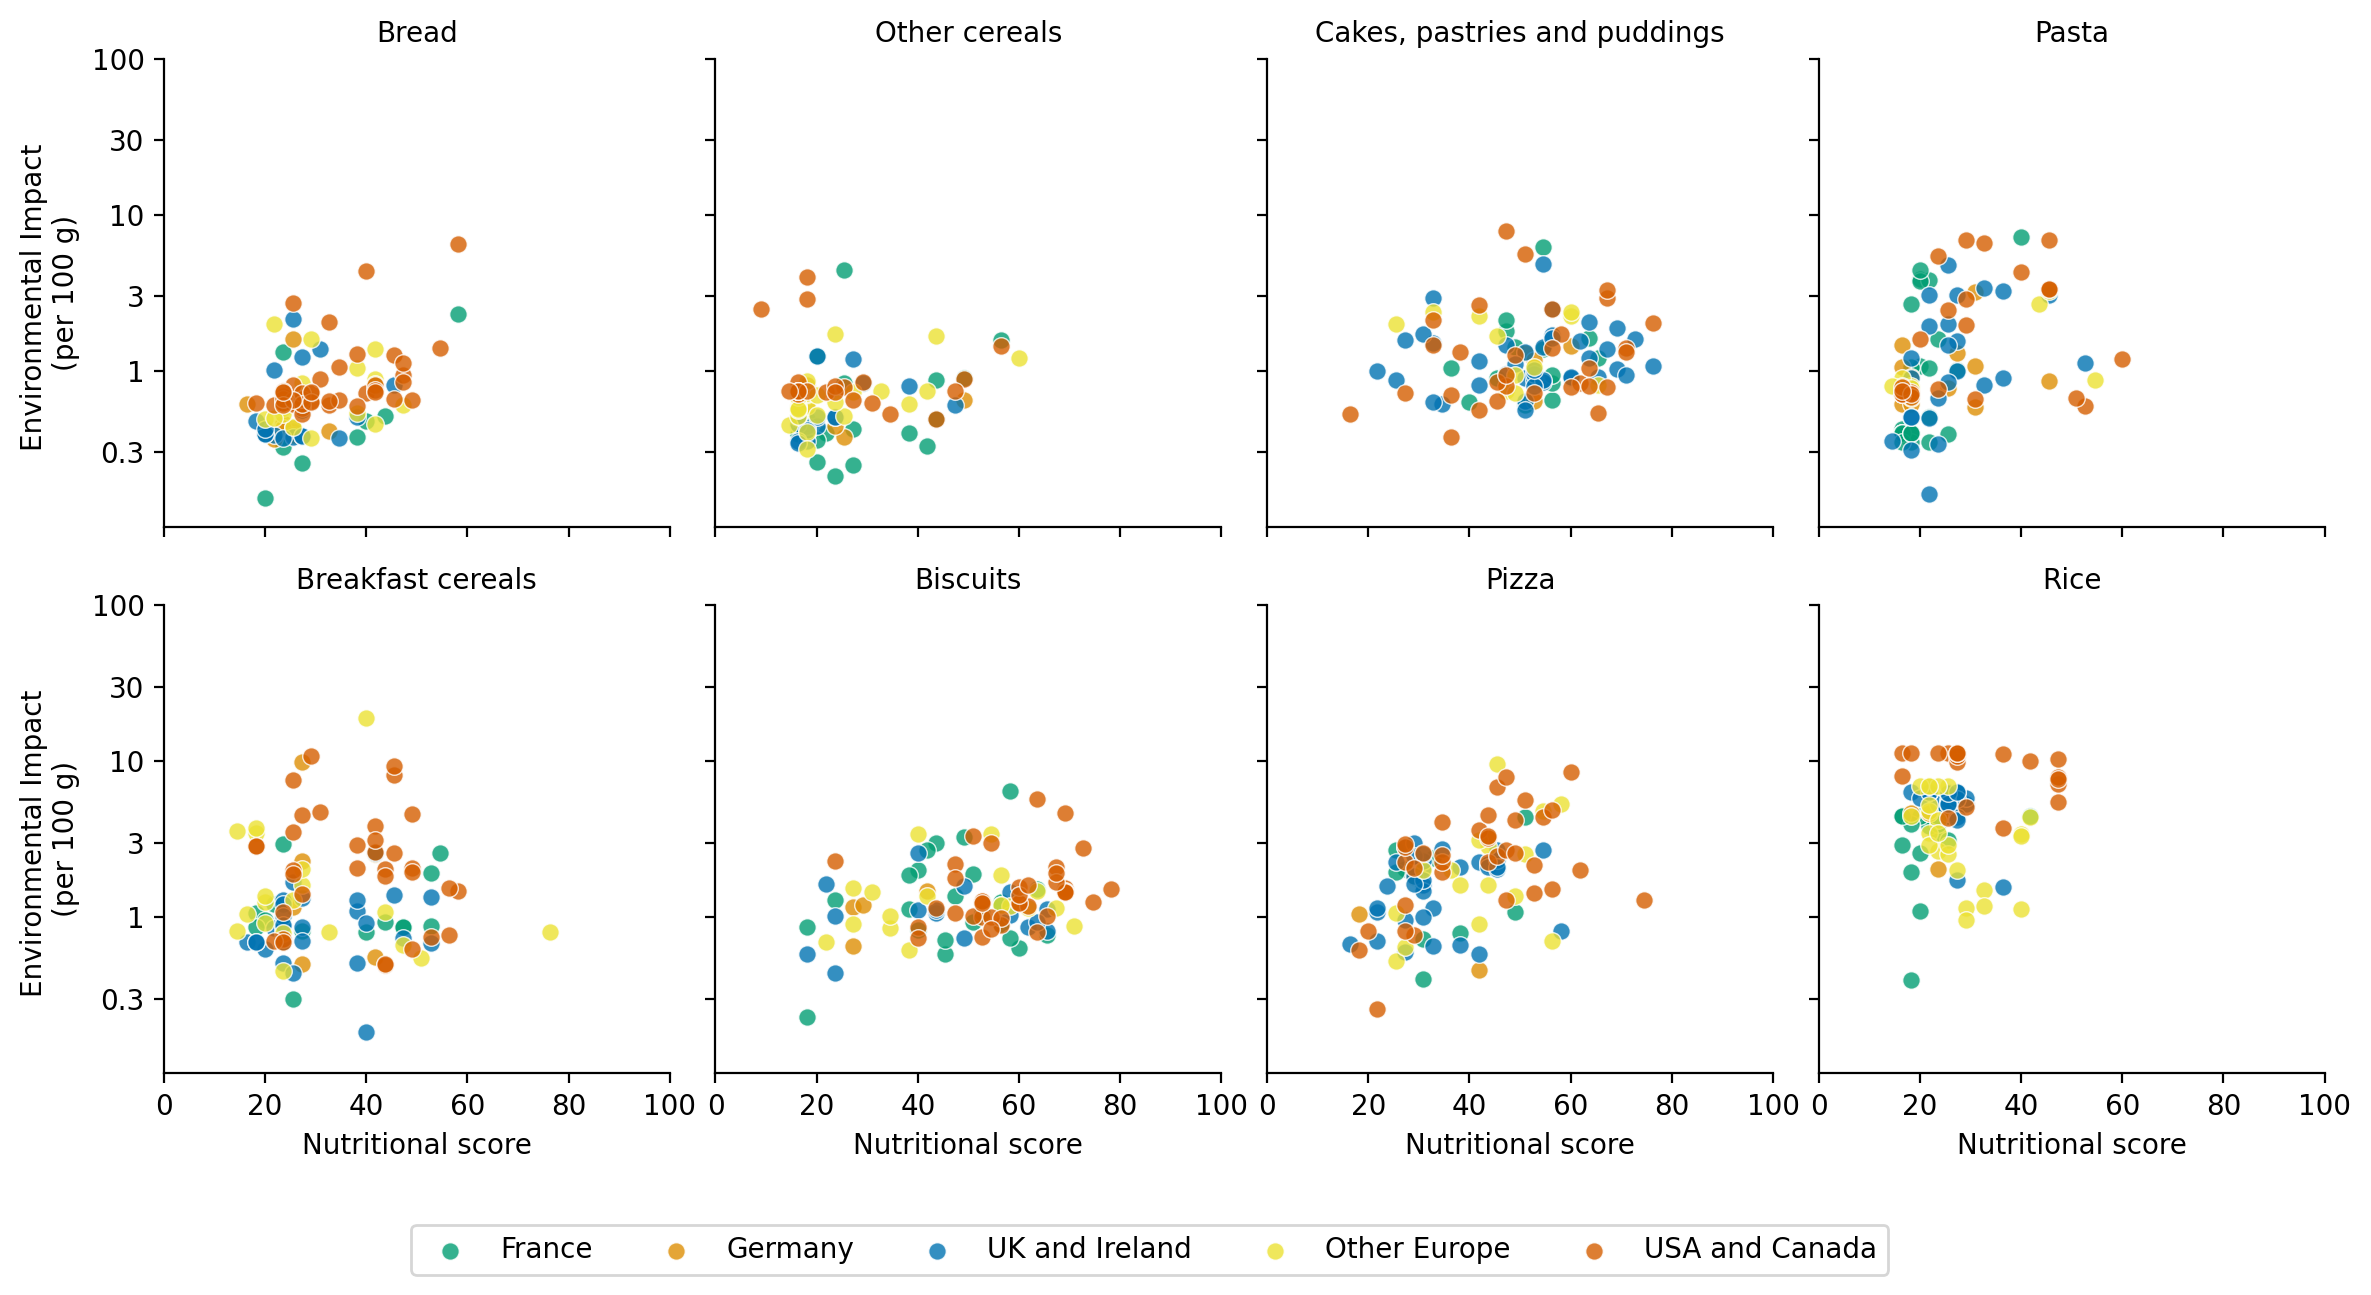

In [123]:
grp = 'Cereals and Cereal Products'

g = sns.FacetGrid(data=df[df['groups']==grp].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  col_order = order_df[order_df['groups'] == grp]['labels'].values,
                  hue_order=['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada'],
                  palette=sns.color_palette(["#029e73", "#de8f05", "#0173b2", "#ece133", "#d55e00"]),
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm_agg', s=40, alpha=0.8)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30, 100]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off() 
    ax.set_xlim(0, 100)
    ax.set_ylim(0.1, 100)

g.add_legend(title='', ncol=5, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

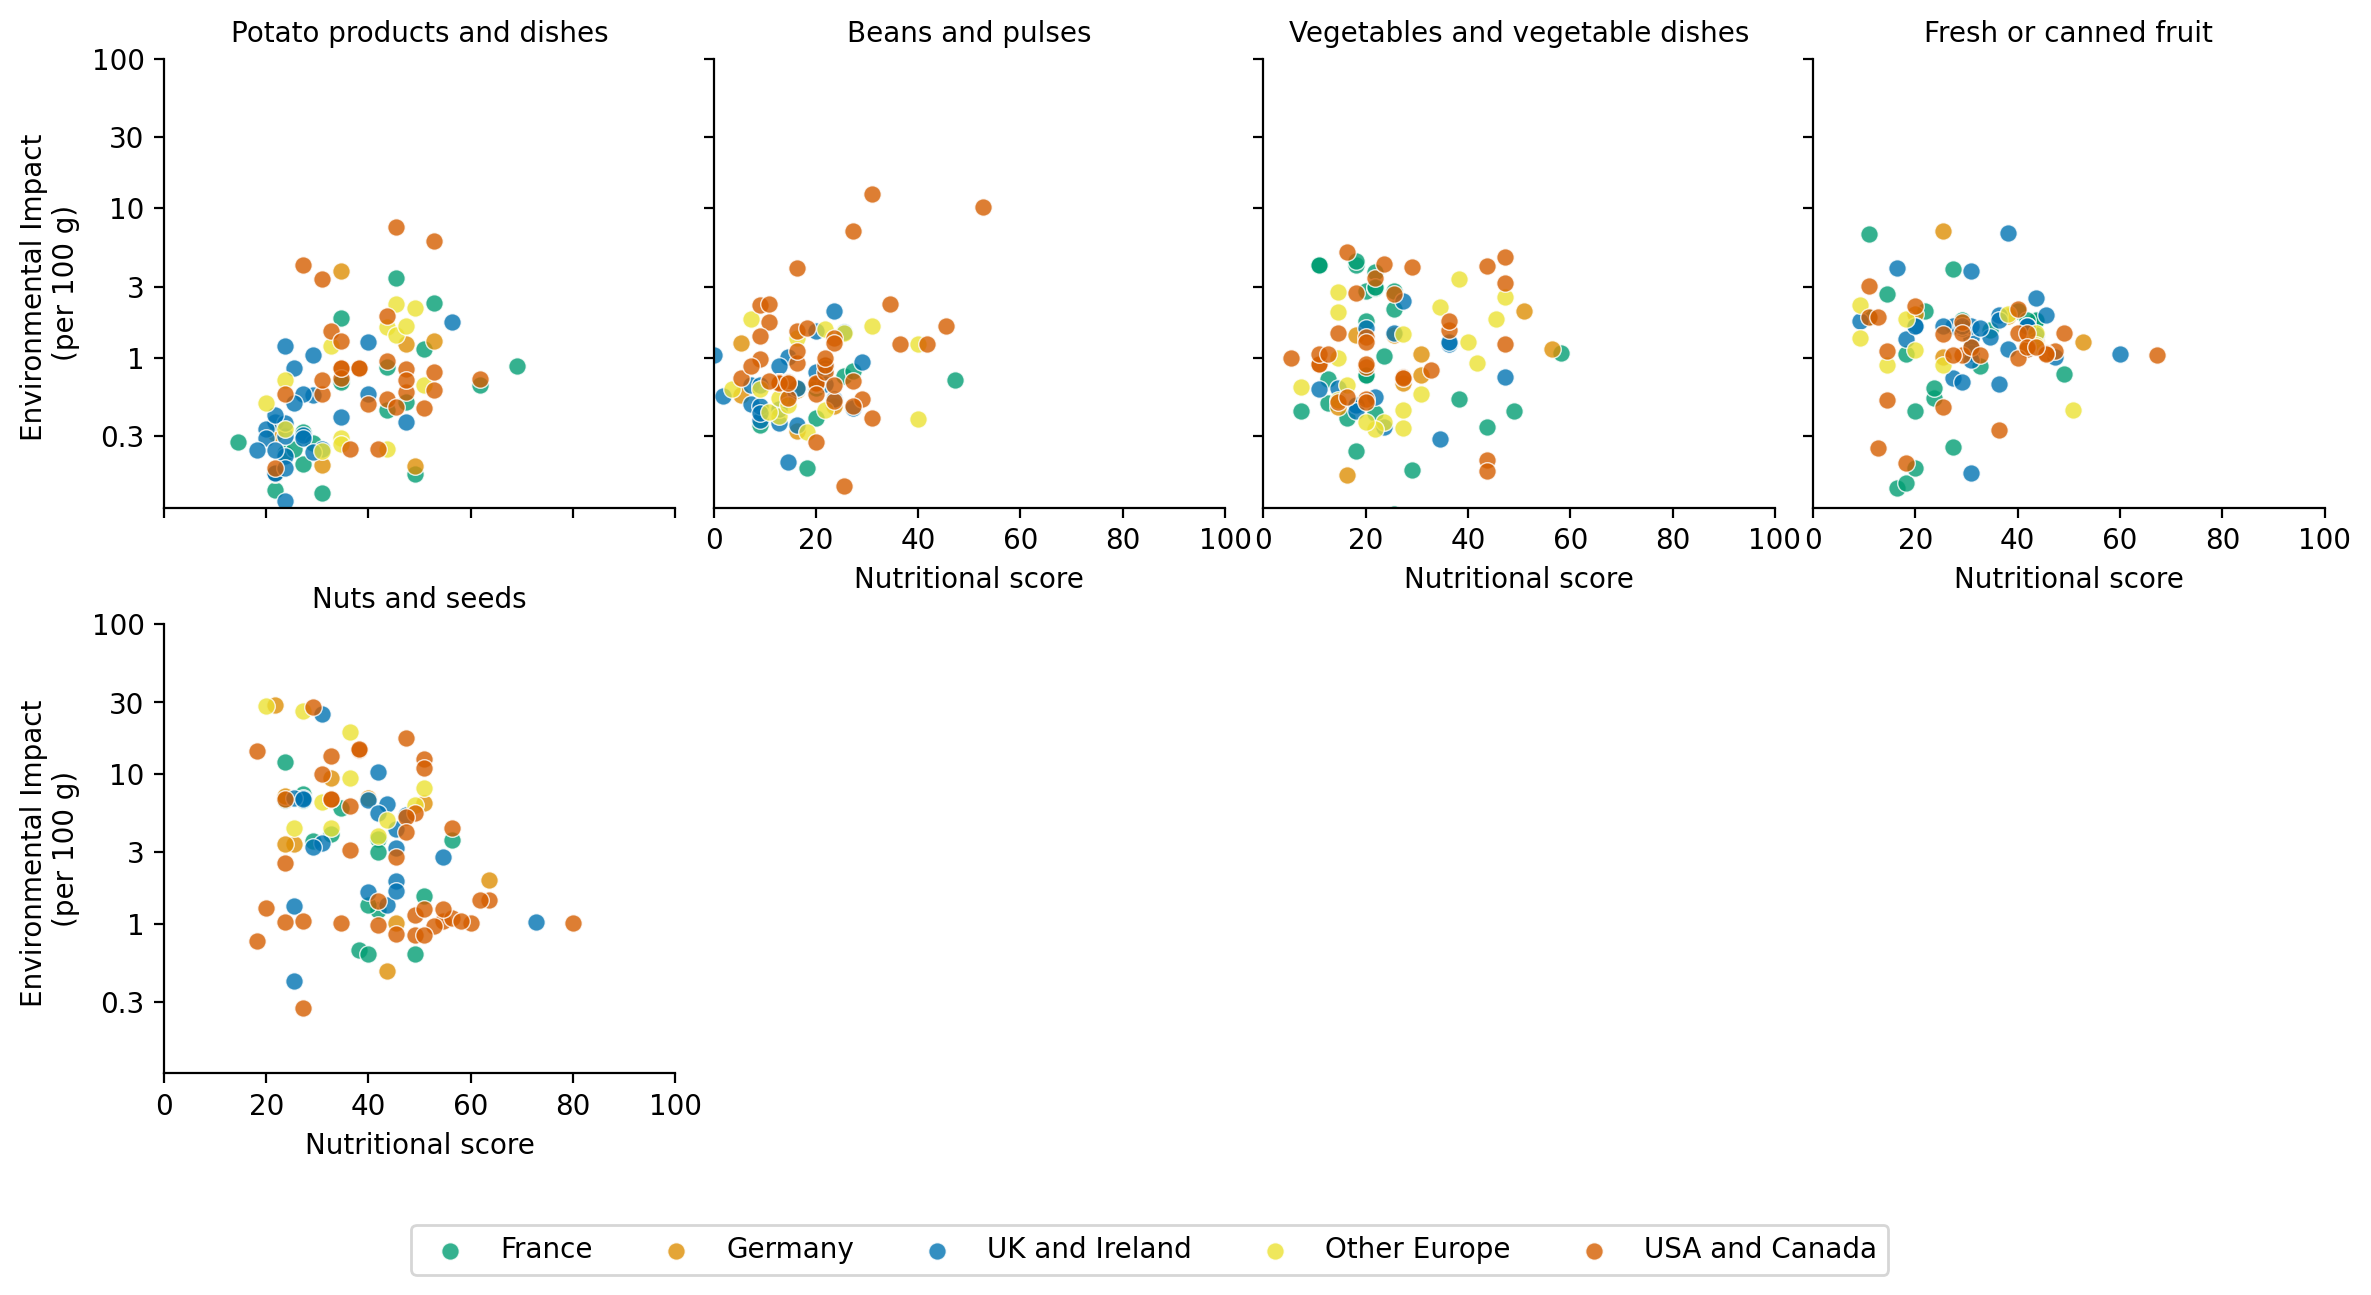

In [124]:
grp = 'Fruits, Vegetables, and Nuts'

g = sns.FacetGrid(data=df[df['groups']==grp].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  col_order = order_df[order_df['groups'] == grp]['labels'].values,
                  hue_order=['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada'],
                  palette=sns.color_palette(["#029e73", "#de8f05", "#0173b2", "#ece133", "#d55e00"]),
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm_agg', s=40, alpha=0.8)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30, 100]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off() 
    ax.set_xlim(0, 100)
    ax.set_ylim(0.1, 100)

g.add_legend(title='', ncol=5, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

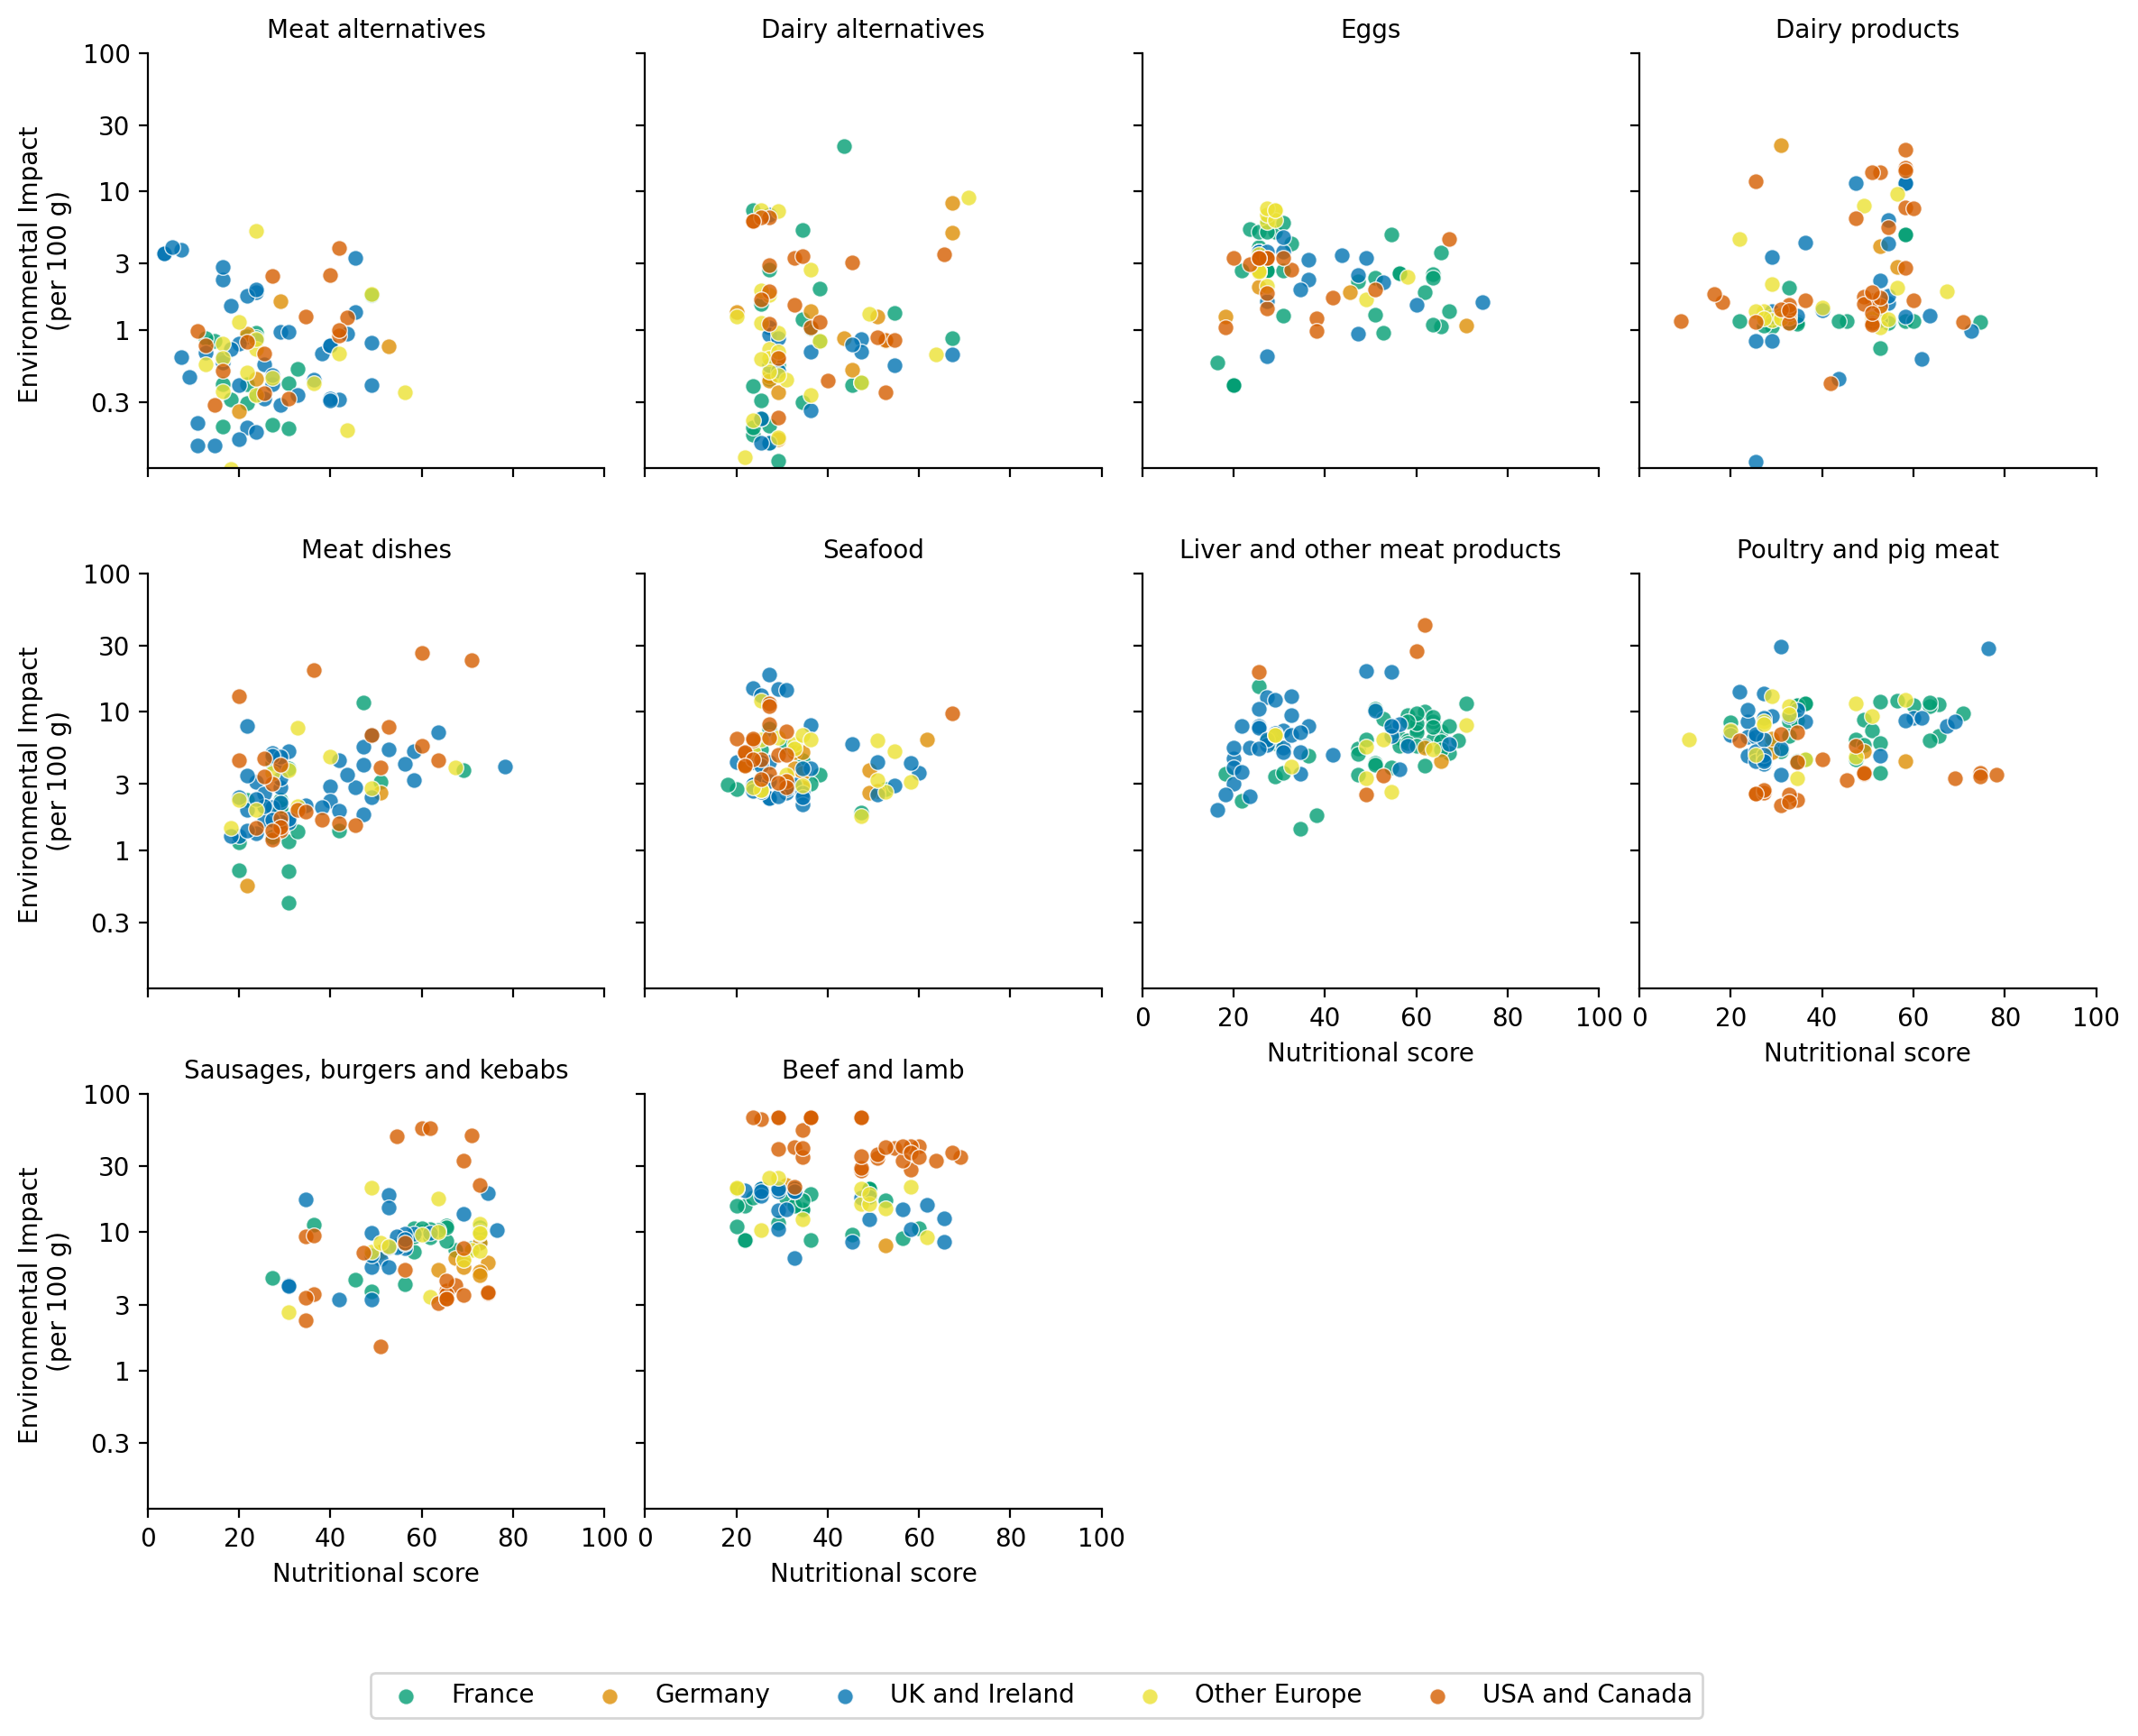

In [125]:
grp = 'Meat, Dairy, and Eggs'

g = sns.FacetGrid(data=df[df['groups']==grp].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  col_order = order_df[order_df['groups'] == grp]['labels'].values,
                  hue_order=['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada'],
                  palette=sns.color_palette(["#029e73", "#de8f05", "#0173b2", "#ece133", "#d55e00"]),
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm_agg', s=40, alpha=0.8)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30, 100]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off() 
    ax.set_xlim(0, 100)
    ax.set_ylim(0.1, 100)

g.add_legend(title='', ncol=5, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

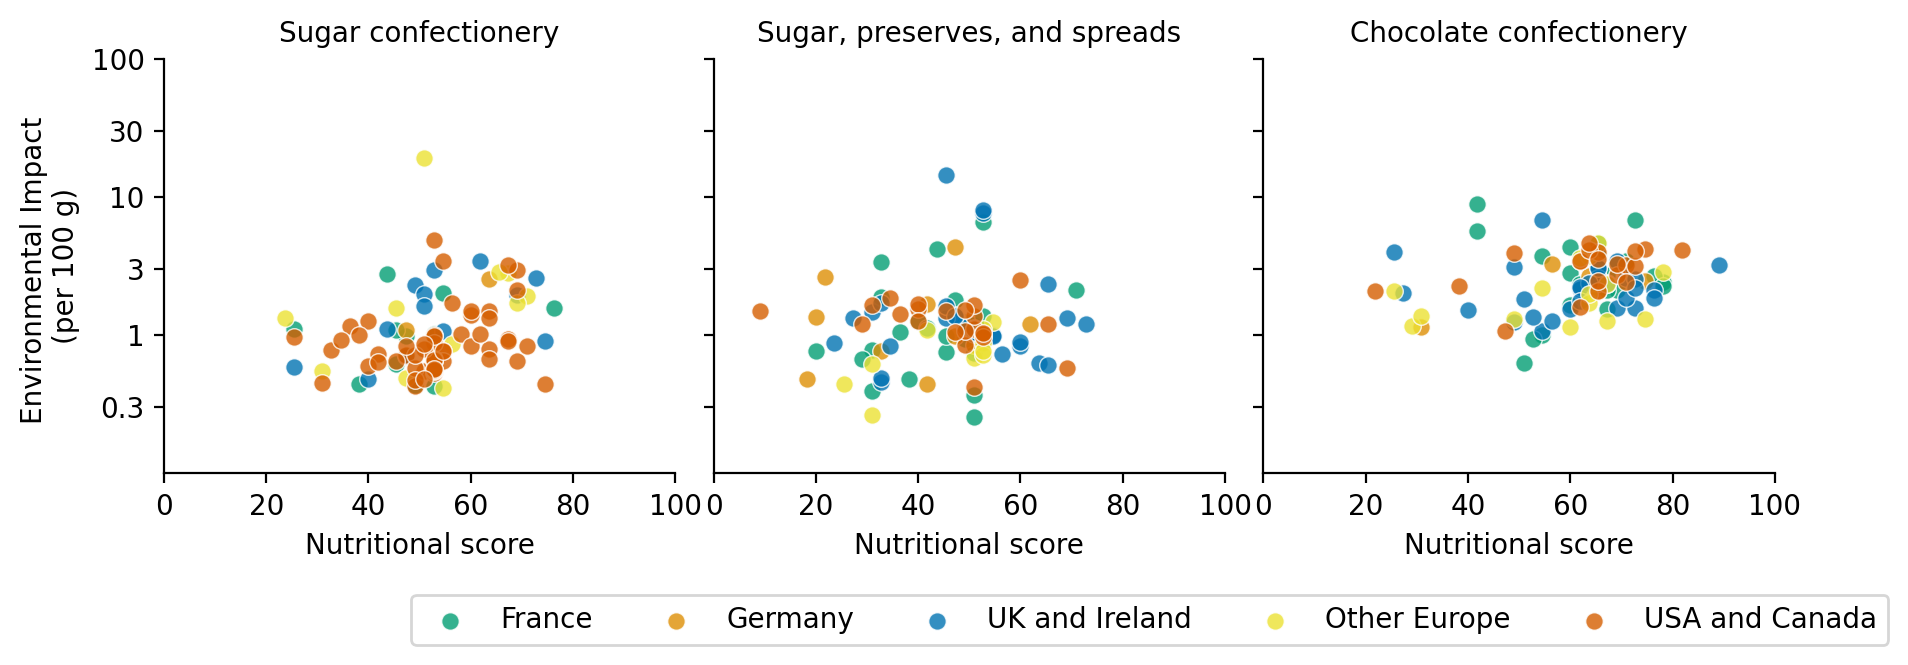

In [126]:
grp = 'Sugar and Confectionery'

g = sns.FacetGrid(data=df[df['groups']==grp].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  col_order = order_df[order_df['groups'] == grp]['labels'].values,
                  hue_order=['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada'],
                  palette=sns.color_palette(["#029e73", "#de8f05", "#0173b2", "#ece133", "#d55e00"]),
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm_agg', s=40, alpha=0.8)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30, 100]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off() 
    ax.set_xlim(0, 100)
    ax.set_ylim(0.1, 100)

g.add_legend(title='', ncol=5, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

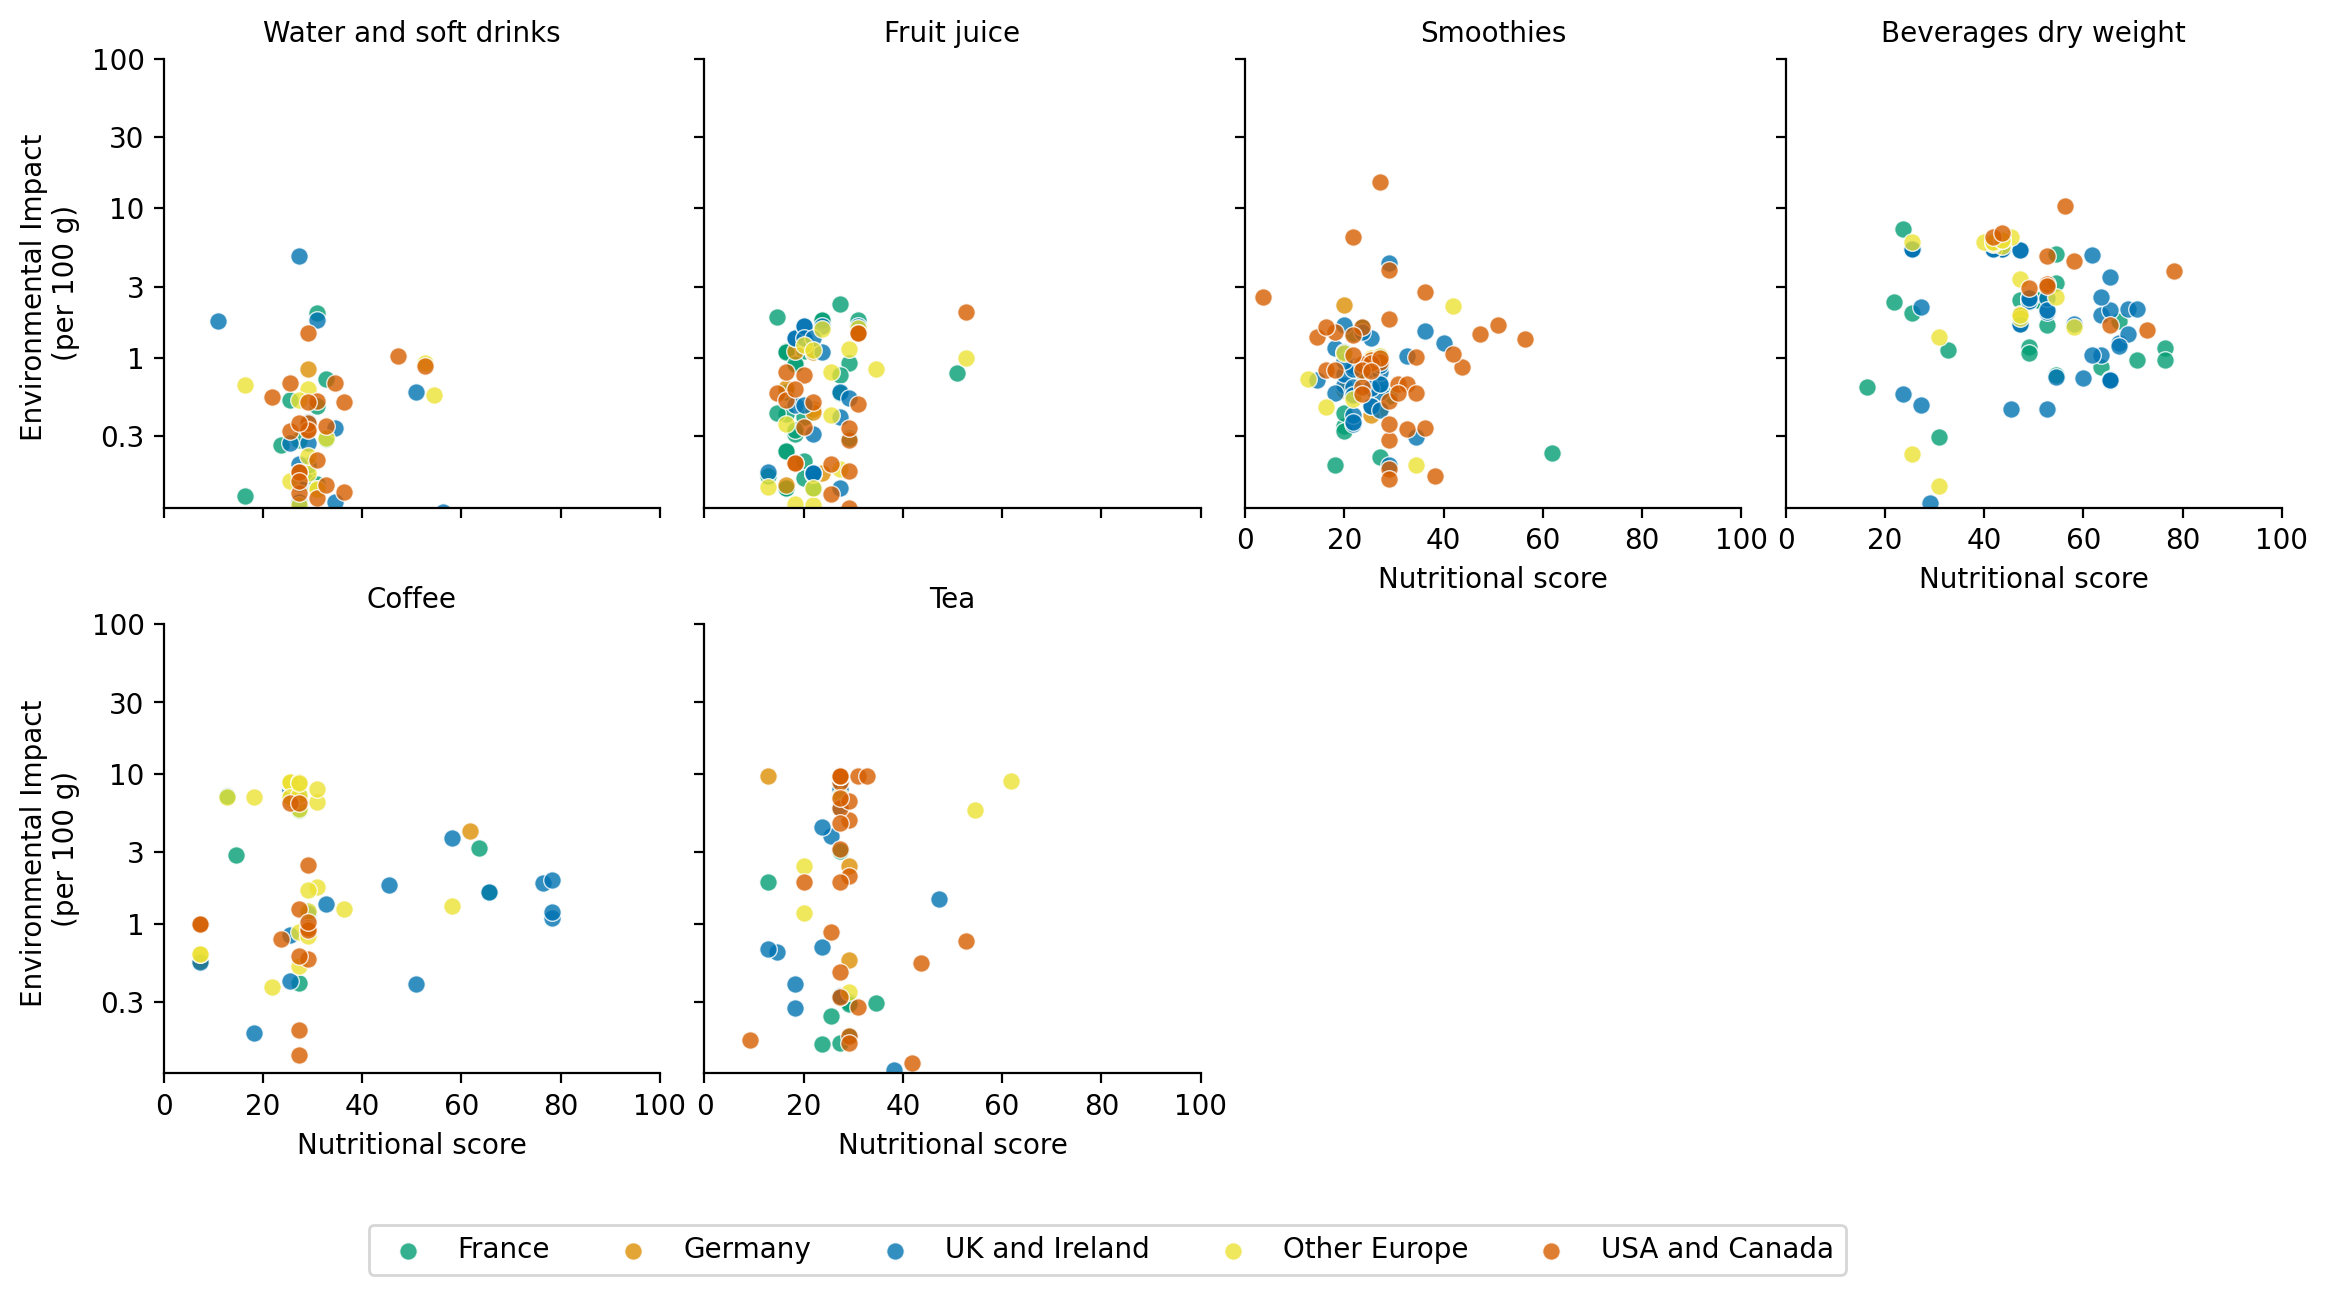

In [127]:
grp = 'Non-Alcoholic Beverages'

g = sns.FacetGrid(data=df[df['groups']==grp].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  col_order = order_df[order_df['groups'] == grp]['labels'].values,
                  hue_order=['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada'],
                  palette=sns.color_palette(["#029e73", "#de8f05", "#0173b2", "#ece133", "#d55e00"]),
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm_agg', s=40, alpha=0.8)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30, 100]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off() 
    ax.set_xlim(0, 100)
    ax.set_ylim(0.1, 100)

g.add_legend(title='', ncol=5, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

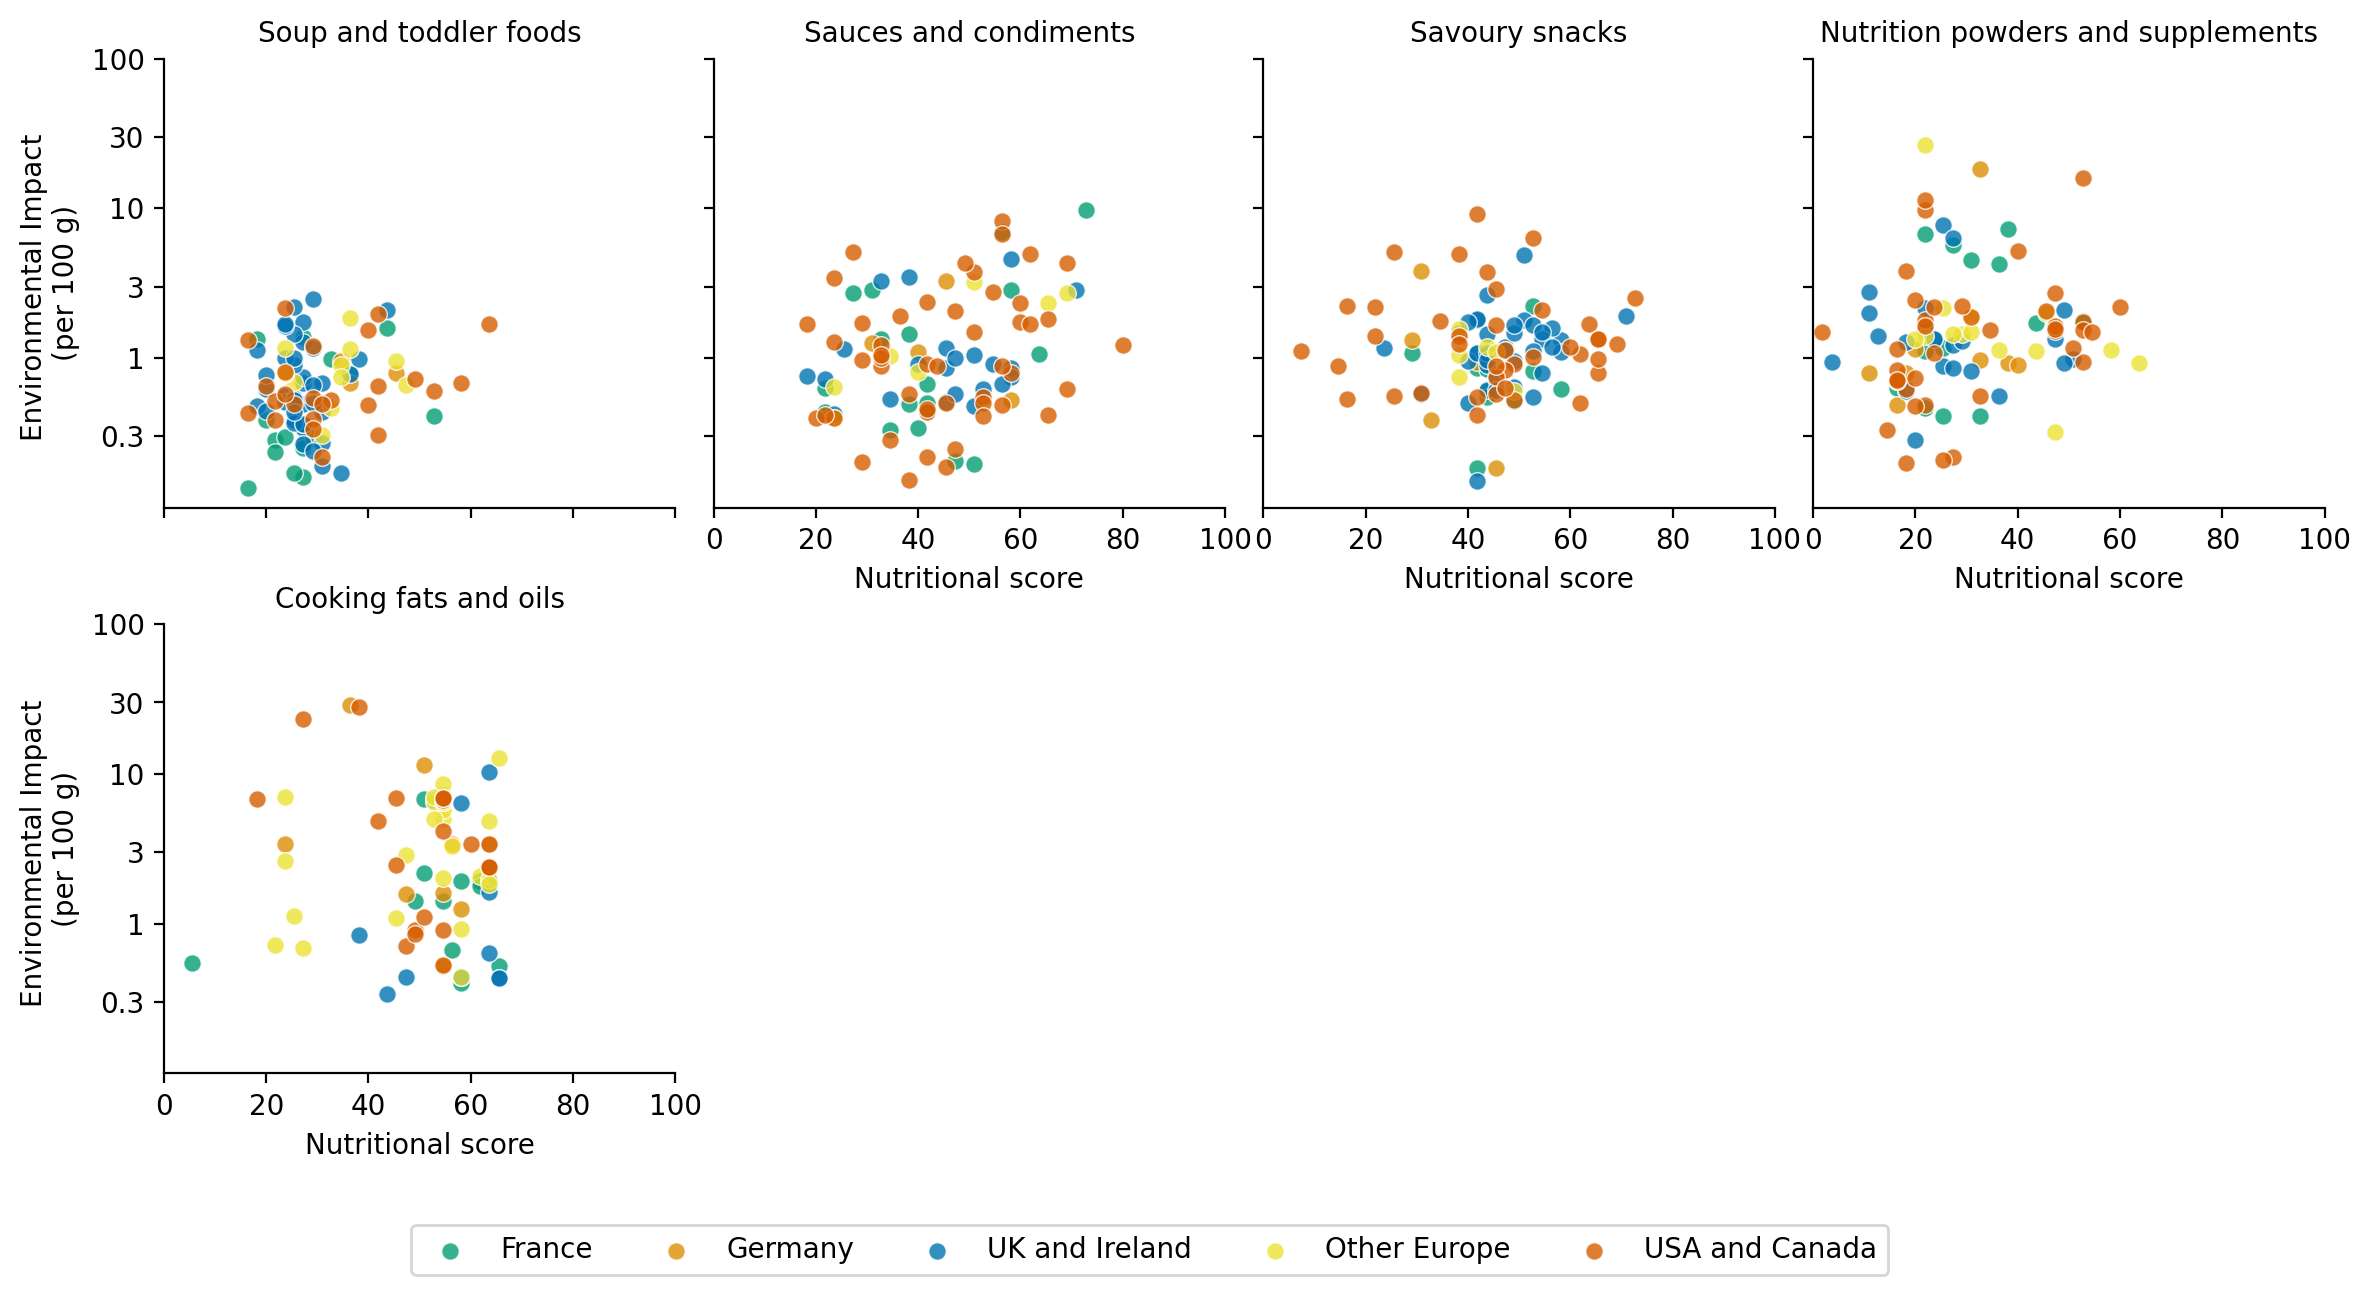

In [128]:
grp = 'Miscellaneous items'

g = sns.FacetGrid(data=df[df['groups']==grp].sort_values(by='ID'), 
                  col="labels", hue='country', 
                  col_order = order_df[order_df['groups'] == grp]['labels'].values,
                  hue_order=['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada'],
                  palette=sns.color_palette(["#029e73", "#de8f05", "#0173b2", "#ece133", "#d55e00"]),
                  height=3, aspect=1,
                  col_wrap=4)
g.map(sns.scatterplot, 'NutriScorePoints', 'mean_norm_agg', s=40, alpha=0.8)

g.set_titles("{col_name}")
g.set_ylabels("Environmental Impact \n(per 100 g)", fontsize=10)
g.set_xlabels("Nutritional score", fontsize=10)

for ax in g.axes.flatten():
    ax.set_yscale('log')
    major_ticks = [0.3, 1, 3, 10, 30, 100]
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.minorticks_off() 
    ax.set_xlim(0, 100)
    ax.set_ylim(0.1, 100)

g.add_legend(title='', ncol=5, bbox_to_anchor=(0.5, -0.05), frameon=True)
    
plt.show()

In [129]:
# number of ingredients vs nutri score

df_plot = composition.copy().rename(columns={'id': 'product_id'})
# nulls haven't been removed, counting the number of values in ingredients text, as opposed to ingredient categories
df_plot = df_plot.merge(nutri[['product_id', 'groups', 'labels', 'mean_norm_agg', 'NutriScorePoints']])
df_plot.loc[(df_plot['Food_Category'].notnull()) & (df_plot['value'].isna()), 'value'] = df_plot[(
    df_plot['Food_Category'].notnull()) & (df_plot['value'].isna())]['Food_Category']
df_plot = df_plot.groupby(['product_id', 'country', 'groups', 'labels', 'mean_norm_agg', 'NutriScorePoints'])[['value']].nunique().reset_index()

df_plot = df_plot.merge(country_groups[['Country', 'Intermediate Region Name', 'Sub-region Name', 'Region Name']], left_on='country',
                        right_on='Country').drop('Country', axis=1)
df_plot.loc[df_plot['country'].isin(['United Kingdom', 'Ireland']), 'country'] = 'UK and Ireland'
df_plot.loc[df_plot['country'].isin(['United States', 'Canada']), 'country'] = 'USA and Canada'

df_plot.loc[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada']), 'country'] = df_plot[~df_plot['country'].isin([
    'France', 'Germany', 'UK and Ireland', 'USA and Canada'])]['Region Name']

df_plot.loc[df_plot['country'].isin(['Americas']), 'country'] = 'Latin America'
df_plot.loc[df_plot['country'].isin(['Europe']), 'country'] = 'Other Europe'

df_plot = df_plot[~df_plot['country'].isin(['Africa', 'Asia', 'Latin America', 'Oceania'])]

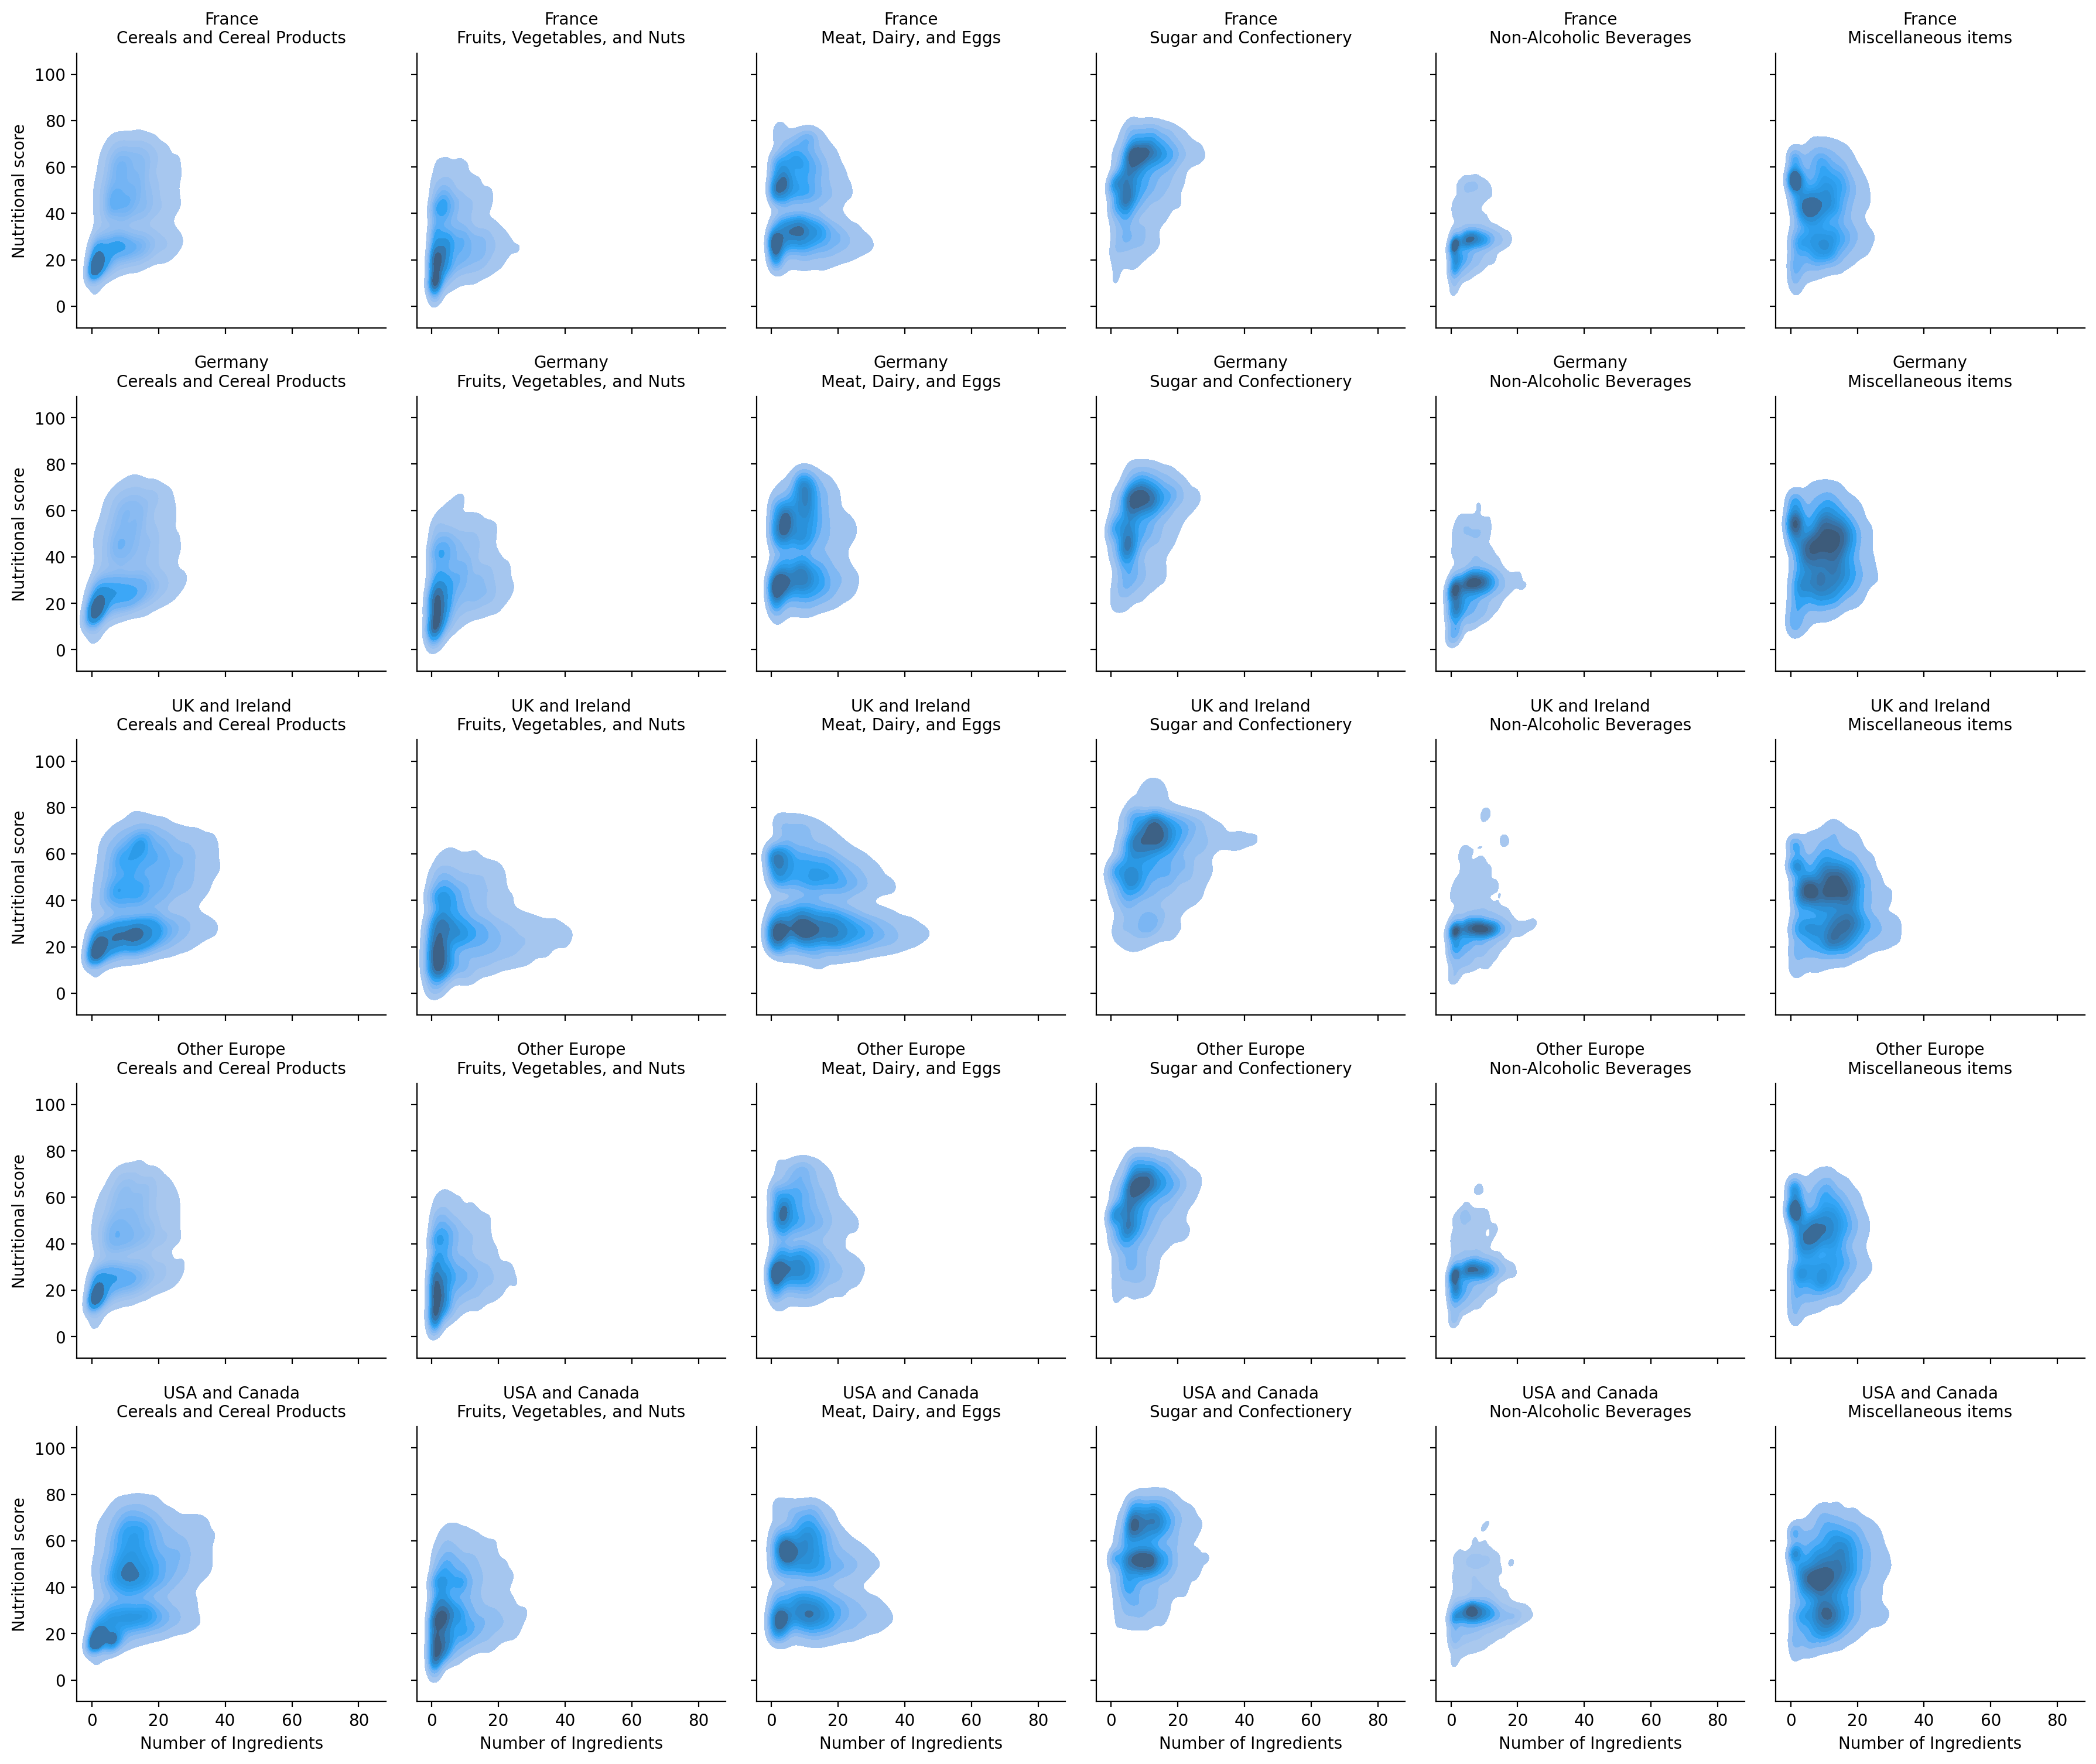

In [130]:
g = sns.FacetGrid(data=df_plot, 
                  col="groups", row='country',  
                  row_order=['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada'],
                  col_order=['Cereals and Cereal Products', 'Fruits, Vegetables, and Nuts',
                             'Meat, Dairy, and Eggs', 'Sugar and Confectionery', 
                             'Non-Alcoholic Beverages', 'Miscellaneous items'],
                  height=3)
g.map(sns.kdeplot, 'value', 'NutriScorePoints', fill=True)

g.set_axis_labels("Number of Ingredients", "Nutritional score")
g.set_titles("{row_name}\n{col_name}")
g.fig.subplots_adjust(hspace=0.25, wspace=0.1)
    
plt.show()

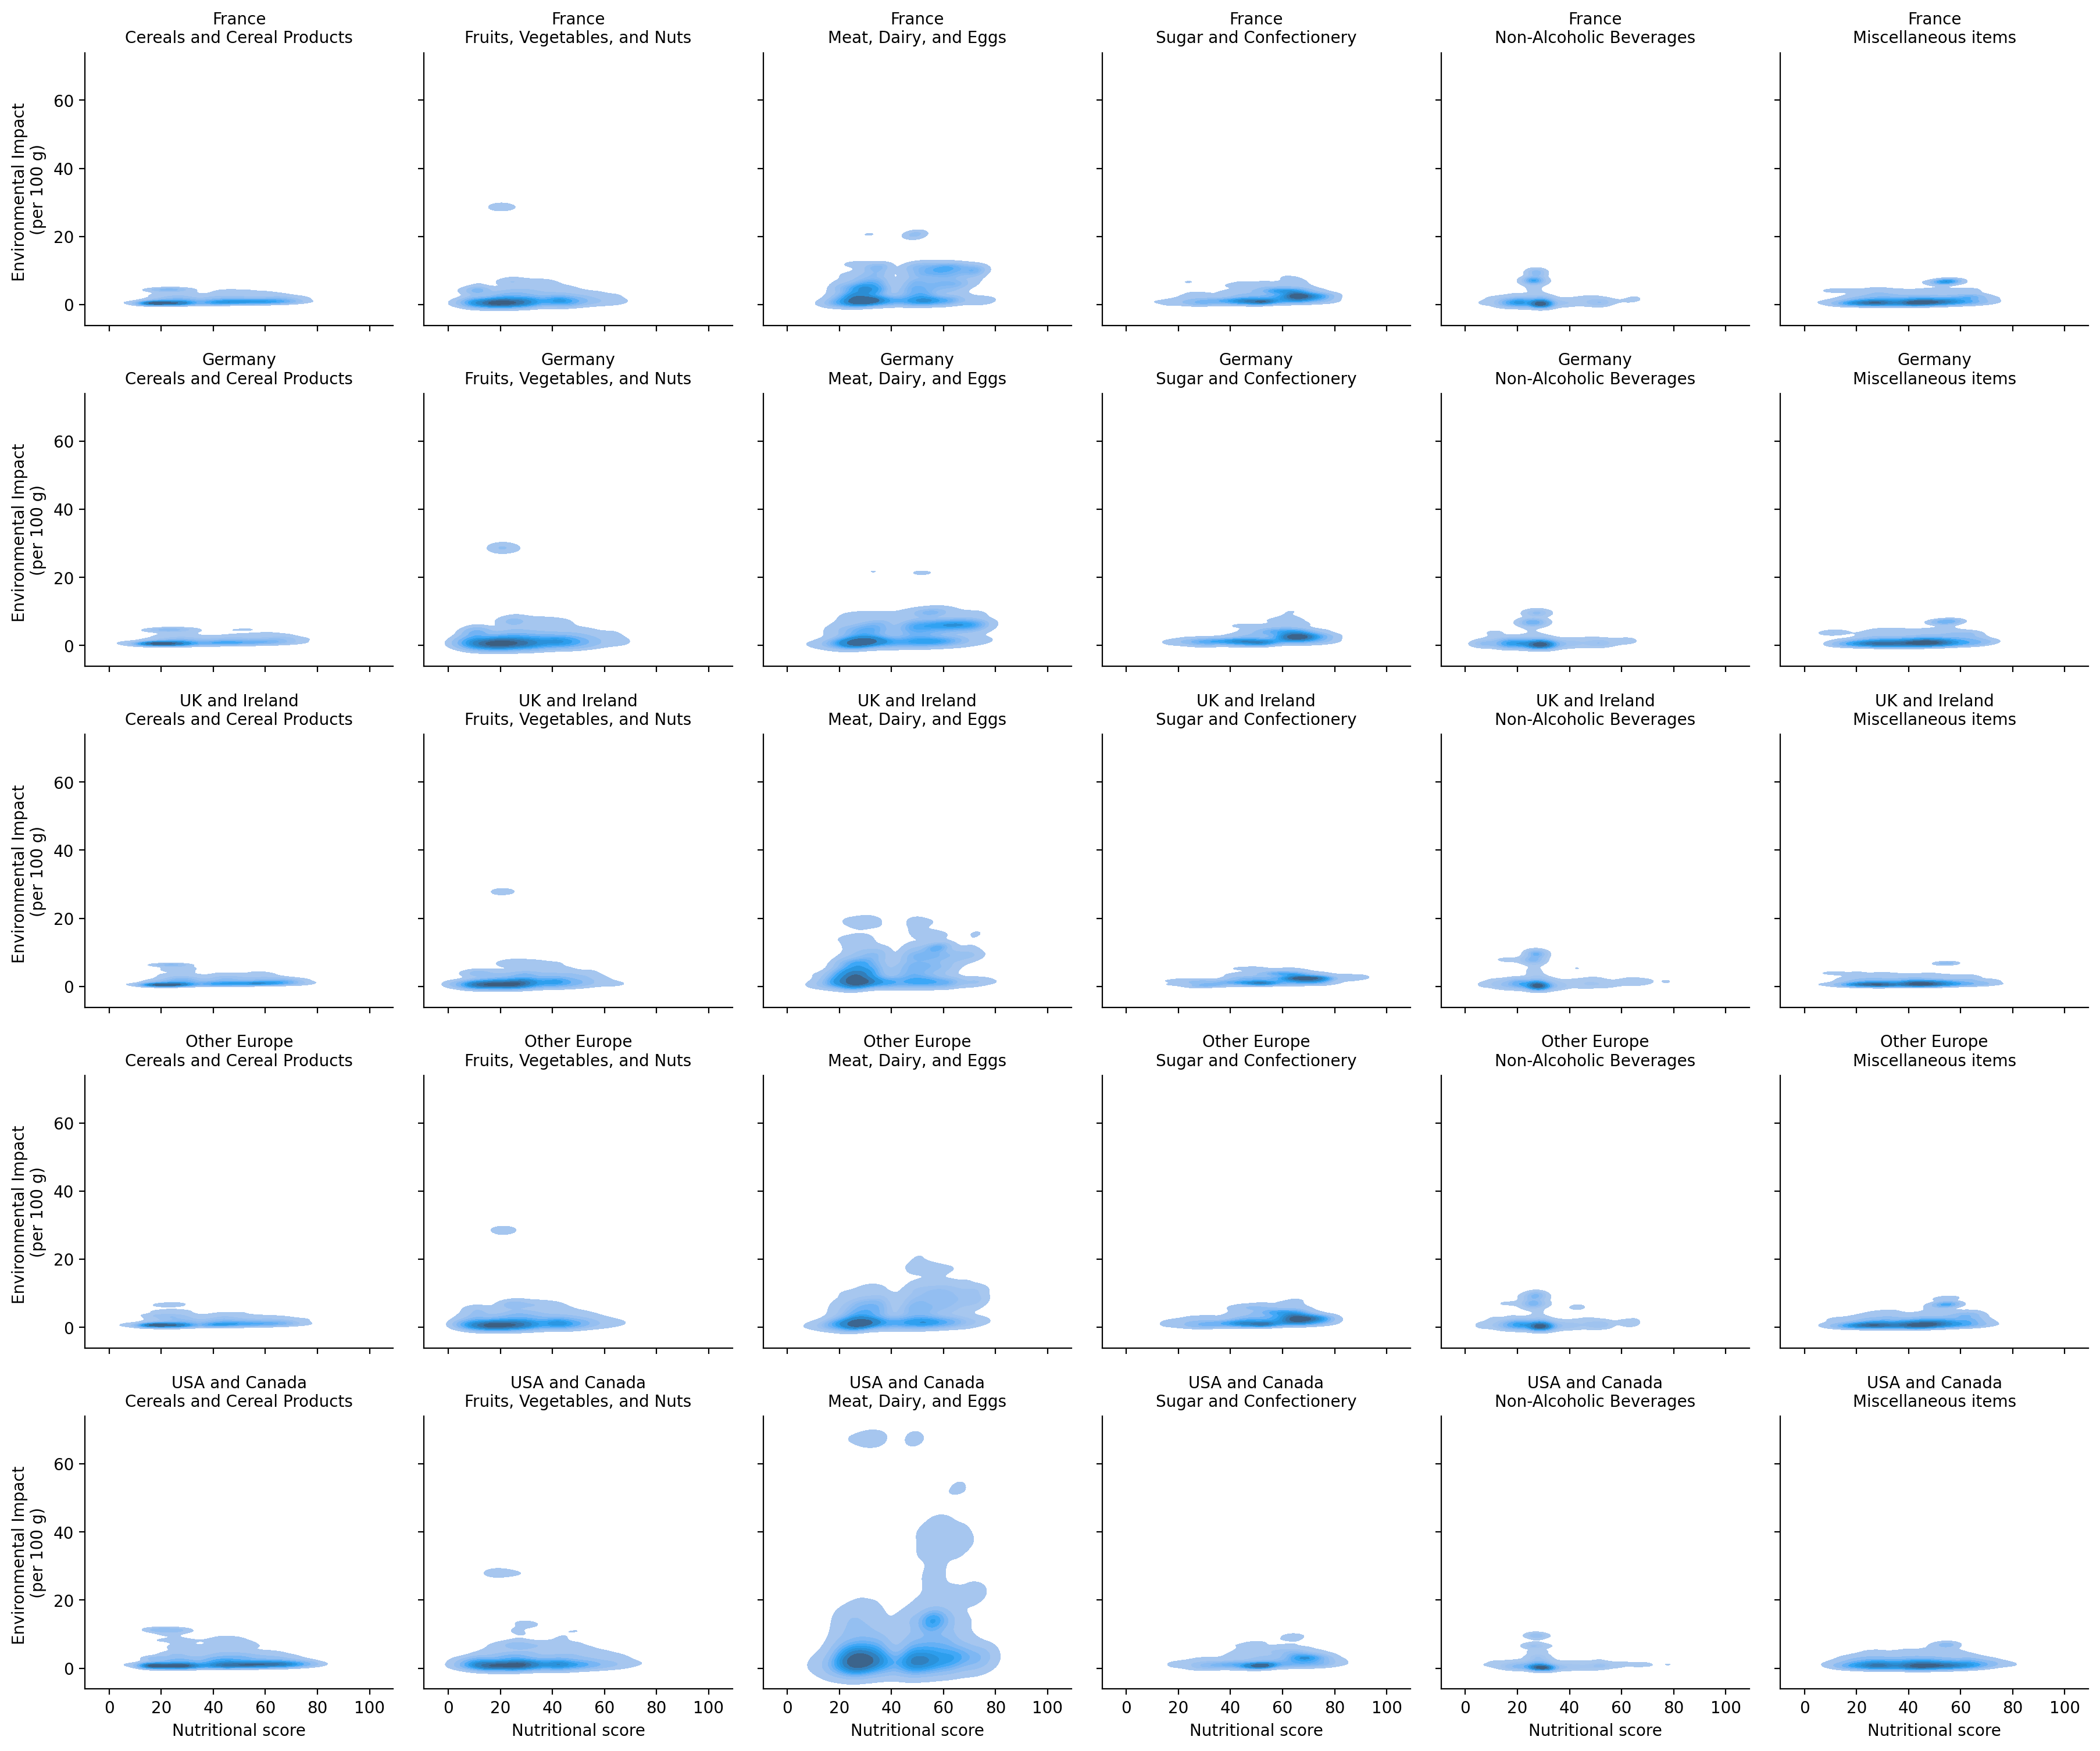

In [131]:
g = sns.FacetGrid(data=df_plot, 
                  col="groups", row='country',  
                  row_order=['France', 'Germany', 'UK and Ireland', 'Other Europe', 'USA and Canada'],
                  col_order=['Cereals and Cereal Products', 'Fruits, Vegetables, and Nuts',
                             'Meat, Dairy, and Eggs', 'Sugar and Confectionery', 
                             'Non-Alcoholic Beverages', 'Miscellaneous items'],
                  height=3)
g.map(sns.kdeplot, 'NutriScorePoints', 'mean_norm_agg', fill=True)

g.set_axis_labels("Nutritional score", "Environmental Impact \n(per 100 g)")
g.set_titles("{row_name}\n{col_name}")
g.fig.subplots_adjust(hspace=0.25, wspace=0.1)
    
plt.show()